# Construction of a prediction model for Covid19
## Part 2 of the notebook (for part one look at the fork of covidclinicaldata

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import eli5

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.dummy import DummyClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

shap.initjs() #So shap values can be displayed inline

In [27]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

covid19_test_results  age high_risk_exposure_occupation  \
0                 Negative    4                          True   
1                 Negative    2                         False   
2                 Negative    1                           NaN   
3                 Negative    3                          True   
4                 Negative    1                         False   
...                    ...  ...                           ...   
93989             Negative    3                         False   
93990             Negative    3                         False   
93991             Negative    3                         False   
93993             Negative    3                         False   
93994             Negative    2                         False   

      high_risk_interactions  diabetes    chd    htn  cancer  asthma  \
0                        NaN     False  False  False   False   False   
1                        NaN     False  False  False   False   False   
2                        NaN     False  False  False   False   False   
3                       True     False  False  False   False   False   
4                        NaN     False  False  False   False   False   
...                      ...       ...    ...    ...     ...     ...   
93989                   True     False  False  False   False   False   
93990                   True     False  False  False   False   False   
93991                  False     False  False  False   False   False   
93993                  False     False  False  False   False   False   
93994                  False     False  False  False   False   False   

       autoimmune_dis  ...    sob  sob_severity  diarrhea  fatigue  headache  \
0               False  ...  False           0.0     False    False     False   
1               False  ...  False           0.0     False    False     False   
2               False  ...    NaN           NaN       NaN      NaN       NaN   
3               False  ...   True           2.0     False     True     False   
4               False  ...  False           0.0     False    False     False   
...               ...  ...    ...           ...       ...      ...       ...   
93989           False  ...  False           0.0     False    False     False   
93990           False  ...  False           0.0     False    False     False   
93991           False  ...  False           0.0     False    False     False   
93993           False  ...  False           0.0     False    False     False   
93994           False  ...  False           0.0     False    False     False   

       loss_of_smell  loss_of_taste runny_nose muscle_sore sore_throat  
0              False          False      False       False       False  
1              False          False      False       False       False  
2                NaN            NaN        NaN         NaN         NaN  
3              False          False      False       False        True  
4              False          False      False       False       False  
...              ...            ...        ...         ...         ...  
93989          False          False      False       False       False  
93990          False          False       True       False        True  
93991          False          False      False       False       False  
93993          False          False      False       False       False  
93994          False          False      False       False       False  

[51695 rows x 35 columns]

In [28]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]

In [29]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10:16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 16:21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [30]:
e_factors, comorb, vitals, a_symptoms, r_symptoms = create_different_datasets(X)

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [31]:
def high_risk_exposure_imputation(data_x, data_y, target_imputation=False):    
    if target_imputation:
        mode = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]
    else:
        mode = True
    data_x.loc[data_x["high_risk_exposure_occupation"].isna(), "high_risk_exposure_occupation"] = mode
    
    data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]

def vitals_imputation_generic(data_x):
    data = data_x.copy()
    data.loc[data["temperature"].isna(),"temperature"] = data["temperature"].mean()
    data.loc[data["pulse"].isna(),"pulse"] = data["pulse"].median()
    data.loc[data["rr"].isna(),"rr"] = data["rr"].median()
    data.loc[data["sats"].isna(),"sats"] = data["sats"].median()
    data.loc[data_x["pam"].isna(), "pam"] = data_x["pam"].mean()
    
    return data


In [32]:
def reduce_training_set(data_x, data_y):
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum())
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def specificity_score(*values):    
    cm = confusion_matrix(*values)    
    return cm[0][0] / (cm[0][0] + cm[0][1]) 


def get_metrics(*values):
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    specificity = specificity_score(*values)
    return accuracy, recall, precision, specificity, f1 


In [33]:
class Imputer():
    
    def __init__(self):
        self.column_values = {}
        
    def fit_transform(self, data_x, data_y):
        self.fit(data_x, data_y)
        self.transform(data_x, training=True)
        
    def fit(self, data_x, data_y):
        self.get_high_risk_exposure_value(data_x, data_y)
        self.get_vitals_values(data_x)
        self.get_a_symptoms_values(data_x)
        self.get_r_symptoms_values(data_x)
        
    def transform(self, data_x, training=False):
        for feature in data_x.columns:           
            
            if feature in self.column_values:
                new_value = self.column_values[feature]
                
                if feature == "high_risk_exposure_occupation" and not training:
                    new_value=True
                    
                data_x.loc[data_x[feature].isna(), feature] = new_value
                
        if "high_risk_interactions" in data_x.columns: #Because this depends on 'high_risk_exposure_occupation being imputed first'
            data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]
        
        
        
    def get_high_risk_exposure_value(self, data_x, data_y):
        if "high_risk_exposure_occupation" in data_x.columns:
            self.column_values["high_risk_exposure_occupation"] = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]

        
    def get_vitals_values(self, data_x):
        if "temperature" in data_x.columns:
            self.column_values["temperature"] =  data_x["temperature"].mean()
        if "pulse" in data_x.columns:
            self.column_values["pulse"] = data_x["pulse"].median()
        if "rr" in data_x.columns:
            self.column_values["rr"] = data_x["rr"].median()
        if "sats" in data_x.columns:
            self.column_values["sats"] = data_x["sats"].median()
        if "pam" in data_x.columns:
            self.column_values["pam"] =  data_x["pam"].mean()
            
    def get_a_symptoms_values(self, data_x):
        
        if "ctab" in data_x.columns:
            self.column_values["ctab"] = data_x["ctab"].mode()[0]
            
        if "labored_respiration" in data_x.columns:
            self.column_values["labored_respiration"] = data_x["labored_respiration"].mode()[0]
            
        if "rhonchi" in data_x.columns:
            self.column_values["rhonchi"] = data_x["rhonchi"].mode()[0]
            
        if "wheezes" in data_x.columns:
            self.column_values["wheezes"] = data_x["wheezes"].mode()[0]
            
        if "days_since_symptom_onset" in data_x.columns:
            self.column_values["days_since_symptom_onset"] = data_x["days_since_symptom_onset"].median()
            
    def get_r_symptoms_values(self, data_x):
        if "cough" in data_x.columns:
            self.column_values["cough"] = data_x["cough"].mode()[0]
            
        if "cough_severity" in data_x.columns:
            self.column_values["cough_severity"] = data_x["cough_severity"].mode()[0]
            
        if "fever" in data_x.columns:
            self.column_values["fever"] = data_x["fever"].mode()[0]
            
        if "sob" in data_x.columns:
            self.column_values["sob"] = data_x["sob"].mode()[0]
            
        if "sob_severity" in data_x.columns:
            self.column_values["sob_severity"] = data_x["sob_severity"].mode()[0]
        
        if "diarrhea" in data_x.columns:
            self.column_values["diarrhea"] = data_x["diarrhea"].mode()[0]
            
        if "fatigue" in data_x.columns:
            self.column_values["fatigue"] = data_x["fatigue"].mode()[0]
            
        if "headache" in data_x.columns:
            self.column_values["headache"] = data_x["headache"].mode()[0]
            
        if "loss_of_smell" in data_x.columns:
            self.column_values["loss_of_smell"] = data_x["loss_of_smell"].mode()[0]
            
        if "loss_of_taste" in data_x.columns:
            self.column_values["loss_of_taste"] = data_x["loss_of_taste"].mode()[0]
    
        if "runny_nose" in data_x.columns:
            self.column_values["runny_nose"] = data_x["runny_nose"].mode()[0]
            
        if "muscle_sore" in data_x.columns:
            self.column_values["muscle_sore"] = data_x["muscle_sore"].mode()[0]
            
        if "sore_throat" in data_x.columns:
            self.column_values["sore_throat"] = data_x["sore_throat"].mode()[0]

In [34]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y, sample_weight=None):
        self.model.fit(self.xgb_adapter(data_x), data_y, sample_weight=sample_weight)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
    
    def predict_proba(self, data_x):
        return self.model.predict_proba(self.xgb_adapter(data_x))
    
    def score(self, X, y, sample_weight=None):
        return self.model.score(X, y, sample_weight=None)
    
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [35]:
def calculate_shap_values(model, data_x):
    explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
    sample = data_x.sample(1)
    display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
    
def permutation_importance(model, X, Y, num_shuffles=50):
    feature_score_difference = np.full((len(X.columns), num_shuffles), 0, dtype=float)
    og_predictions = model.predict(X)
    og_error = accuracy_score(Y, og_predictions)
    for i in range(len(X.columns)): # Para cada feature
        feature = X.columns[i]
        shuffled_values = pd.DataFrame(X, copy = True) # Para que no afecte el dataset original solo copiamos los valores
        for j in range(num_shuffles):
            np.random.shuffle(shuffled_values[feature].values)
            col_preds = model.predict(shuffled_values)
            col_error = accuracy_score(Y, col_preds)
            feature_score_difference[i][j] = col_error - og_error # og tiene que ser mas pequeño
    result_table = np.array([feature_score_difference.mean(axis=1), feature_score_difference.std(axis=1)])
    
    df = pd.DataFrame(np.transpose(result_table), columns=["Importancia", "Desviacion estándar"], index=X.columns)
    return df.sort_values(by="Importancia", ascending = False)

In [36]:
def cross_validation_normal(data_x, data_y, model, folds, sample_weights=None):
    results = np.zeros((folds,2,5)) #Shape of folds, training and validation, and number of metrics
    if sample_weights is None:
        sample_weights = np.ones(data_y.shape)
       
    fold_size = data_x.shape[0] // folds
    reminder = data_x.shape[0] % folds    
    start = 0    
    imputer = Imputer()
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1
        train_x = pd.concat([data_x.iloc[:start], data_x.iloc[end:]], axis=0)
        train_y = data_y.iloc[:start].append(data_y.iloc[end:])
        valid_x = data_x.iloc[start:end]
        valid_y = data_y.iloc[start:end]
                    
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
            
        model.fit(train_x, train_y, sample_weight=np.append(sample_weights[:start], sample_weights[end:]))
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")    
       
    
    return results.mean(axis=0)



def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=.5, plot_roc=True, feature_importances=True):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = positive_index.shape[0] * ratio_negatives_to_positives
    
    fold_size = positive_index.shape[0] // folds
    results = np.zeros((folds,2,6)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = Imputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(size_of_negatives - fold_size), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        valid_x = pd.concat([data_x[data_y == "Negative"].sample(fold_size * ratio_negatives_to_positives), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
                    
        model.fit(train_x, train_y)
        
        ##The following lines are for predicting via probability
        t_pred_prob = model.predict_proba(train_x)[:,1] ## We choose '1' in predict_proba since that is the positive class
        v_pred_prob = model.predict_proba(valid_x)[:,1]  ## We choose '1' in predict_proba since that is the positive class      
               
        t_preds = np.zeros(train_x.shape[0], dtype = np.object)
        t_preds[t_pred_prob > class_threshold] = "Positive"
        t_preds[t_pred_prob <= class_threshold] = "Negative"
        
        v_preds = np.zeros(valid_x.shape[0], dtype = np.object)
        v_preds[v_pred_prob > class_threshold] = "Positive"
        v_preds[v_pred_prob <= class_threshold] = "Negative"
        
        ##End of probability calculations
        
        train_v = (train_y, t_preds) #original: insted of t_preds is model.predict
        valid_v = (valid_y, v_preds)  #original: insted of v_preds is model.predict
        results[i,0] += get_metrics(*train_v) + (roc_auc_score(train_y, t_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        results[i,1] += get_metrics(*valid_v) + (roc_auc_score(valid_y, v_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
                    
    print("")
    
    try:

        train_shap_x = pd.concat([data_x[data_y == "Negative"].sample((size_of_negatives - fold_size) // 2), data_x.loc[positive_index].sample((size_of_negatives - fold_size) // 2)], axis=0)
        
        test_shap_x = data_x.loc[np.setdiff1d(data_x.index.values, train_shap_x.index.values)].sample(fold_size)

        imputer.fit_transform(train_shap_x, data_y[train_shap_x.index])
        imputer.transform(test_shap_x)
        model.fit(train_shap_x, data_y[train_shap_x.index])
        
        
        if plot_roc:
            roc_values = roc_curve(data_y[test_shap_x.index], model.predict_proba(test_shap_x)[:,1], pos_label="Positive", drop_intermediate=False)
                      
            fig, ax = plt.subplots(1, 2, sharey=True, figsize=(21,7))
            
            ax[0].plot(roc_values[2], roc_values[0], 'b-', label="Recall")
            ax[0].plot(roc_values[2], roc_values[1], 'r-', label="FPR")
            ax[0].set(xlabel = "Thresholds")
            ax[0].legend()
            
             ## The following lines produce the same result as calling the 'sklearn.metrics.plot_roc_curve'
            ax[1].plot(roc_values[0], roc_values[1], 'b-')
            ax[1].set(xlabel = "FPR (1-specificity)", ylabel= "TPR (recall)")
            
            #plot_roc_curve(model, test_shap_x, data_y[test_shap_x.index], drop_intermediate=True)
            plt.show()
        
        if feature_importances:
            #explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
            #sample = data_x.sample(fold_size)
            #display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
            #display(permutation_importance(model, test_shap_x, y[test_shap_x.index], 5)) ## Doesn't seem to be working very well
            PI = eli5.sklearn.PermutationImportance(model)
            PI.fit(test_shap_x, data_y[test_shap_x.index])
            print("feature_importances")
            display(eli5.show_weights(model, feature_names=list(data_x.columns)))
            print("Permutation Importance")
            display(eli5.show_weights(PI, feature_names=list(data_x.columns)))
        
    except Exception as e:
        print(e)
    
    
    return results.mean(axis=0)

def run_threshold(data_x, data_y, model, thresholds=np.linspace(0,1, num=11), folds=10, ratio_negatives_to_positives=1):
    
    threshold_scores = np.zeros((5,thresholds.shape[0]))
    i = 0 #the threshold index im in
    for t in thresholds:
        
        
        results = cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=t, plot_roc=False, feature_importances=False)
        print("Threshold:", t)       
        
        for metric in range(5):
            threshold_scores[metric,i] = results[1][metric]      
        i+=1
    
    plt.figure(figsize=(21,7))
    plt.plot(thresholds, threshold_scores[0], label="Accuracy")
    plt.plot(thresholds, threshold_scores[1], label="Recall")
    plt.plot(thresholds, threshold_scores[2], label="Precision")
    plt.plot(thresholds, threshold_scores[3], label="Specificity")
    plt.plot(thresholds, threshold_scores[4], label="F1 score")
    plt.legend()
    plt.show()
    
    display(pd.DataFrame(threshold_scores, index=["Accuracy", "Recall", "Precision", "Specificity", "F1"], columns=thresholds))
        
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1, sample_weights=None):
    result_table = np.zeros((len(models), 6))
    i = 0
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        try:
            if(ratio_negatives_to_positives >= 1):            
                results = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)
            else:
                results = cross_validation_normal(data_x, data_y, models[model], folds, sample_weights)    
            
            result_table[i] = results[1]
            
            display(pd.DataFrame(results, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
            print("")
        except Exception as e:
            print(e)
        i+=1
    display(pd.DataFrame(result_table, index=models.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))

In [37]:
models ={
    "Dummy Random" : DummyClassifier(strategy="uniform"), #does not have predict_proba
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    "SVM" : SVC(kernel='linear', probability=True), 
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

<i>Note: I tried to calculate data with the imbalanced datasets (cross validation with all positive and negative examples) and discovered that it didn't work so I deleted those experiments so the notebook looks cleaner with the ones that count</i>


Next step to either add more features or... implement a cross validation method that makes up for the difference between positives and negatives

In [38]:
comorb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51695 entries, 0 to 93994
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   diabetes        51695 non-null  bool 
 1   chd             51695 non-null  bool 
 2   htn             51695 non-null  bool 
 3   cancer          51695 non-null  bool 
 4   asthma          51695 non-null  bool 
 5   autoimmune_dis  51695 non-null  bool 
 6   smoker          51695 non-null  bool 
dtypes: bool(7)
memory usage: 757.3 KB


Dummy Random
╠■■■■■■■■■╣


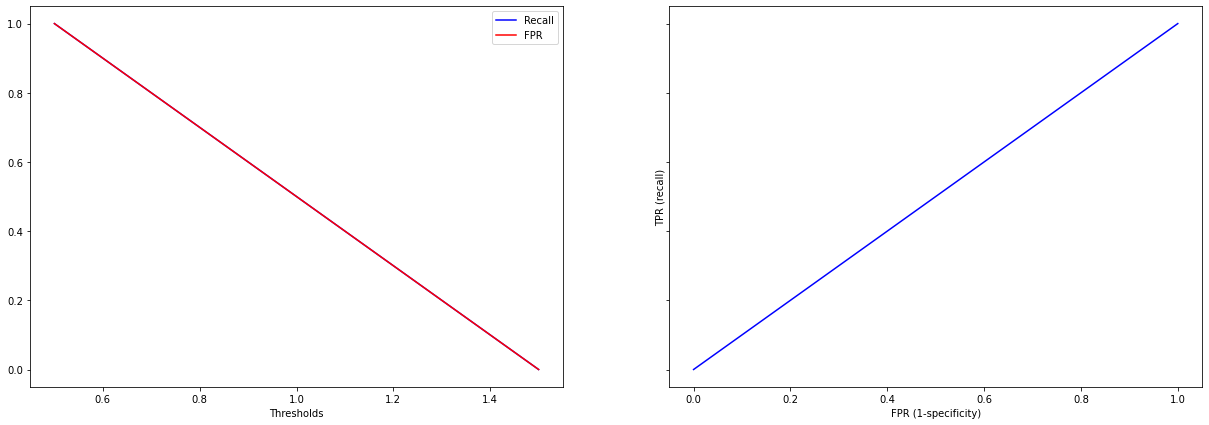

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


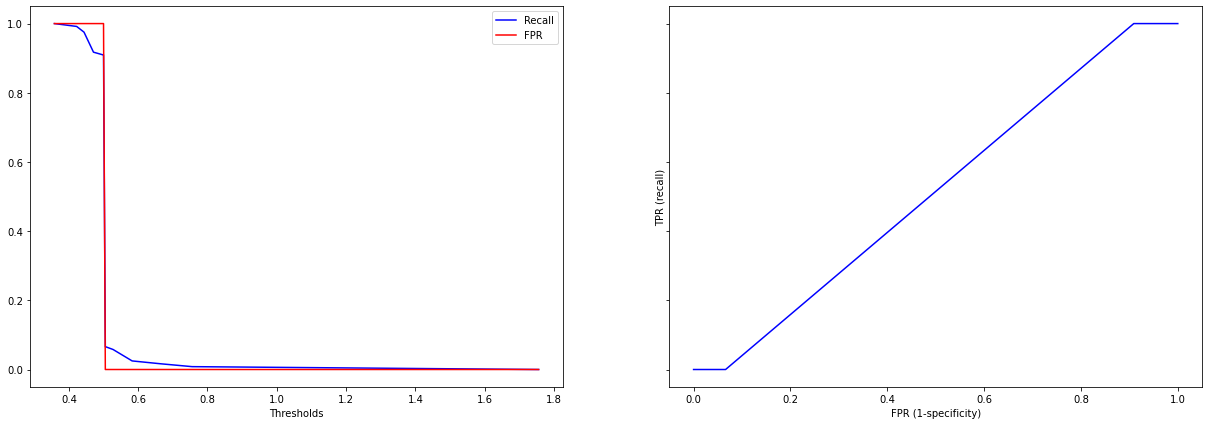

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.506865  0.092383   0.541584     0.921273  0.156838  0.518306
Validation  0.495082  0.085086   0.470505     0.905738  0.143218  0.505195


Random Forest (100 estimators)
╠■■■■■■■■■╣


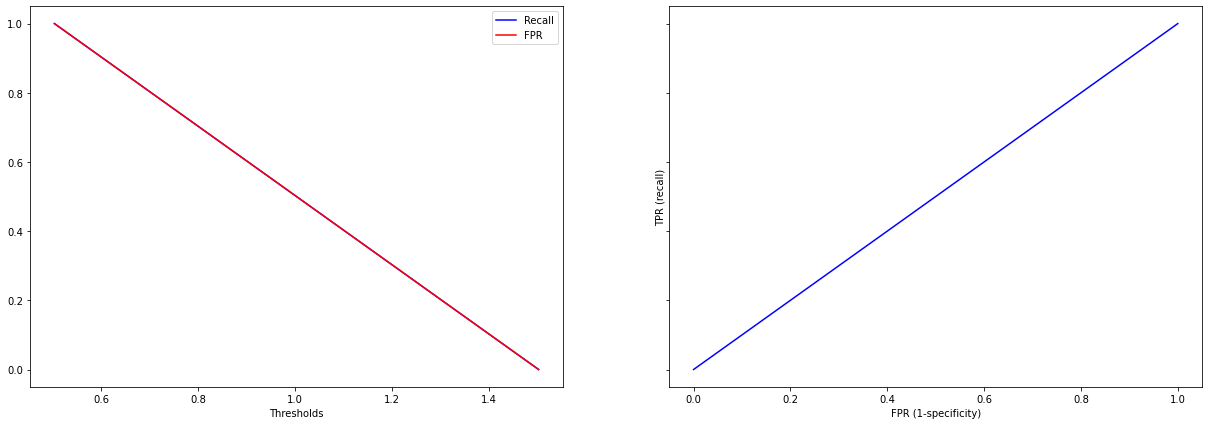

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.500864  0.593455   0.351611     0.408273  0.409926  0.501224
Validation  0.496721  0.590164   0.326790     0.403279  0.401250  0.495522


XGBoost Classifier
╠■■■■■■■■■╣


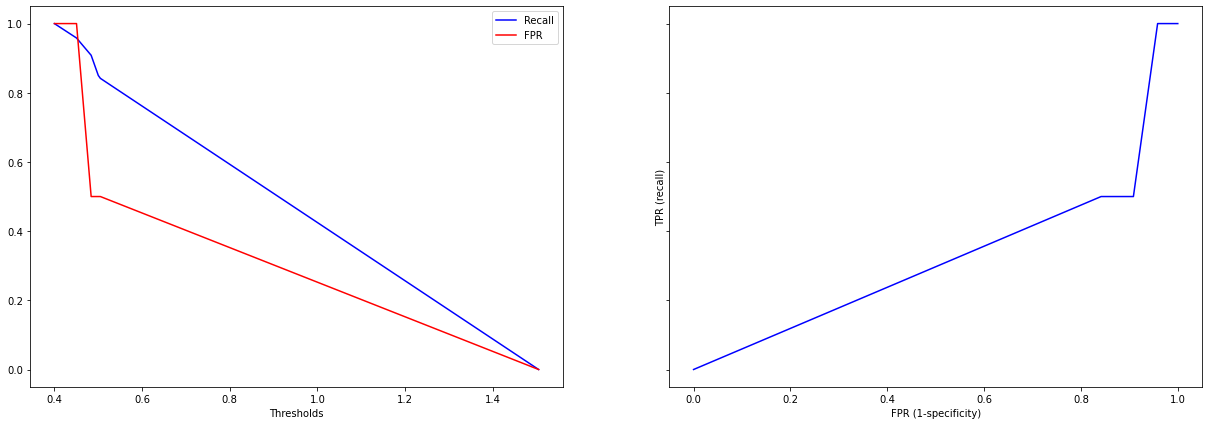

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.516956  0.904444   0.509592     0.129545  0.651601  0.526711
Validation  0.506559  0.886199   0.503873     0.126230  0.641771  0.506426


SVM
╠■■■■■■■■■╣


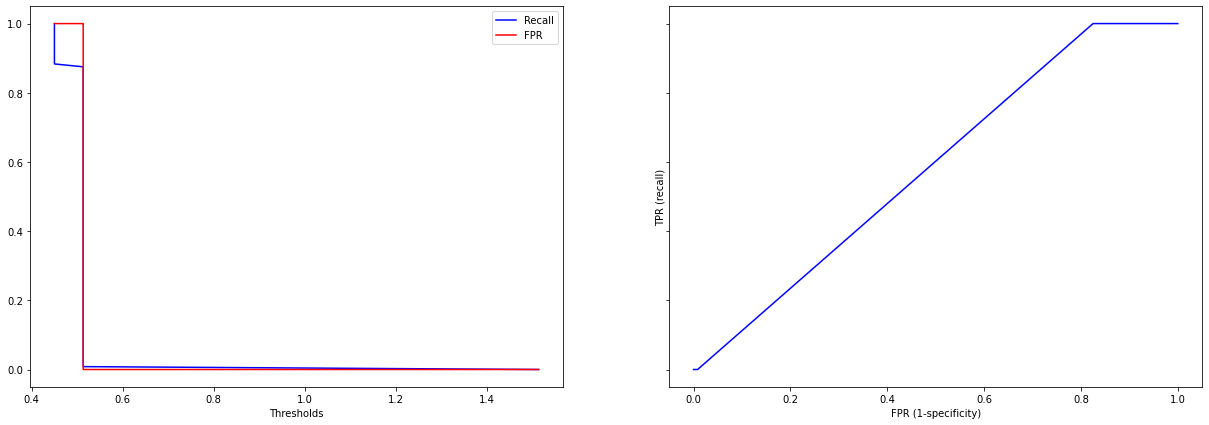

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.490589  0.325839   0.353968     0.655273  0.259682  0.487991
Validation  0.490997  0.327696   0.371477     0.654918  0.258375  0.483536


KNN
╠■■■■■■■■■╣


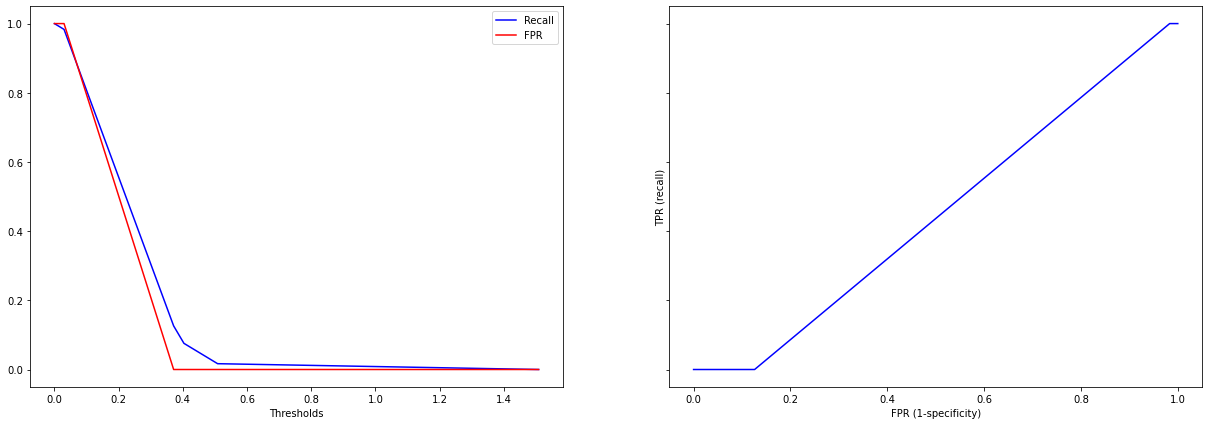

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.509819  0.034005   0.724068     0.985545  0.064083  0.502335
Validation  0.503678  0.028615   0.536746     0.979508  0.053906  0.500403


Logistic Regression
╠■■■■■■■■■╣


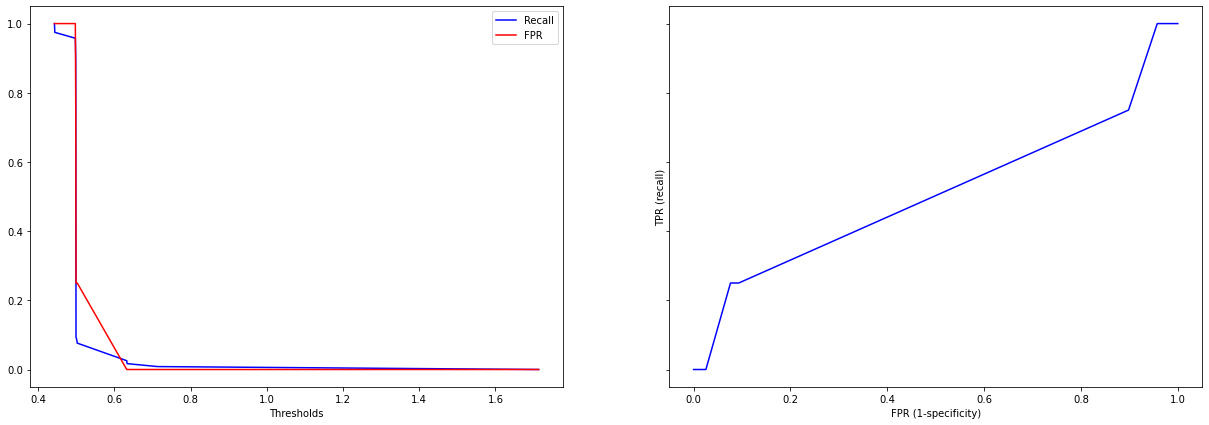

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.514320  0.810798    0.51463     0.217909  0.596946  0.521498
Validation  0.497116  0.794409    0.49163     0.199180  0.580849  0.499188

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.495082  0.085086   0.470505     0.905738   
Random Forest (100 estimators)  0.496721  0.590164   0.326790     0.403279   
XGBoost Classifier              0.506559  0.886199   0.503873     0.126230   
SVM                             0.490997  0.327696   0.371477     0.654918   
KNN                             0.503678  0.028615   0.536746     0.979508   
Logistic Regression             0.497116  0.794409   0.491630     0.199180   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.143218  0.505195  
Random Forest (100 estimators)  0.401250  0.495522  
XGBoost Classifier              0.641771  0.506426  
SVM                             0.258375  0.483536  
KNN                             0.053906  0.500403  
Logistic Regression             0.580849  0.499188

In [14]:
run_models(comorb, y[comorb.index], models, ratio_negatives_to_positives = 1)

Most of the models don't do better than random guessing (the metric we want to optimize is recall; however, since the data is being undersampled to combat the class imbalance, Accuracy is a good metric to keep an eye on as well). <b>Asthma</b>, <b>Smoker</b> and <b>Diabetes</b> seem to be the most prominent features, although they don't seem to be consistent (they change every time I run the cell again).

Dummy Random
╠■■■■■■■■■╣


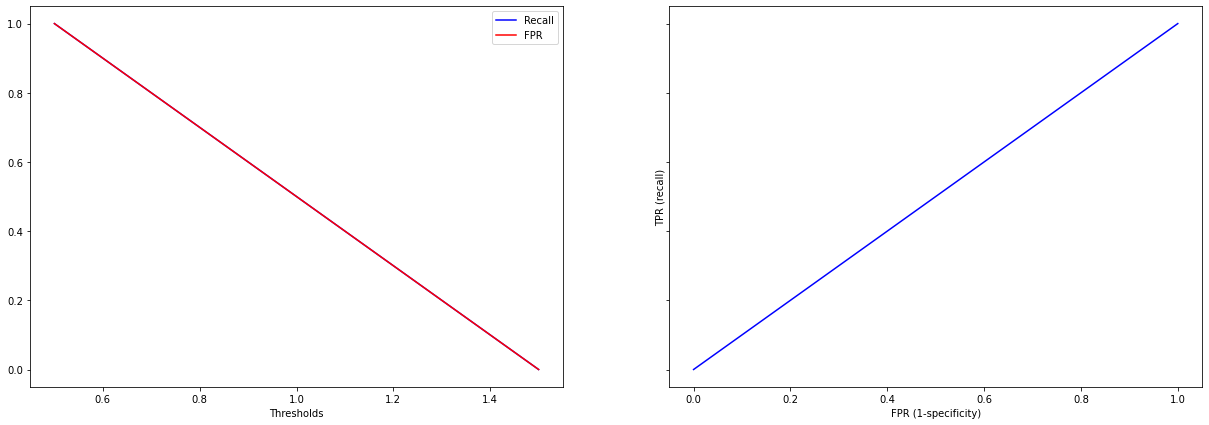

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


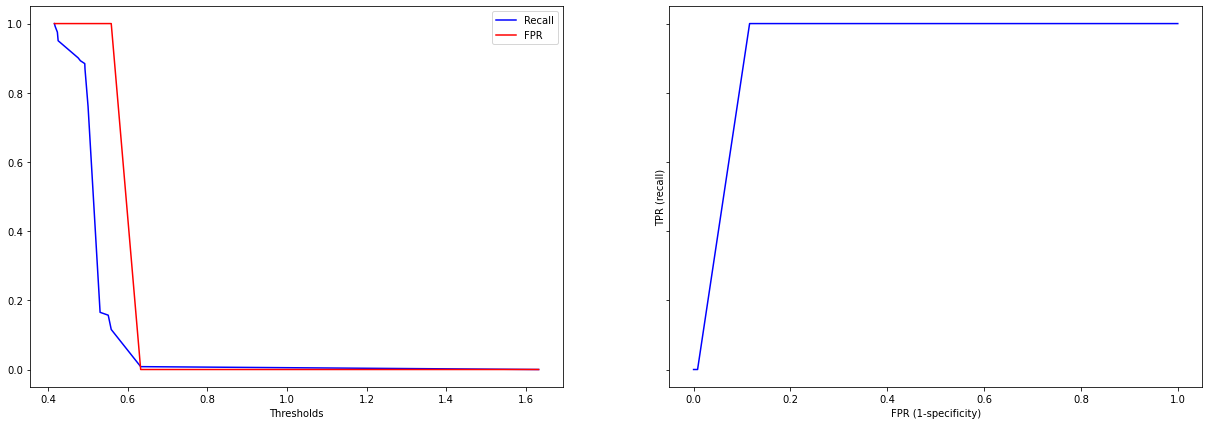

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.526548  0.202580   0.575667     0.850455  0.299041  0.559580
Validation  0.526577  0.198687   0.567069     0.854918  0.290807  0.558189


Random Forest (100 estimators)
╠■■■■■■■■■╣


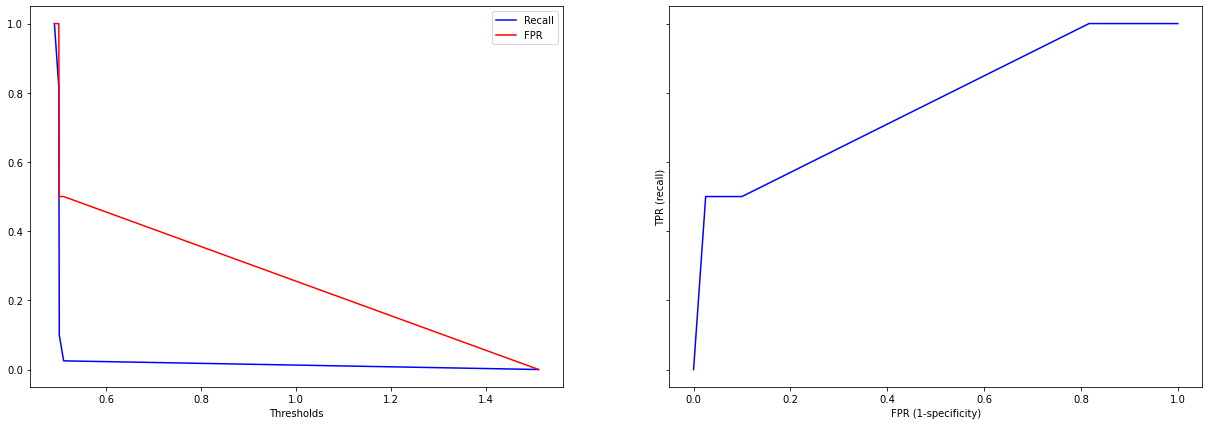

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.531957  0.599091   0.547023     0.464818  0.505365  0.550600
Validation  0.508613  0.564054   0.518939     0.453279  0.468919  0.518984


XGBoost Classifier
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1  ROC_AUC
Training    0.545777  0.732701   0.546696     0.358909  0.588591  0.57009
Validation  0.527014  0.696968   0.529384     0.356557  0.560055  0.54934


SVM
╠■■■■■■■■■╣


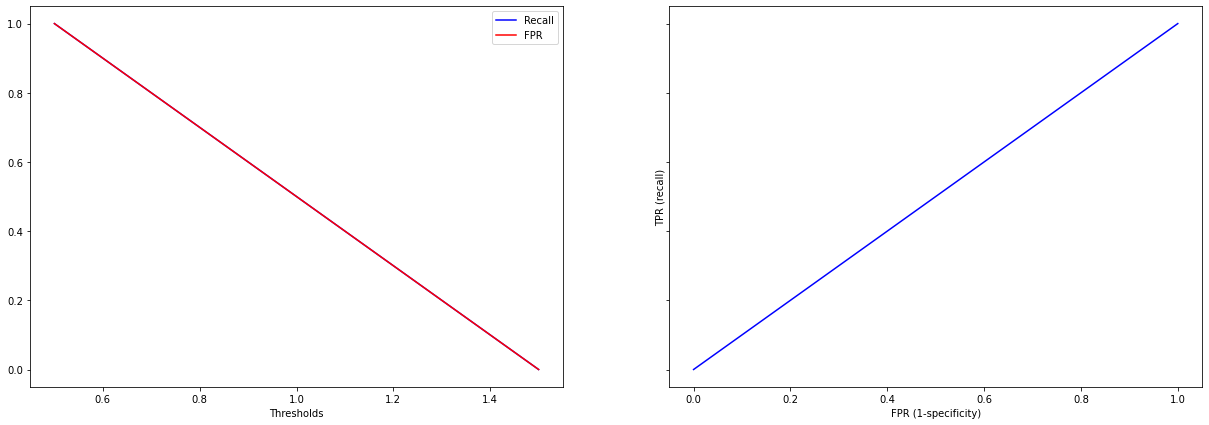

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.533276  0.371002   0.582920     0.695545  0.384846  0.553179
Validation  0.517625  0.341917   0.566575     0.693443  0.358464  0.529816


KNN
╠■■■■■■■■■╣


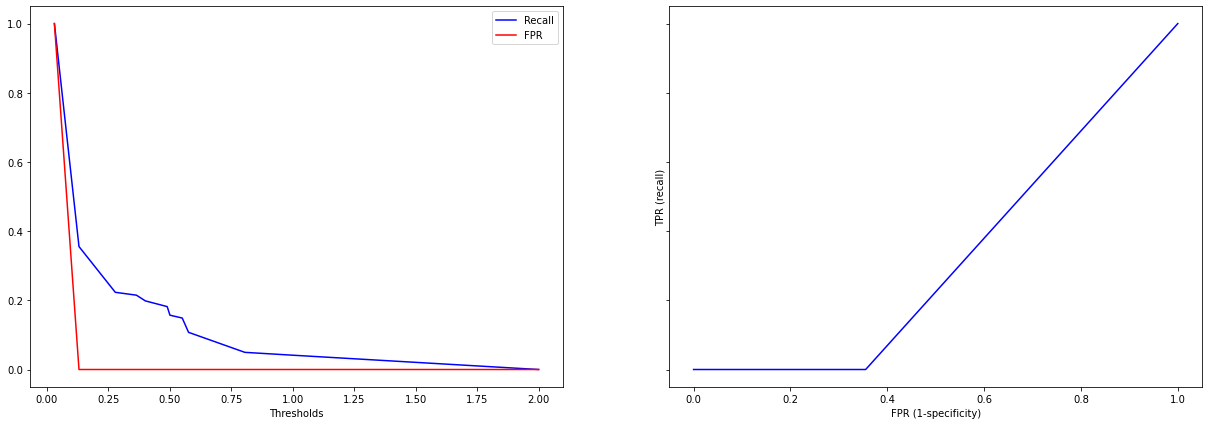

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.518683  0.062558   0.734250     0.974727  0.113138  0.540973
Validation  0.506930  0.056324   0.502897     0.958197  0.094166  0.528624


Logistic Regression
╠■■■■■■■■■╣


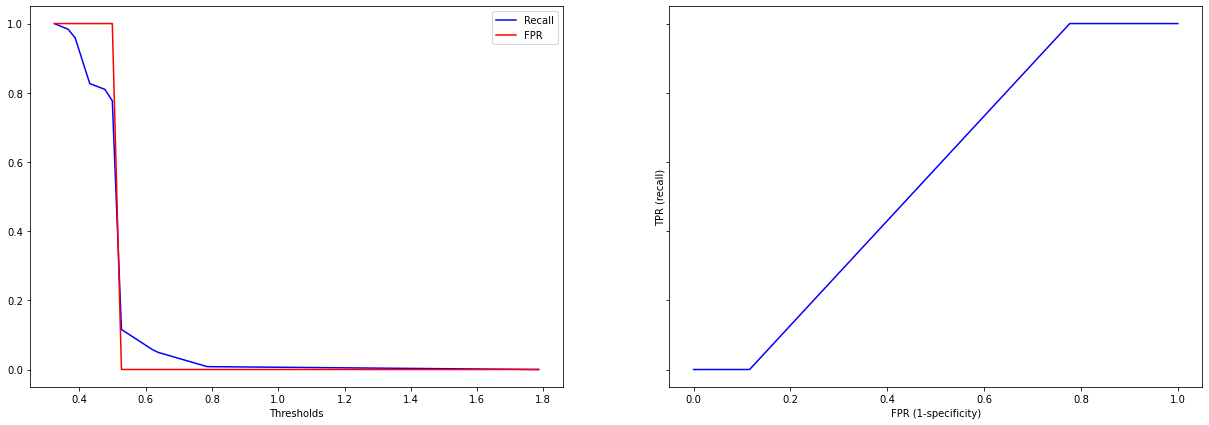

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.541821  0.658642   0.548433     0.425000  0.550302  0.563978
Validation  0.526196  0.636839   0.517251     0.415574  0.528637  0.548253

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.526577  0.198687   0.567069     0.854918   
Random Forest (100 estimators)  0.508613  0.564054   0.518939     0.453279   
XGBoost Classifier              0.527014  0.696968   0.529384     0.356557   
SVM                             0.517625  0.341917   0.566575     0.693443   
KNN                             0.506930  0.056324   0.502897     0.958197   
Logistic Regression             0.526196  0.636839   0.517251     0.415574   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.290807  0.558189  
Random Forest (100 estimators)  0.468919  0.518984  
XGBoost Classifier              0.560055  0.549340  
SVM                             0.358464  0.529816  
KNN                             0.094166  0.528624  
Logistic Regression             0.528637  0.548253

In [15]:
comorb_ef = pd.concat([comorb.drop(columns="smoker"), e_factors.drop(columns="age")], axis=1)
run_models(comorb_ef, y[comorb_ef.index], models, ratio_negatives_to_positives = 1)

We definetley need another set, even though using the cross validation for data imbalancing helped a lot. <b>High risk exposure occupation</b> seems to be the most important feature from epidemiological factors. <i>Note:</i> Most of the models have really high specificity, which might not be a good thing since the recall is really low and both precision and accuracy are just around .5 (this experiments use undersampling to have balanced classes). This suggests that most of the models are predicting everything is negative.

### Vitals

$ PAM = DIA + \frac{SIS-DIA}{3}$<br>
where PAM = Presión arterial media
SIS = Sístole
DIA = Diástole

In [39]:
def calculate_pam(data_x):
    return vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)

In [40]:
pam = vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)
vitals = pd.concat([vitals, pam], axis=1)
vitals.rename({ 0 : "pam"}, axis=1,inplace =True) #To rename the column that was appended (which has a value of 0 that is not a string)
i = vitals[vitals.iloc[:,-1] >145].iloc[:,-1].index
pd.concat([vitals.loc[i, ["sys", "dia"]], e_factors.loc[i,"age"]], axis=1)

sys    dia  age
5135   195.0  135.0    4
6106   215.0  115.0    4
9058   200.0  120.0    3
11792  190.0  130.0    3
14314  205.0  125.0    4
19137  215.0  117.0    4
20168  190.0  130.0    4
20379  220.0  140.0    4
20582  200.0  118.0    4
28579  180.0  130.0    3
31555  185.0  130.0    3
31880  180.0  135.0    2
33497  210.0  120.0    4
36197  190.0  135.0    3
36239  185.0  135.0    3
45860  220.0  115.0    3
48067  190.0  130.0    4
50607  220.0  108.0    4
75219  195.0  130.0    2
76797  195.0  130.0    1
77724  190.0  135.0    2
91625  210.0  125.0    3
93508  200.0  118.0    4

As expected, all pressure variables (including pam) are correlated between each other

In [41]:
#Drop all values that are Nan
vitals.dropna(how="all",inplace=True)
vitals.drop(columns=["sys", "dia"], inplace=True) #Because we have 'pam' we don't need it anymore (I ran some experiments and it is sligthly better with 'pam')
vitals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48705 entries, 0 to 93994
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  46961 non-null  float64
 1   pulse        47666 non-null  float64
 2   rr           40972 non-null  float64
 3   sats         46959 non-null  float64
 4   pam          45990 non-null  float64
dtypes: float64(5)
memory usage: 2.2 MB


In [42]:
vitals.describe()

temperature         pulse            rr          sats           pam
count  46961.000000  47666.000000  40972.000000  46959.000000  45990.000000
mean      36.795284     76.895103     14.708826     98.239869     93.238276
std        0.287278     13.211416      1.957359      1.401417     10.886470
min       34.650000     35.000000      8.000000     81.000000     50.333333
25%       36.650000     68.000000     13.000000     97.000000     86.000000
50%       36.800000     76.000000     15.000000     98.000000     92.666667
75%       36.950000     85.000000     16.000000     99.000000     99.666667
max       39.600000    150.000000     32.000000    100.000000    166.666667

<AxesSubplot:>

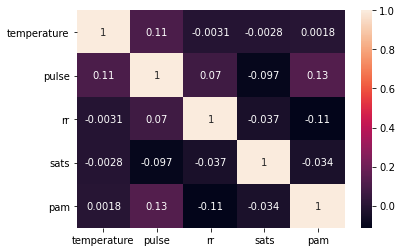

In [43]:
sns.heatmap(vitals.corr(), annot=True)

In [44]:
s_vitals = vitals.copy()
s_vitals = s_vitals.apply(lambda x: (x - x.mean()) / x.std())
n_vitals = vitals.copy()
n_vitals = s_vitals.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Dummy Random
╠■■■■■■■■■╣


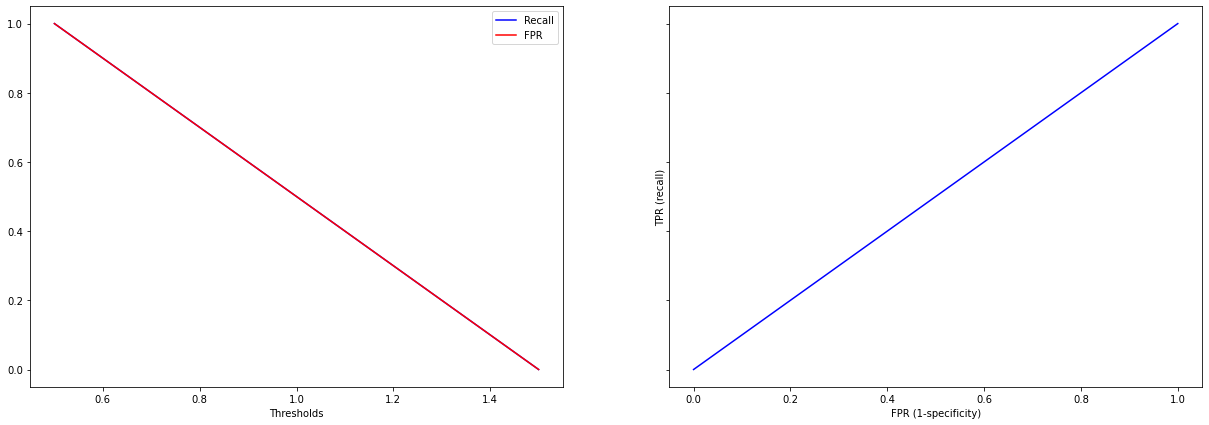

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


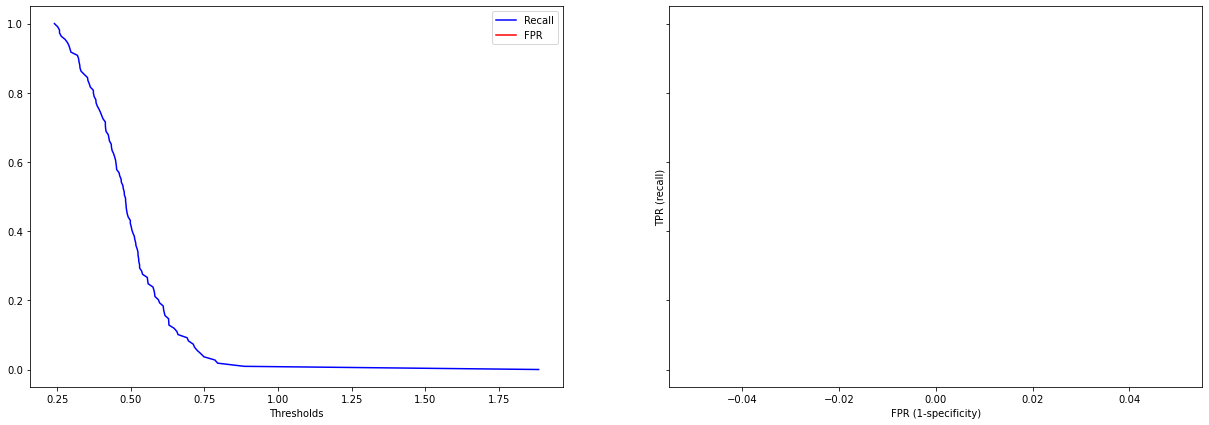

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.561366  0.528257   0.565525     0.594444  0.546225  0.590883
Validation  0.557796  0.520500   0.562085     0.595413  0.538891  0.589927


Random Forest (100 estimators)
╠■■■■■■■■■╣


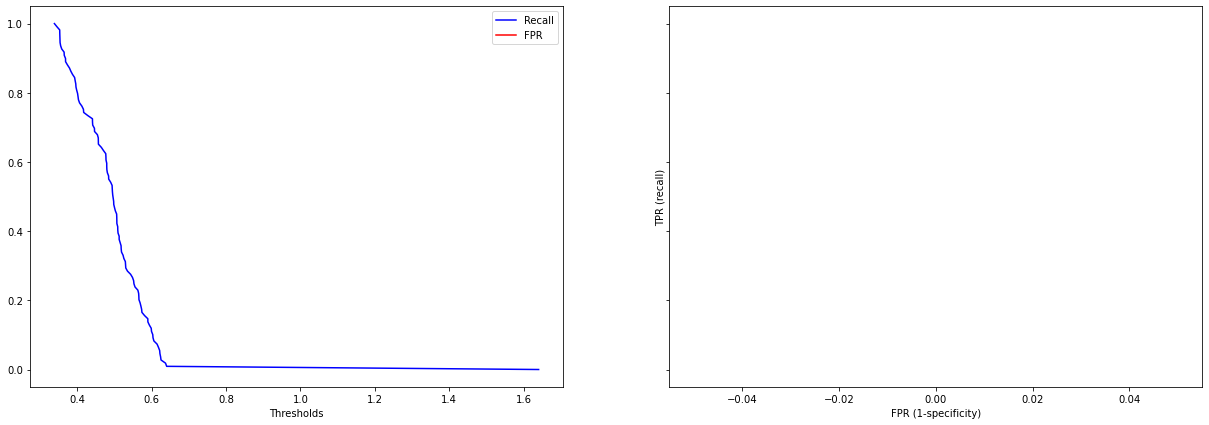

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.612702  0.586996   0.619024     0.638384  0.602332  0.663310
Validation  0.581568  0.558766   0.584701     0.604587  0.568741  0.625597


XGBoost Classifier
╠■■■■■■■■■╣


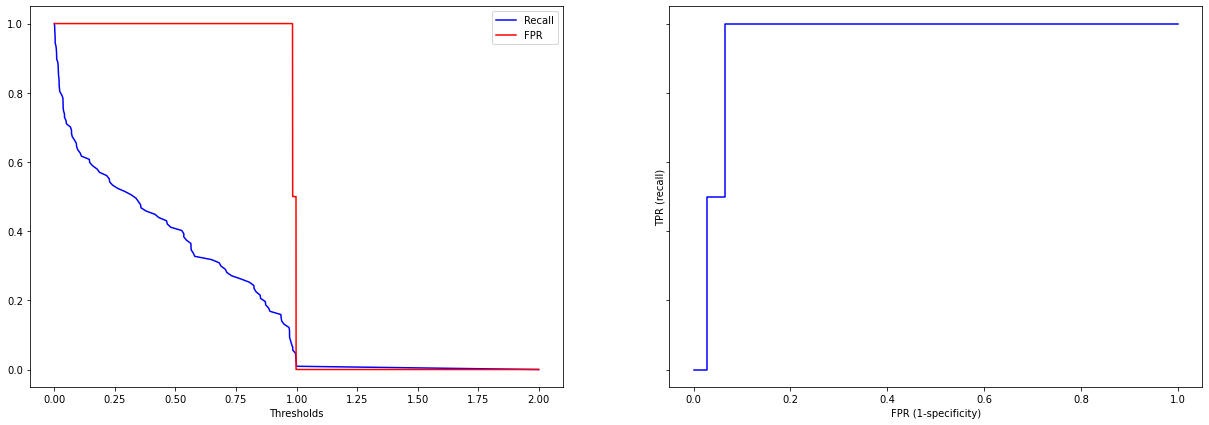

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.997575  0.997472   0.997675     0.997677  0.997573  0.999983
Validation  0.545941  0.528707   0.547682     0.563303  0.537307  0.579816


SVM
╠■■■■■■■■■╣


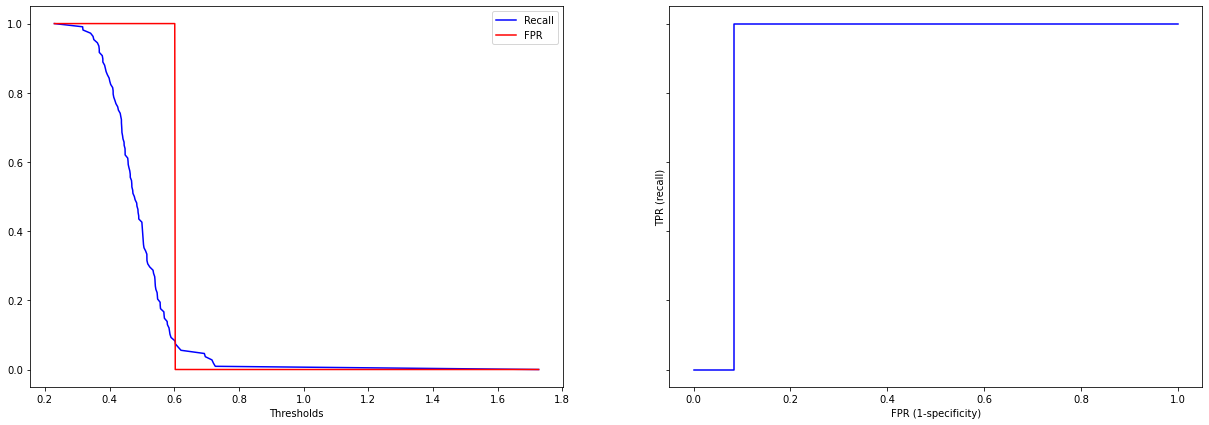

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.594008  0.545851   0.603747     0.642121  0.573286  0.640219
Validation  0.577448  0.542369   0.582737     0.612844  0.559929  0.615994


KNN
╠■■■■■■■■■╣


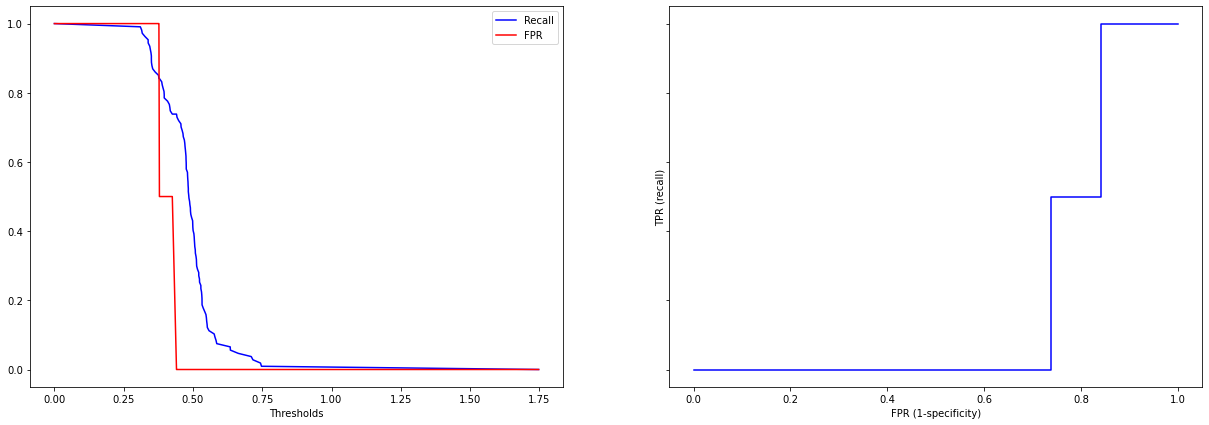

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998737  0.997573   0.999899     0.999899  0.998734  0.999996
Validation  0.540426  0.550500   0.541865     0.530275  0.544984  0.565372


Logistic Regression
╠■■■■■■■■■╣


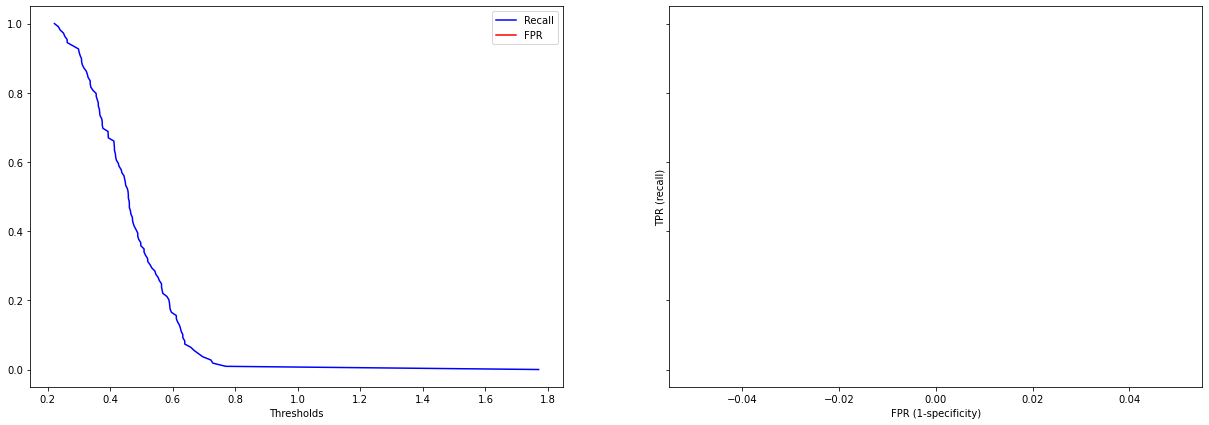

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.588954  0.556465   0.595068     0.621414  0.575082  0.630542
Validation  0.594812  0.557857   0.600205     0.632110  0.576388  0.637566

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.557796  0.520500   0.562085     0.595413   
Random Forest (100 estimators)  0.581568  0.558766   0.584701     0.604587   
XGBoost Classifier              0.545941  0.528707   0.547682     0.563303   
SVM                             0.577448  0.542369   0.582737     0.612844   
KNN                             0.540426  0.550500   0.541865     0.530275   
Logistic Regression             0.594812  0.557857   0.600205     0.632110   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.538891  0.589927  
Random Forest (100 estimators)  0.568741  0.625597  
XGBoost Classifier              0.537307  0.579816  
SVM                             0.559929  0.615994  
KNN                             0.544984  0.565372  
Logistic Regression             0.576388  0.637566

In [22]:
#All vitals without normalization or standardization
run_models(vitals, y[vitals.index], models, ratio_negatives_to_positives=1)

<b>Rr</b>, <b>pulse</b> and <b>temperature</b> seem to be the most dominant features in the experiments. <b>Random Forest</b> seems to be the best performing model here.

Dummy Random
╠■■■■■■■■■╣


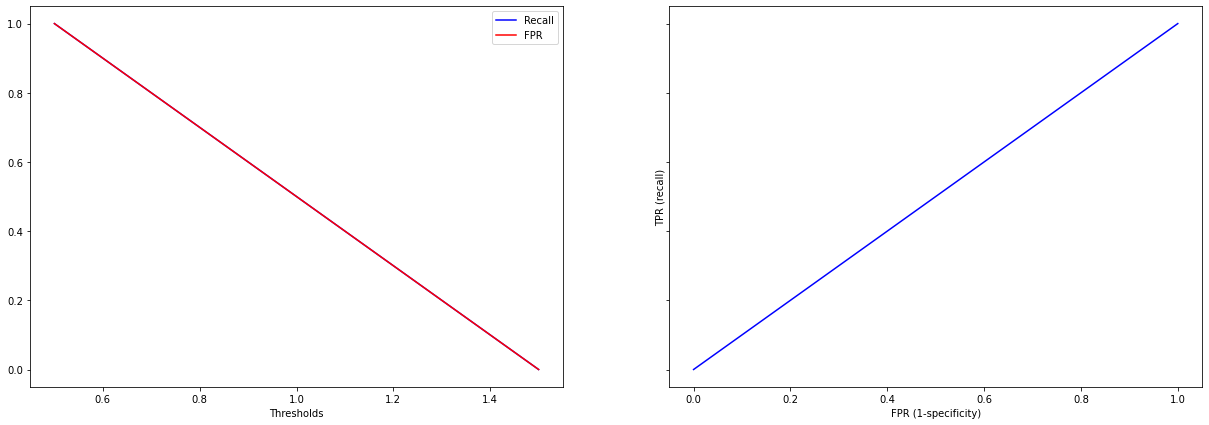

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


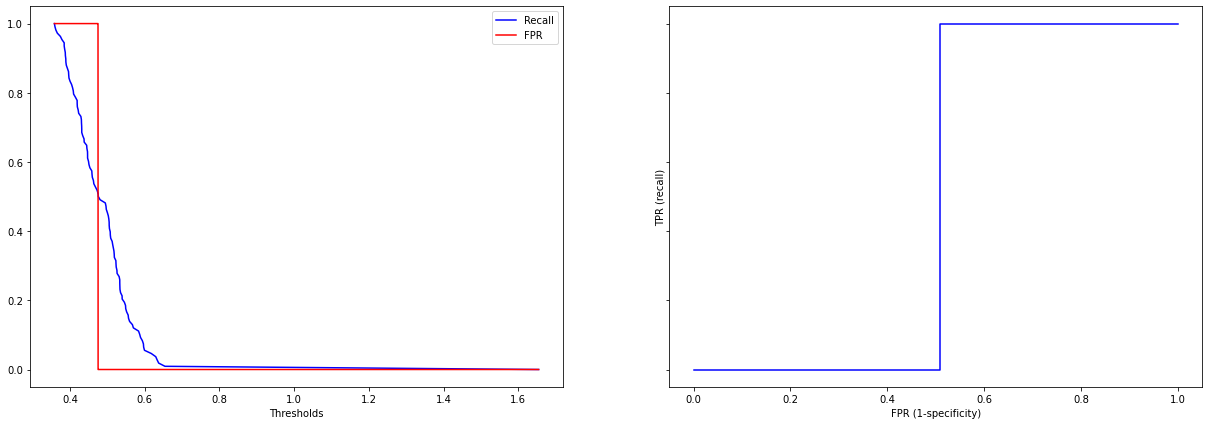

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.611188  0.563138   0.623202     0.659192  0.591315  0.660055
Validation  0.571974  0.535121   0.575857     0.609174  0.551736  0.614506


XGBoost Classifier
╠■■■■■■■■■╣


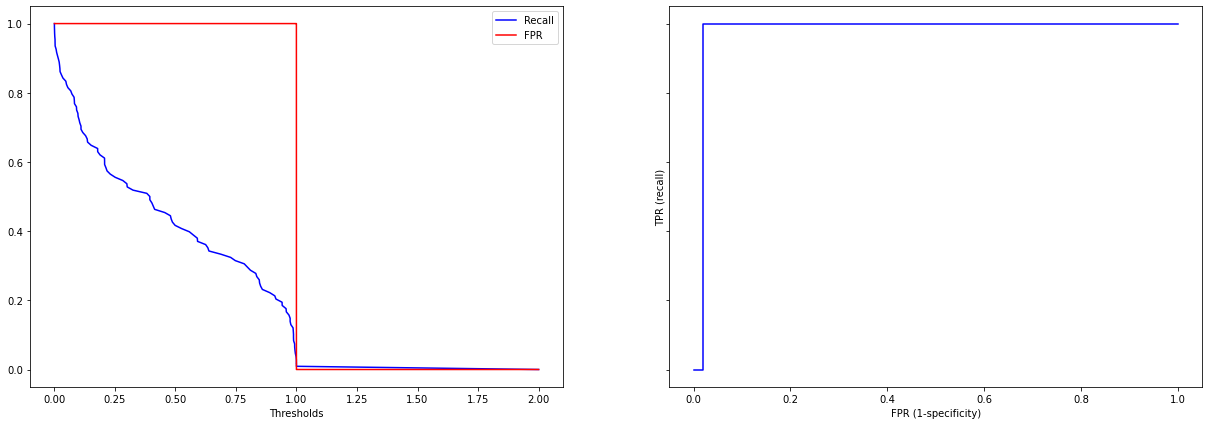

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.997474  0.997473   0.997474     0.997475  0.997472  0.999981
Validation  0.546816  0.535930   0.549399     0.557798  0.541898  0.571285


SVM
╠■■■■■■■■■╣


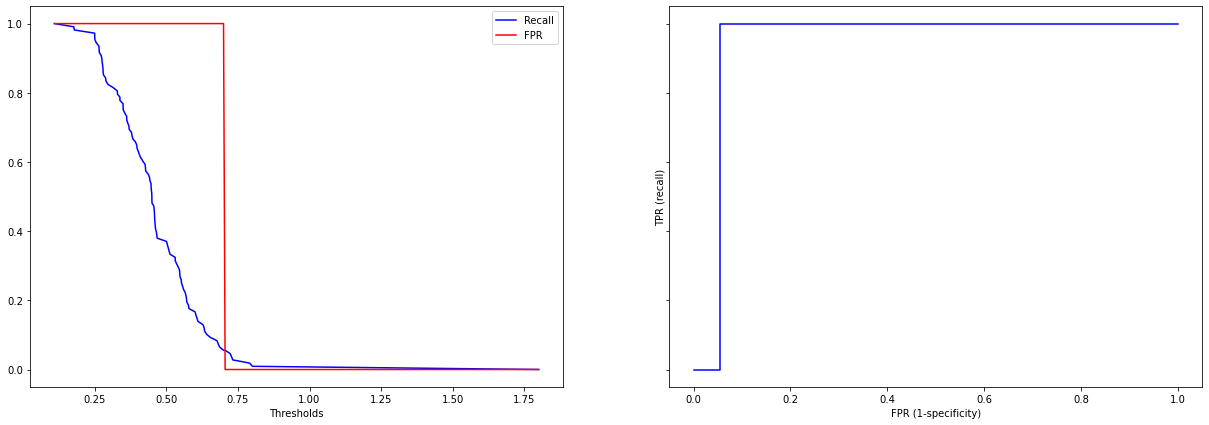

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training     0.59229  0.538066   0.603151     0.646465  0.568701  0.635657
Validation   0.58614  0.527857   0.594175     0.644954  0.557583  0.630545


KNN
╠■■■■■■■■■╣


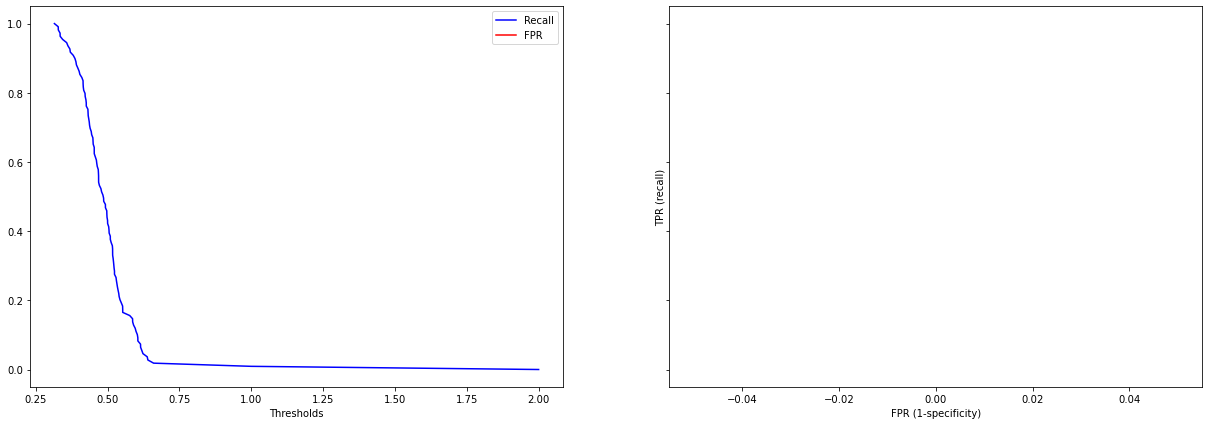

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998484  0.997270   0.999696     0.999697  0.998481  0.999995
Validation  0.575606  0.495071   0.588603     0.656881  0.535157  0.619007


Logistic Regression
╠■■■■■■■■■╣


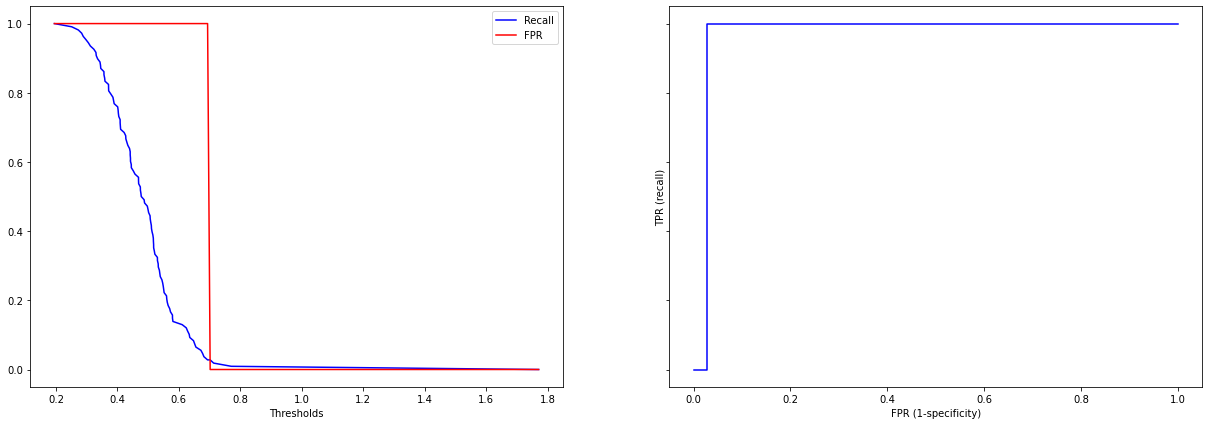

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.593755  0.561724   0.600021     0.625758  0.580204  0.637720
Validation  0.578819  0.546038   0.581240     0.611927  0.560858  0.629912

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.571974  0.535121   0.575857     0.609174   
XGBoost Classifier              0.546816  0.535930   0.549399     0.557798   
SVM                             0.586140  0.527857   0.594175     0.644954   
KNN                             0.575606  0.495071   0.588603     0.656881   
Logistic Regression             0.578819  0.546038   0.581240     0.611927   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.551736  0.614506  
XGBoost Classifier              0.541898  0.571285  
SVM                             0.557583  0.630545  
KNN                             0.535157  0.619007  
Logistic Regression             0.560858  0.629912

In [45]:
run_models(s_vitals, y[s_vitals.index], models, ratio_negatives_to_positives=1)

<b>Pulse</b>, <b>temperature</b> and <b>rr</b> seem to be again the dominant features with standardized values. It improved the performance of <b>SVM</b>, <b>KNN</b> and <b>Logistic Regression<b>

Dummy Random
╠■■■■■■■■■╣


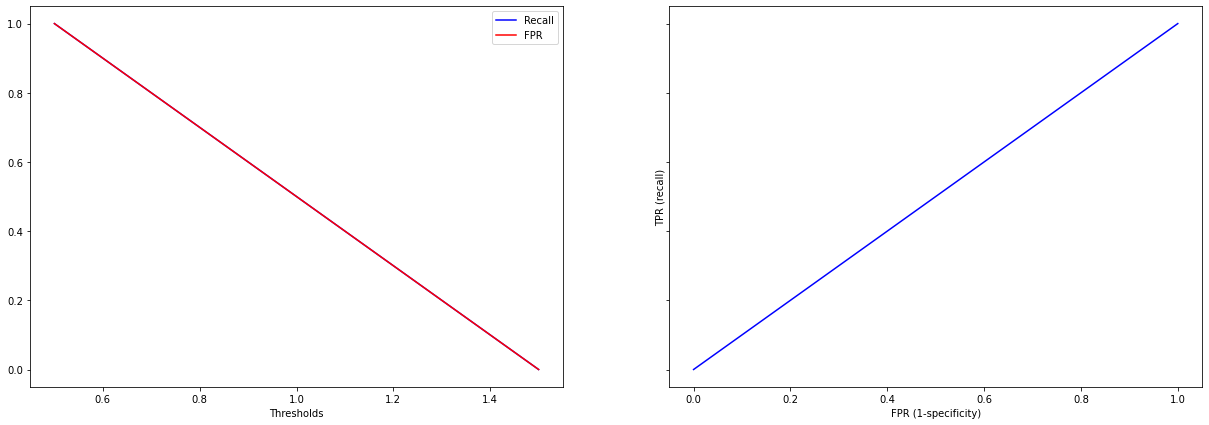

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


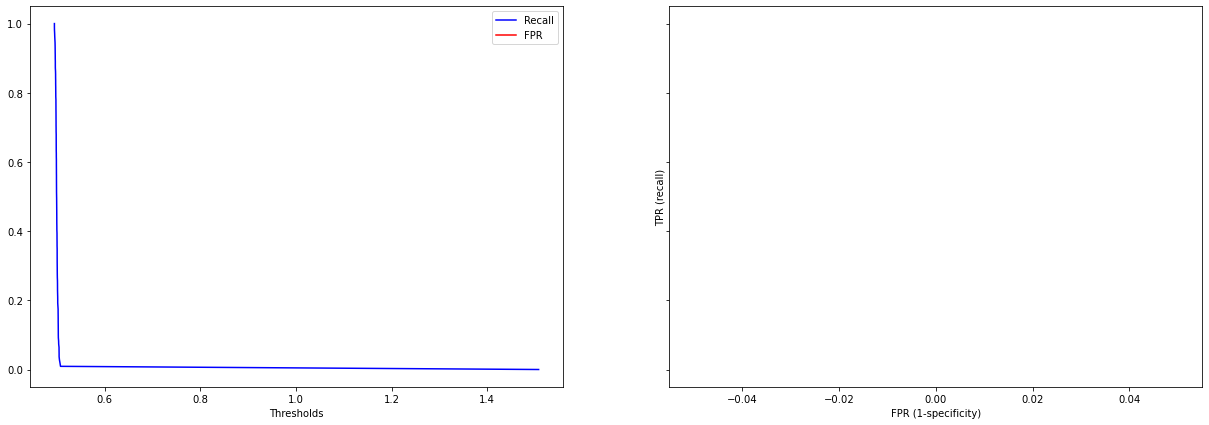

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.574756  0.540694   0.580027     0.608788  0.559647  0.607930
Validation  0.570142  0.529616   0.577707     0.611009  0.550393  0.599708


Random Forest (100 estimators)
╠■■■■■■■■■╣


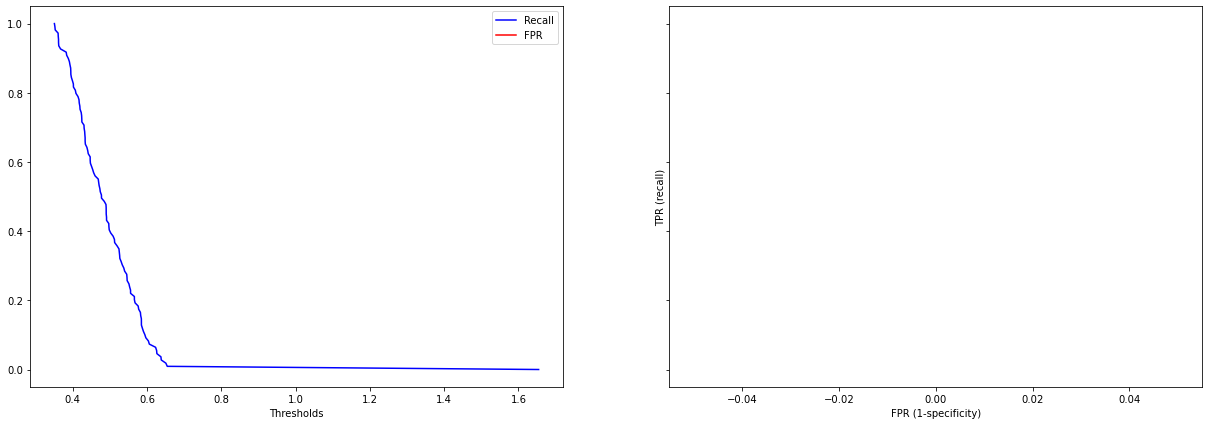

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.613663  0.574565   0.623906     0.652727  0.597239  0.665004
Validation  0.569675  0.549608   0.570690     0.589908  0.557767  0.608195


XGBoost Classifier
╠■■■■■■■■■╣


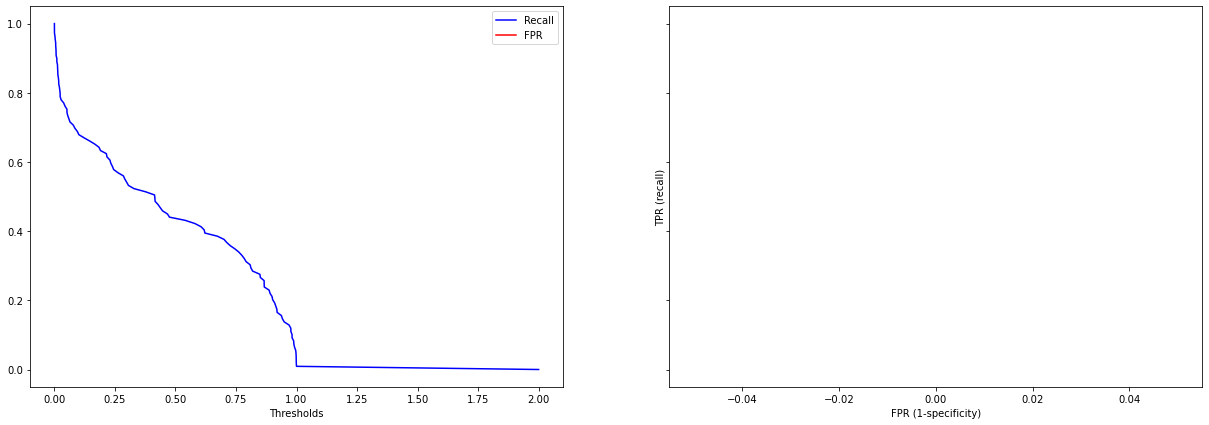

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.997827  0.997573   0.998079     0.998081  0.997826  0.999982
Validation  0.546814  0.552302   0.547627     0.541284  0.548678  0.568879


SVM
╠■■■■■■■■■╣


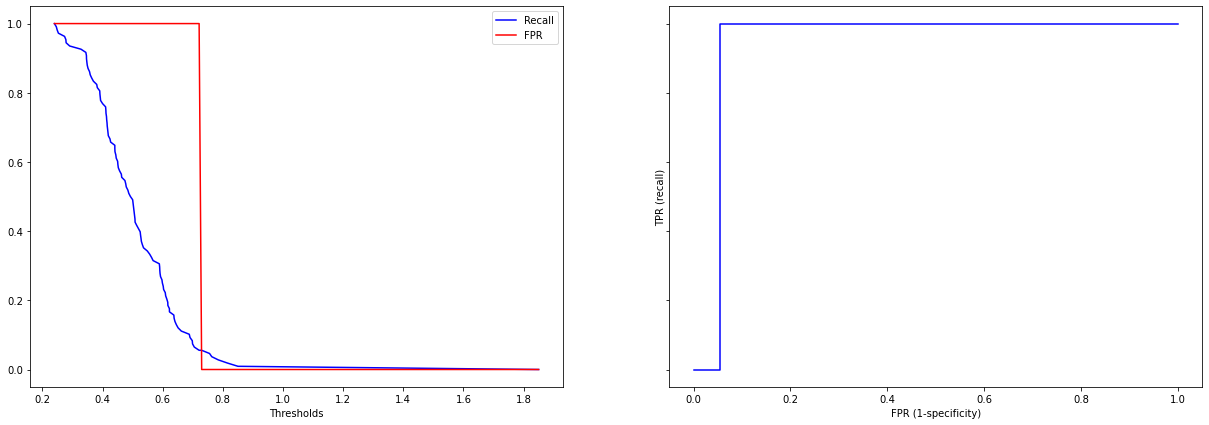

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.589712  0.534122   0.600677     0.645253  0.565439  0.635735
Validation  0.582479  0.521460   0.592832     0.644037  0.550876  0.635991


KNN
╠■■■■■■■■■╣


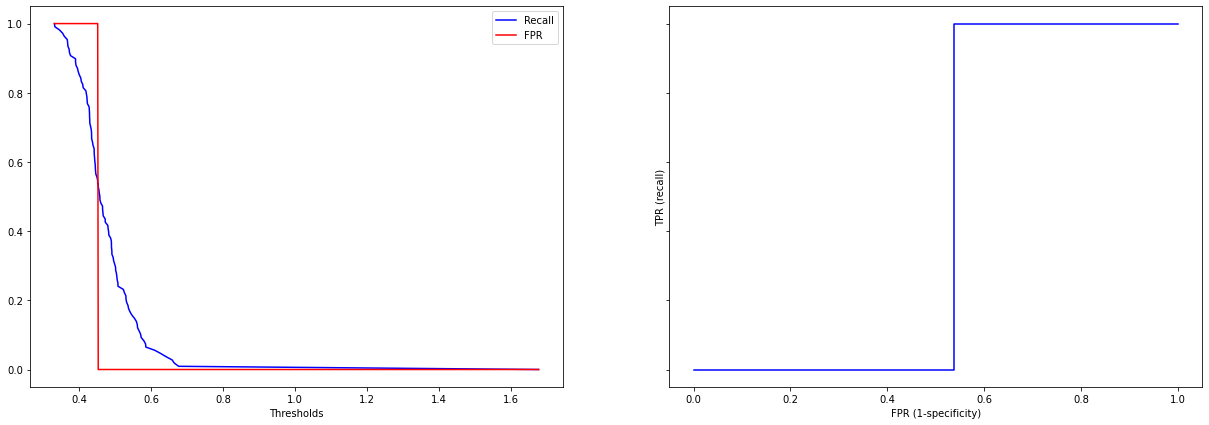

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998434  0.997068   0.999797     0.999798  0.998430  0.999994
Validation  0.584728  0.514112   0.600823     0.655963  0.552609  0.621770


Logistic Regression
╠■■■■■■■■■╣


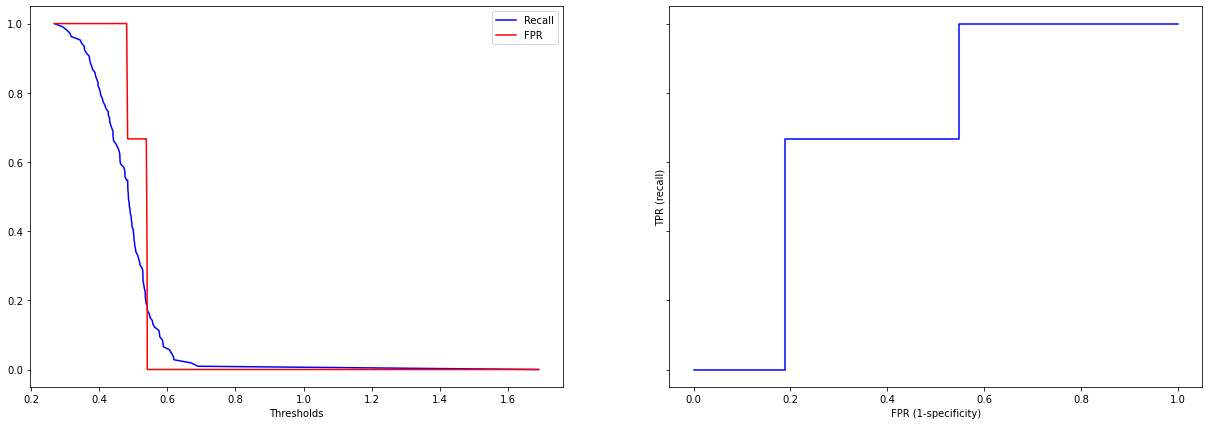

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.590723  0.555555   0.597506     0.625859  0.575729  0.636935
Validation  0.583373  0.547848   0.588997     0.619266  0.564944  0.621440

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.570142  0.529616   0.577707     0.611009   
Random Forest (100 estimators)  0.569675  0.549608   0.570690     0.589908   
XGBoost Classifier              0.546814  0.552302   0.547627     0.541284   
SVM                             0.582479  0.521460   0.592832     0.644037   
KNN                             0.584728  0.514112   0.600823     0.655963   
Logistic Regression             0.583373  0.547848   0.588997     0.619266   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.550393  0.599708  
Random Forest (100 estimators)  0.557767  0.608195  
XGBoost Classifier              0.548678  0.568879  
SVM                             0.550876  0.635991  
KNN                             0.552609  0.621770  
Logistic Regression             0.564944  0.621440

In [24]:
run_models(n_vitals, y[n_vitals.index], models, ratio_negatives_to_positives=1)

<b>Temperature</b>, <b>pulse</b> and <b>rr</b> are still the best features. <b>SVM</b> and <b>Logistic regression</b> improve significantly with standardized features.

Dummy Random
╠■■■■■■■■■╣


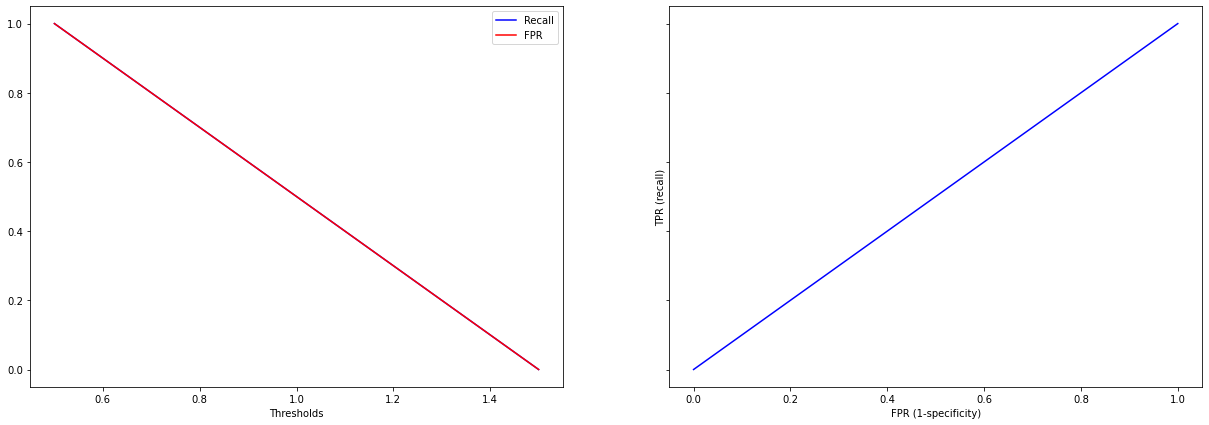

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


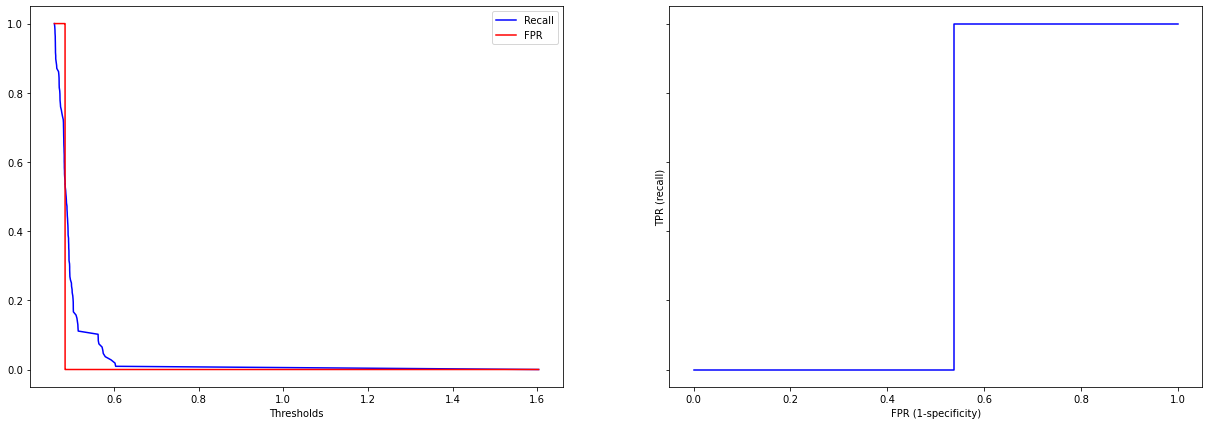

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.556667  0.495826   0.570752     0.617475  0.519860  0.586257
Validation  0.553205  0.473812   0.565537     0.633028  0.503722  0.588396


Random Forest (100 estimators)
╠■■■■■■■■■╣


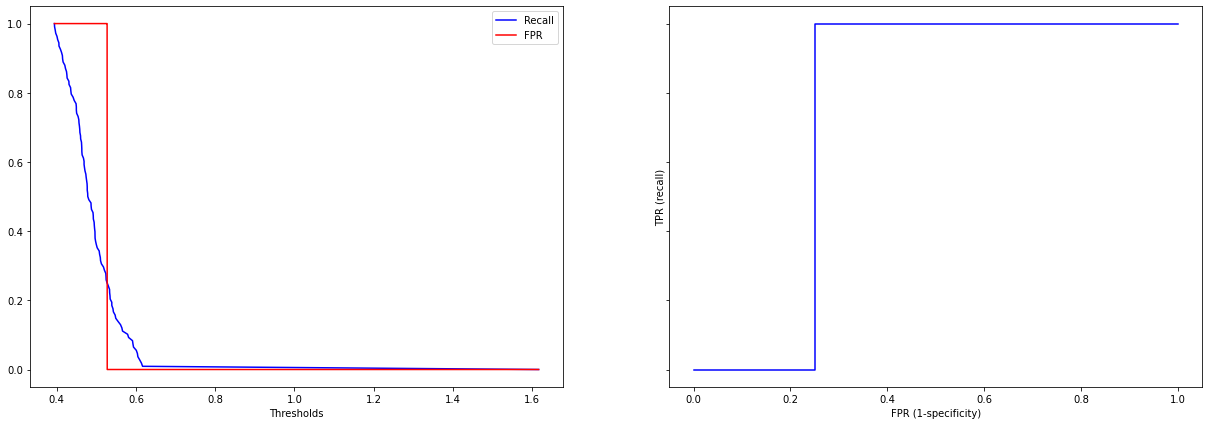

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.621748  0.593070   0.628967     0.650404  0.610178  0.675457
Validation  0.596165  0.565947   0.605132     0.626606  0.581120  0.637571


XGBoost Classifier
╠■■■■■■■■■╣


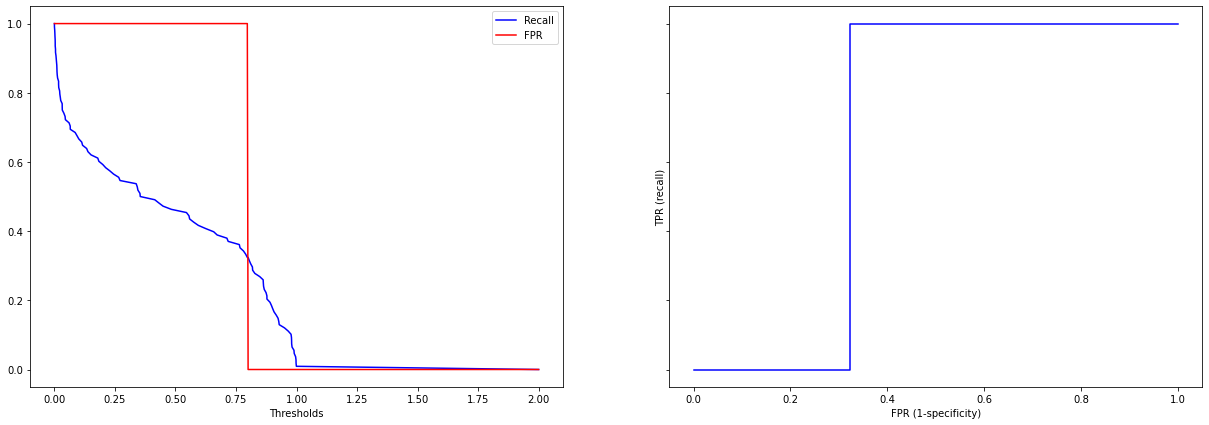

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999848  0.999798   0.999899     0.999899  0.999848  1.000000
Validation  0.560992  0.555922   0.563768     0.566055  0.558459  0.583324


SVM
╠■■■■■■■■■╣


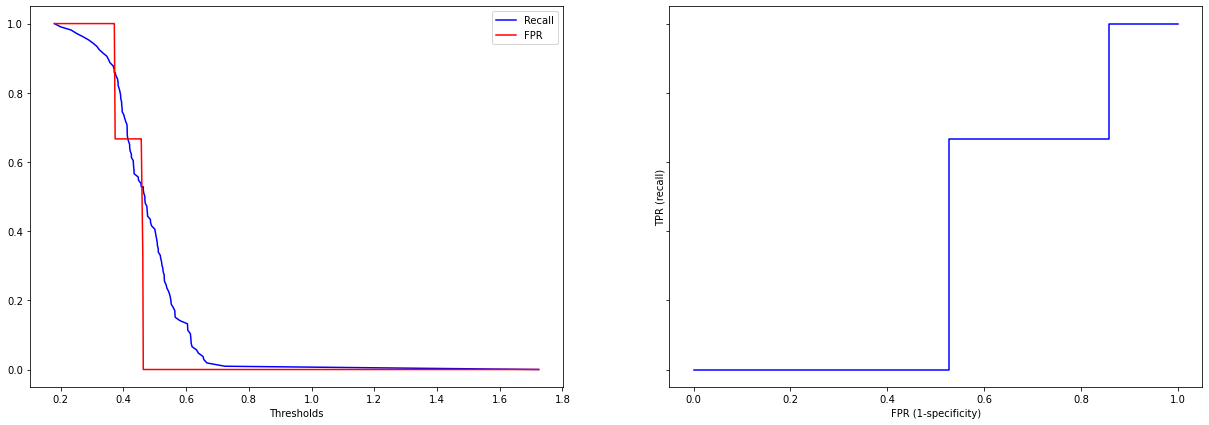

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.599869  0.554041   0.609747     0.645657  0.580537  0.648202
Validation  0.604855  0.544178   0.617324     0.666055  0.575733  0.652659


KNN
╠■■■■■■■■■╣


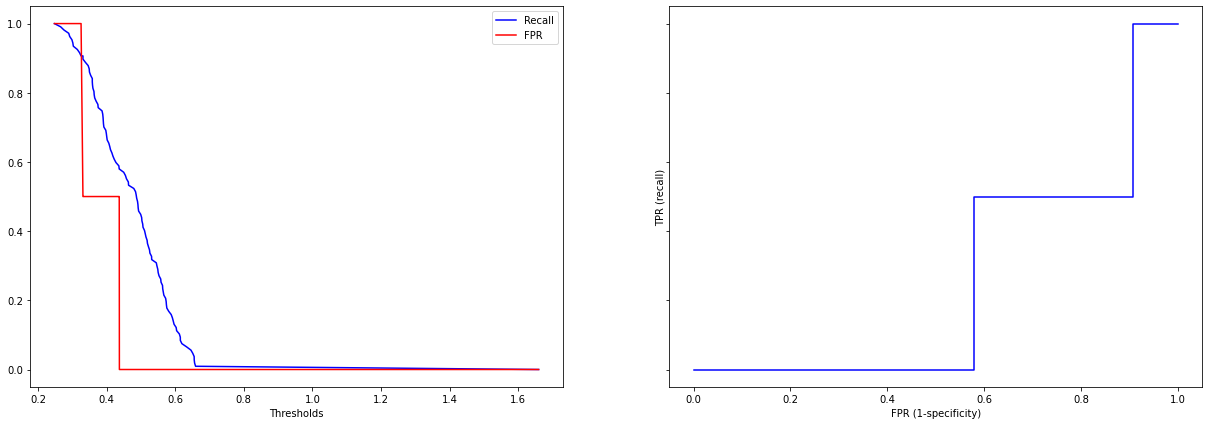

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999697  0.999393   1.000000     1.000000  0.999697  1.000000
Validation  0.584718  0.539525   0.595565     0.630275  0.564351  0.614081


Logistic Regression
╠■■■■■■■■■╣


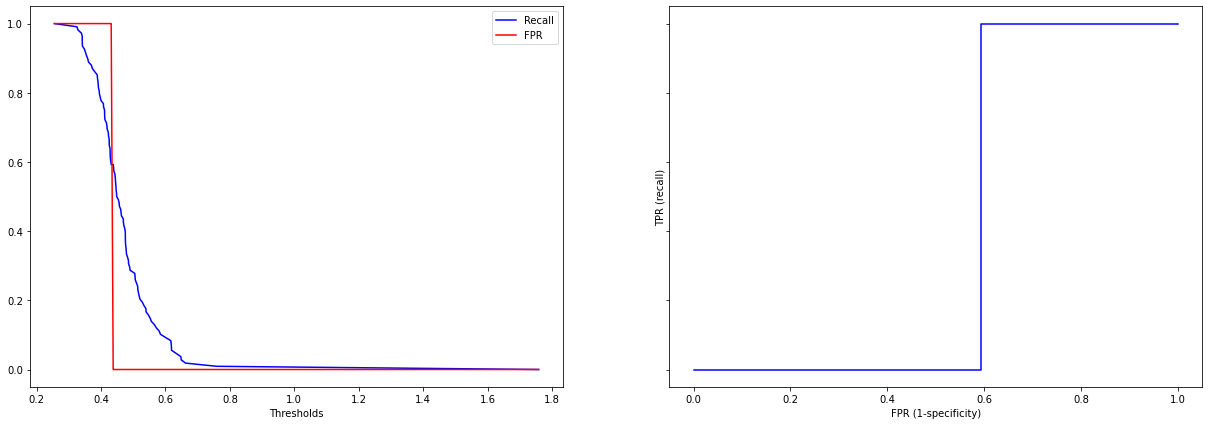

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.603456  0.574057   0.609860     0.632828  0.591377  0.653891
Validation  0.592043  0.566013   0.598294     0.618349  0.578526  0.643711

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.553205  0.473812   0.565537     0.633028   
Random Forest (100 estimators)  0.596165  0.565947   0.605132     0.626606   
XGBoost Classifier              0.560992  0.555922   0.563768     0.566055   
SVM                             0.604855  0.544178   0.617324     0.666055   
KNN                             0.584718  0.539525   0.595565     0.630275   
Logistic Regression             0.592043  0.566013   0.598294     0.618349   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.503722  0.588396  
Random Forest (100 estimators)  0.581120  0.637571  
XGBoost Classifier              0.558459  0.583324  
SVM                             0.575733  0.652659  
KNN                             0.564351  0.614081  
Logistic Regression             0.578526  0.643711

In [25]:
n_vitals_ex = pd.merge(n_vitals, e_factors, left_index=True, right_index=True)
run_models(n_vitals_ex, y[n_vitals_ex.index], models, ratio_negatives_to_positives=1)

For almost all models, the vitals had more importance than all of the epidemiological factors, of which <b>high_risk_exposure_occupation</b> seems to be the most influential again. For tree-based models (<b>Random forest</b> and <b>XGBoost</b>) however, <b>age</b> played a significant role. Since all of the important vitals follow a normal distribution, <b>standardization</b> will be used for them.

### Assesed Symptoms

In [45]:
a_symptoms.dropna(how="all", inplace=True)
a_symptoms_ef = pd.merge(a_symptoms, e_factors, left_index=True, right_index=True)

Dummy Random
╠■■■■■■■■■╣


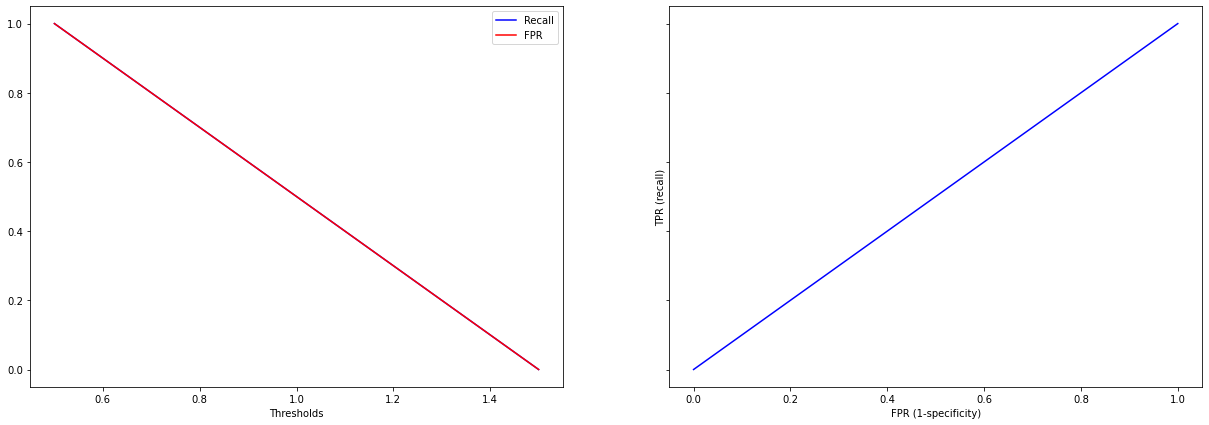

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500070     0.0        0.0          1.0  0.0      0.5
Validation  0.499372     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


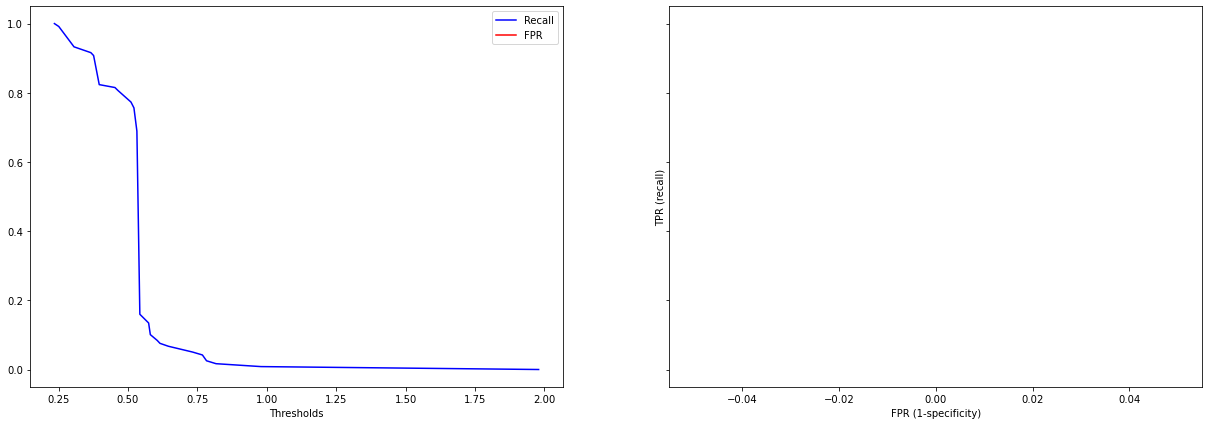

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.545885  0.848001   0.528590     0.243855  0.651228  0.551260
Validation  0.549696  0.848985   0.531023     0.249580  0.653181  0.562513


Random Forest (100 estimators)
╠■■■■■■■■■╣


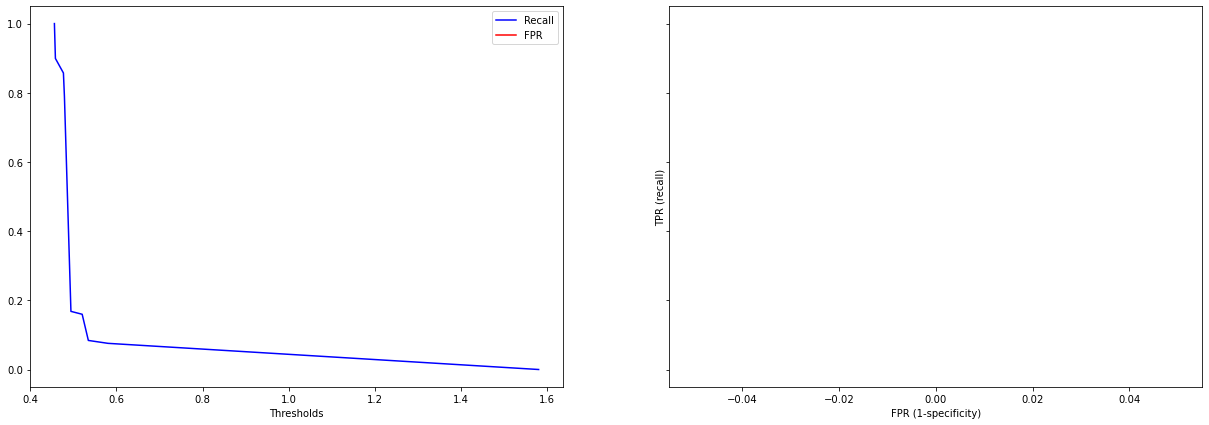

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.589095  0.394059   0.646199     0.784078  0.489499  0.613688
Validation  0.591268  0.389769   0.651384     0.793277  0.485801  0.605745


XGBoost Classifier
╠■■■■■■■■■╣


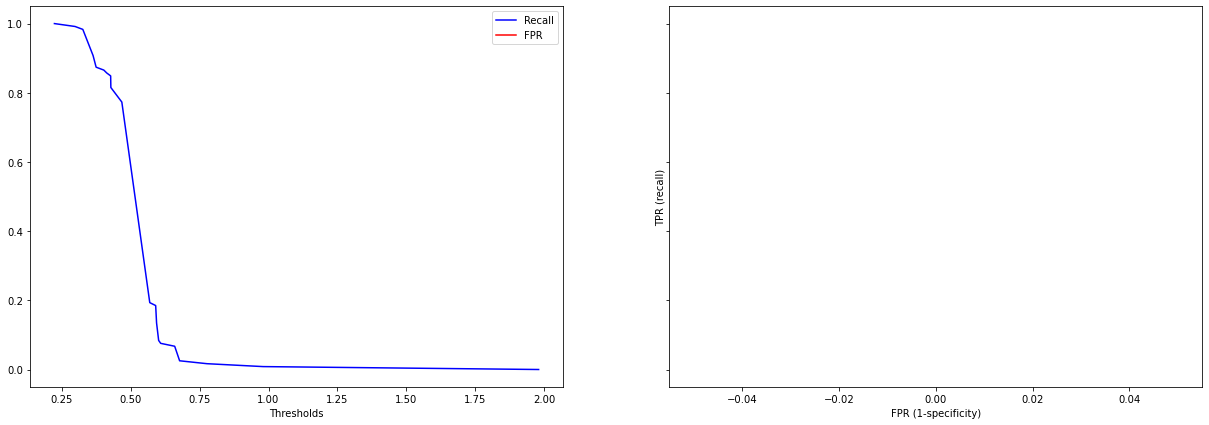

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.603064  0.406634   0.670400     0.799441  0.505874  0.639086
Validation  0.575780  0.377269   0.626348     0.774790  0.469940  0.596670


SVM
╠■■■■■■■■■╣


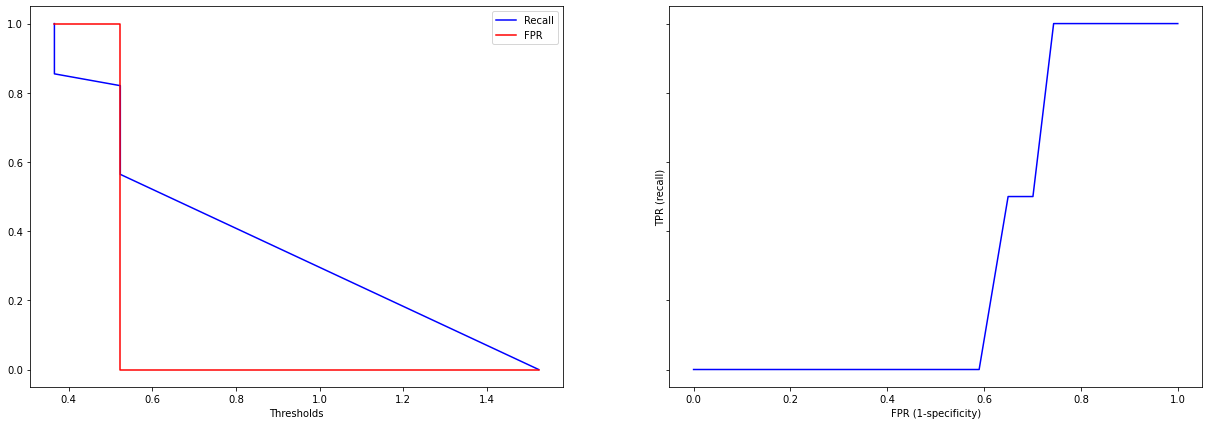

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.532524  0.781798   0.513783     0.283333  0.600674  0.529512
Validation  0.516947  0.761730   0.491120     0.271429  0.584668  0.522980


KNN
╠■■■■■■■■■╣


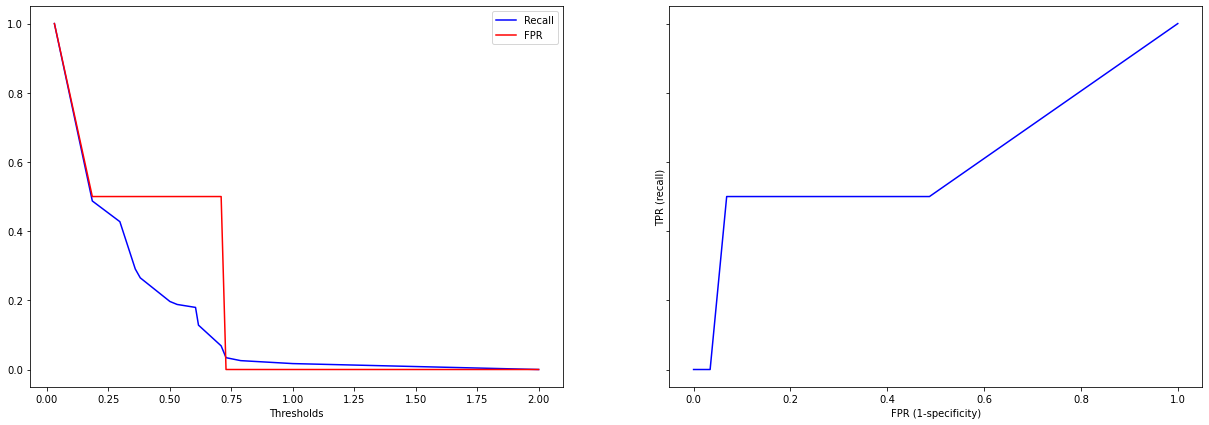

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.603716  0.391546   0.680503     0.815829  0.496577  0.595696
Validation  0.585806  0.368873   0.655491     0.803361  0.469919  0.574625


Logistic Regression
╠■■■■■■■■■╣


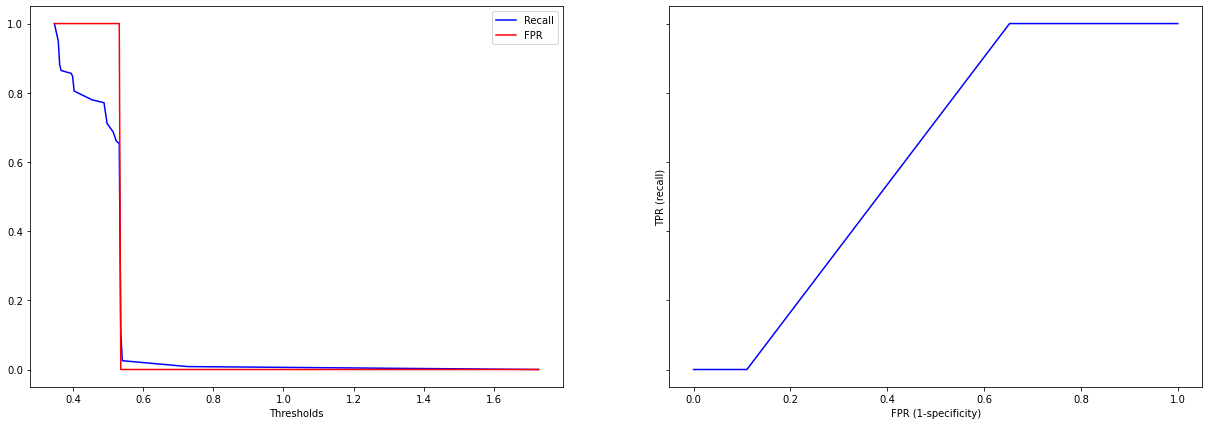

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.543883  0.830493   0.527932     0.257356  0.645438  0.541914
Validation  0.549283  0.828088   0.532150     0.269748  0.647804  0.544058

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499372  0.000000   0.000000     1.000000   
MultinomialNB                   0.549696  0.848985   0.531023     0.249580   
Random Forest (100 estimators)  0.591268  0.389769   0.651384     0.793277   
XGBoost Classifier              0.575780  0.377269   0.626348     0.774790   
SVM                             0.516947  0.761730   0.491120     0.271429   
KNN                             0.585806  0.368873   0.655491     0.803361   
Logistic Regression             0.549283  0.828088   0.532150     0.269748   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.653181  0.562513  
Random Forest (100 estimators)  0.485801  0.605745  
XGBoost Classifier              0.469940  0.596670  
SVM                             0.584668  0.522980  
KNN                             0.469919  0.574625  
Logistic Regression             0.647804  0.544058

In [27]:
run_models(a_symptoms, y[a_symptoms.index], models, ratio_negatives_to_positives=1)

The most important features here seem to be <b>wheezes</b>, <b>ctab</b> and <b>labored respiration</b>

Dummy Random
╠■■■■■■■■■╣


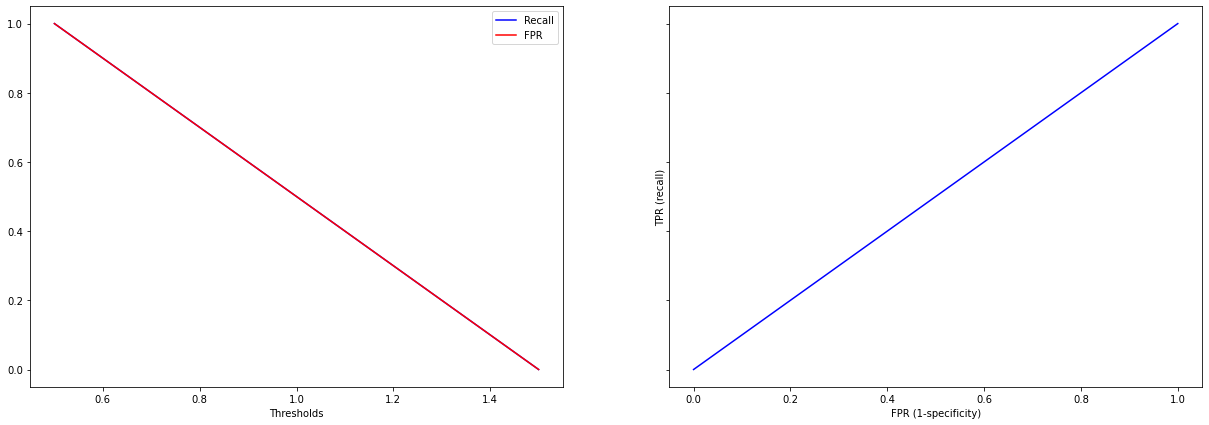

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500070     0.0        0.0          1.0  0.0      0.5
Validation  0.499372     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


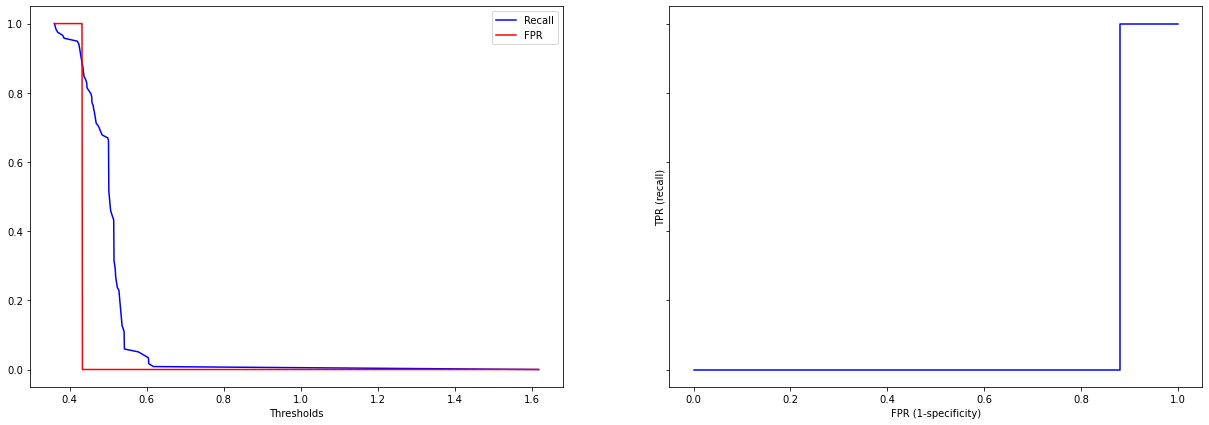

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.555525  0.768190   0.538968     0.342924  0.632530  0.568600
Validation  0.537919  0.747451   0.525971     0.327731  0.616293  0.545637


Random Forest (100 estimators)
╠■■■■■■■■■╣


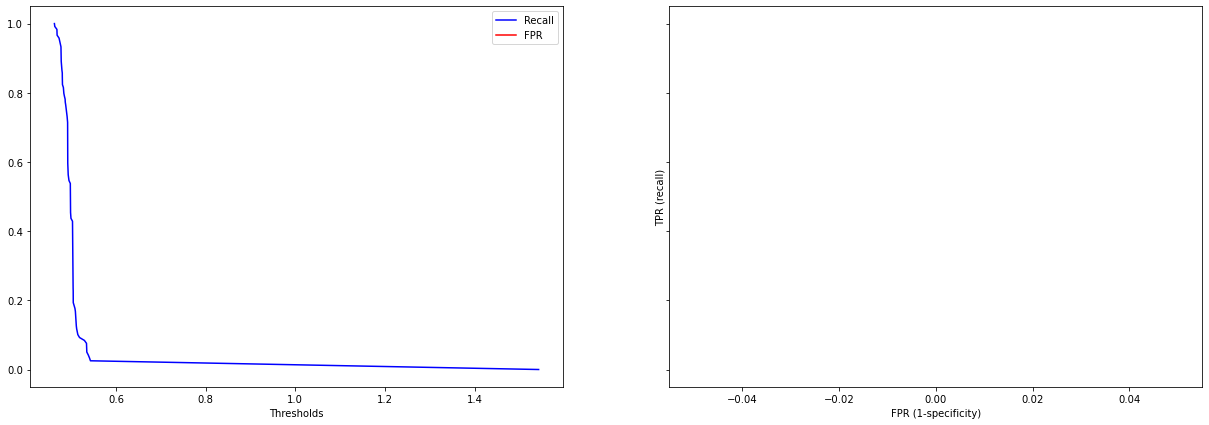

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.592680  0.548765   0.603494     0.636592  0.572107  0.631673
Validation  0.577436  0.523704   0.590887     0.631092  0.549928  0.615672


XGBoost Classifier
╠■■■■■■■■■╣


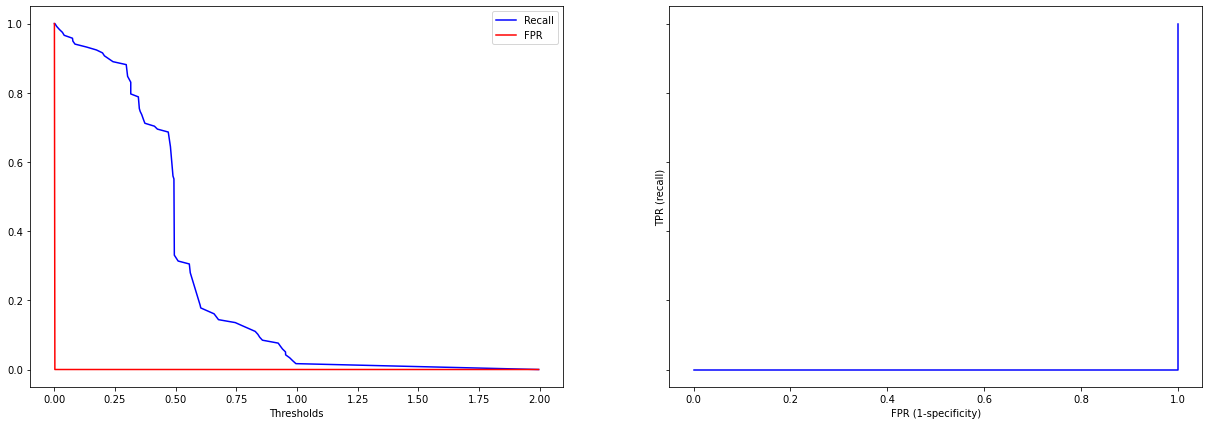

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.643990  0.585846   0.673114     0.702142  0.618151  0.721128
Validation  0.572381  0.501856   0.588007     0.642857  0.535168  0.592328


SVM
╠■■■■■■■■■╣


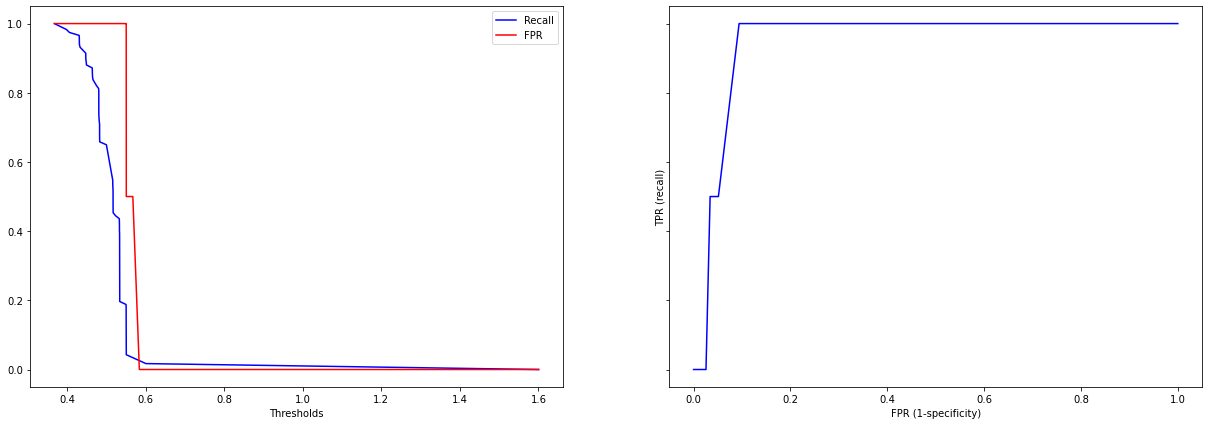

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.546074  0.627845   0.550714     0.464339  0.544003  0.570592
Validation  0.534181  0.601716   0.547548     0.466387  0.522554  0.556846


KNN
╠■■■■■■■■■╣


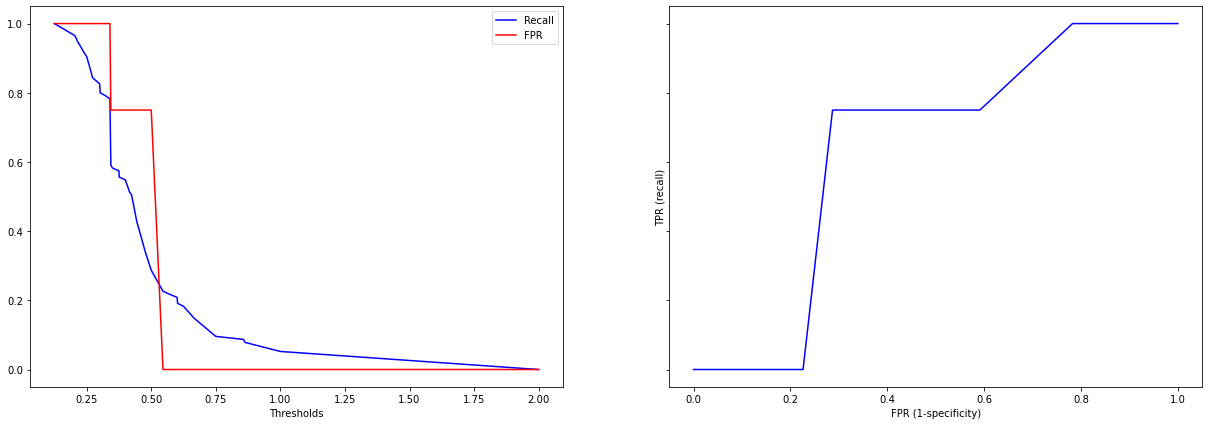

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.641477  0.442579   0.735568     0.840317  0.552301  0.678634
Validation  0.573637  0.361296   0.630911     0.786555  0.457122  0.576665


Logistic Regression
╠■■■■■■■■■╣


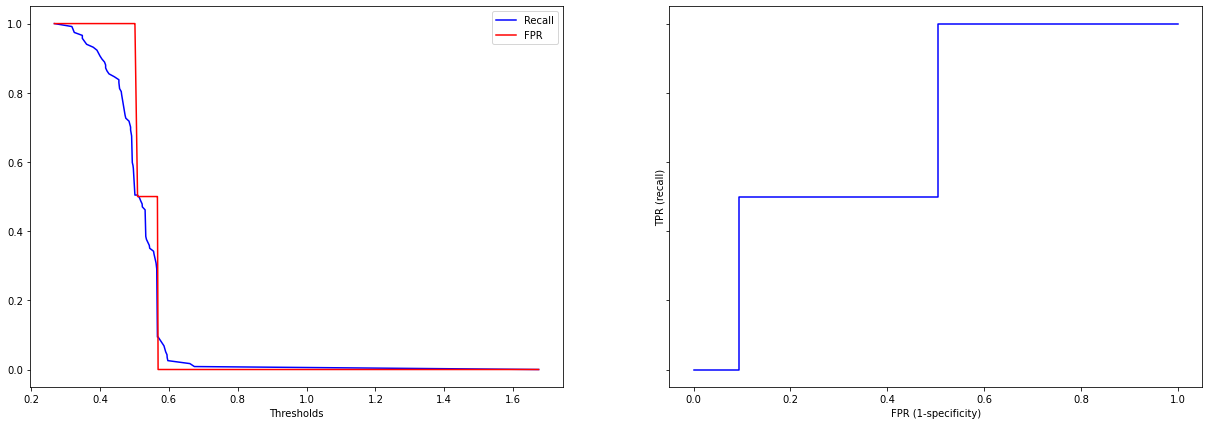

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.565395  0.712212   0.550577     0.418622  0.619707  0.584611
Validation  0.555997  0.687248   0.545219     0.424370  0.606839  0.573867

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499372  0.000000   0.000000     1.000000   
MultinomialNB                   0.537919  0.747451   0.525971     0.327731   
Random Forest (100 estimators)  0.577436  0.523704   0.590887     0.631092   
XGBoost Classifier              0.572381  0.501856   0.588007     0.642857   
SVM                             0.534181  0.601716   0.547548     0.466387   
KNN                             0.573637  0.361296   0.630911     0.786555   
Logistic Regression             0.555997  0.687248   0.545219     0.424370   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.616293  0.545637  
Random Forest (100 estimators)  0.549928  0.615672  
XGBoost Classifier              0.535168  0.592328  
SVM                             0.522554  0.556846  
KNN                             0.457122  0.576665  
Logistic Regression             0.606839  0.573867

In [28]:
run_models(a_symptoms_ef, y[a_symptoms_ef.index], models, ratio_negatives_to_positives=1)

Adding the epidemiological factors doesn't seem to make much difference in performance metrics. However, <b>days_since_symptom_onset</b> appears to become more important after adding the factors.

### Reported symptoms

In [29]:
r_symptoms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51695 entries, 0 to 93994
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cough           51684 non-null  object 
 1   cough_severity  51684 non-null  float64
 2   fever           48445 non-null  object 
 3   sob             51602 non-null  object 
 4   sob_severity    51602 non-null  float64
 5   diarrhea        51619 non-null  object 
 6   fatigue         51630 non-null  object 
 7   headache        51623 non-null  object 
 8   loss_of_smell   51616 non-null  object 
 9   loss_of_taste   51616 non-null  object 
 10  runny_nose      51619 non-null  object 
 11  muscle_sore     51624 non-null  object 
 12  sore_throat     51623 non-null  object 
dtypes: float64(2), object(11)
memory usage: 7.5+ MB


In [46]:
#All datasets that contain reported symptoms
r_symptoms.dropna(how="all", inplace=True)
ra_symptoms = pd.merge(r_symptoms, a_symptoms, left_index=True, right_index=True)
r_symptoms_ex = pd.merge(r_symptoms, e_factors, left_index=True, right_index=True)
r_symptoms_vitals = pd.merge(r_symptoms, vitals, left_index=True, right_index=True)
r_symptoms_svitals = pd.merge(r_symptoms, s_vitals, left_index=True, right_index=True)
ra_symptoms_vitals = pd.merge(ra_symptoms, vitals, left_index=True, right_index=True)
ra_symptoms_nvitals = pd.merge(ra_symptoms, n_vitals, left_index=True, right_index=True)
ra_symptoms_svitals = pd.merge(ra_symptoms, s_vitals, left_index=True, right_index=True)
ra_symptoms_vitals_ex = pd.merge(ra_symptoms_vitals, e_factors, left_index=True, right_index=True)
ra_symptoms_nvitals_ex = pd.merge(ra_symptoms_svitals, e_factors, left_index=True, right_index=True)
ra_symptoms_svitals_ex = pd.merge(ra_symptoms_svitals, e_factors, left_index=True, right_index=True)

Dummy Random
╠■■■■■■■■■╣


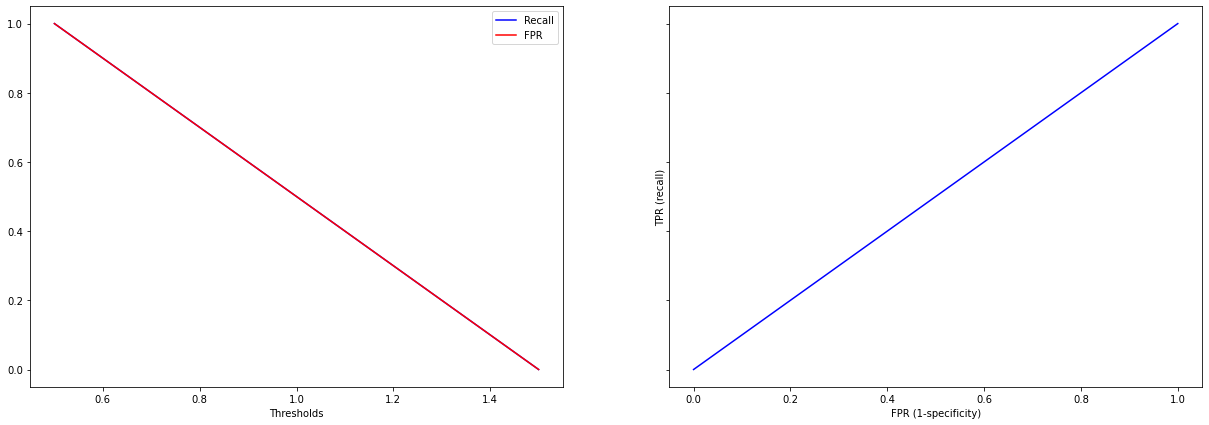

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


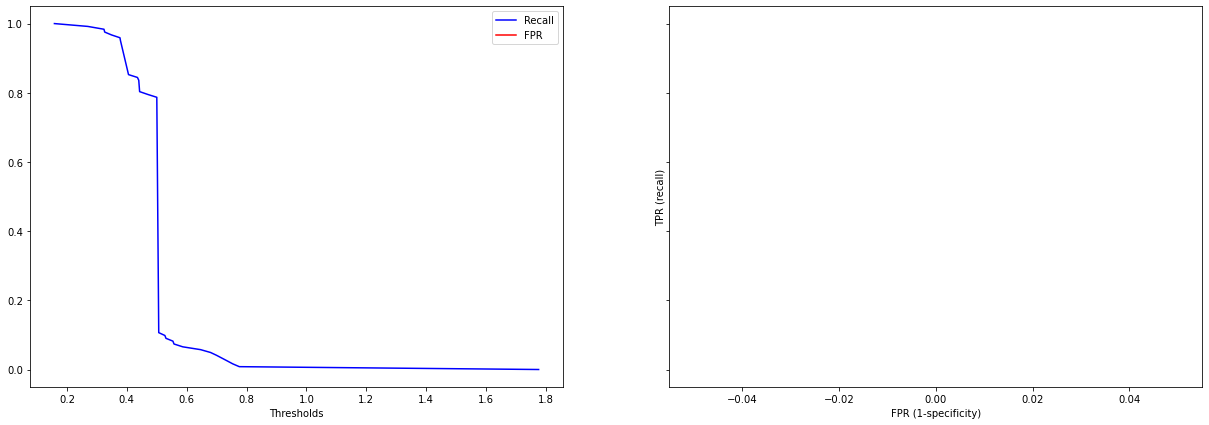

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.631147  0.367427   0.777602     0.894818  0.498893  0.615184
Validation  0.637563  0.374737   0.790845     0.900820  0.505249  0.620037


Random Forest (100 estimators)
╠■■■■■■■■■╣


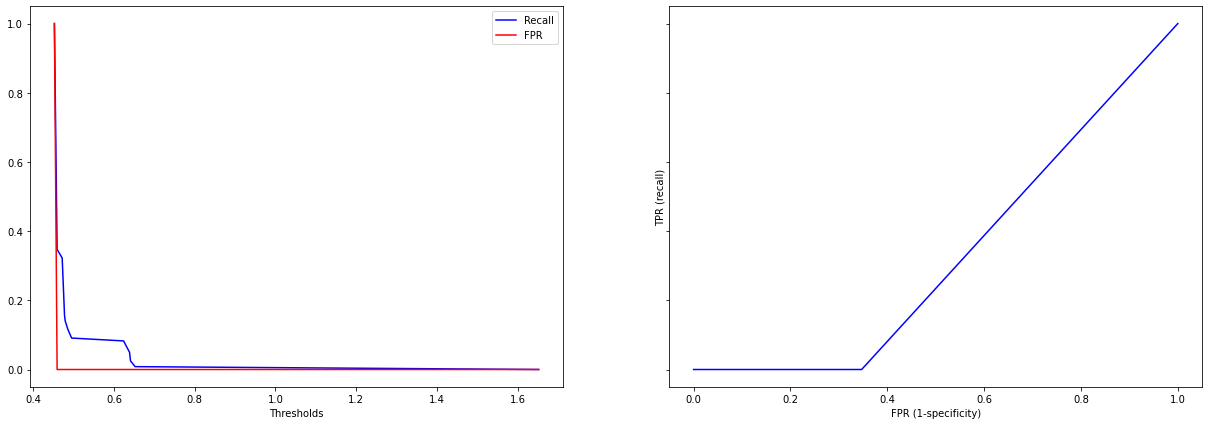

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.631375  0.426075   0.723115     0.836636  0.535995  0.664859
Validation  0.627745  0.417273   0.714046     0.838525  0.523481  0.667289


XGBoost Classifier
╠■■■■■■■■■╣


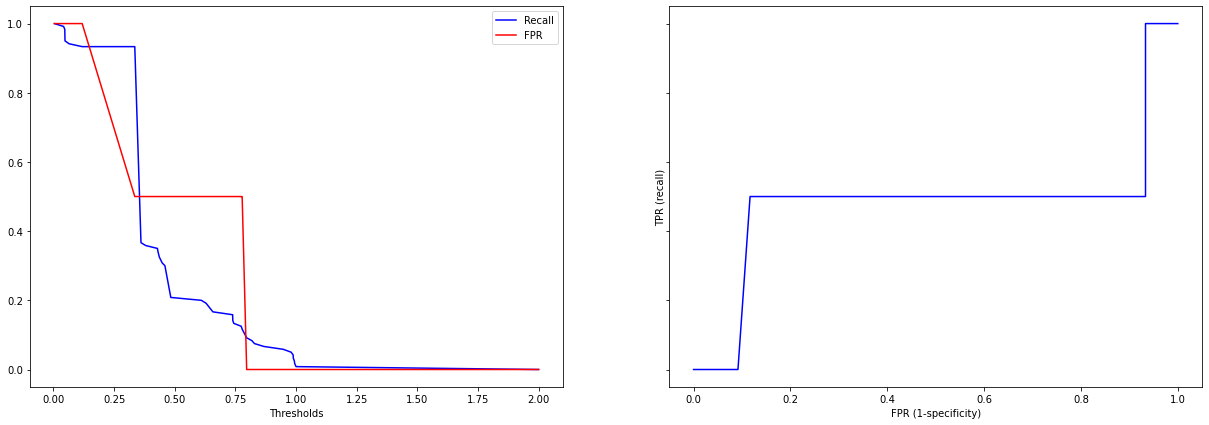

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.707291  0.511182   0.841257     0.903364  0.635691  0.756488
Validation  0.637568  0.449167   0.719976     0.826230  0.550738  0.644803


SVM
╠■■■■■■■■■╣


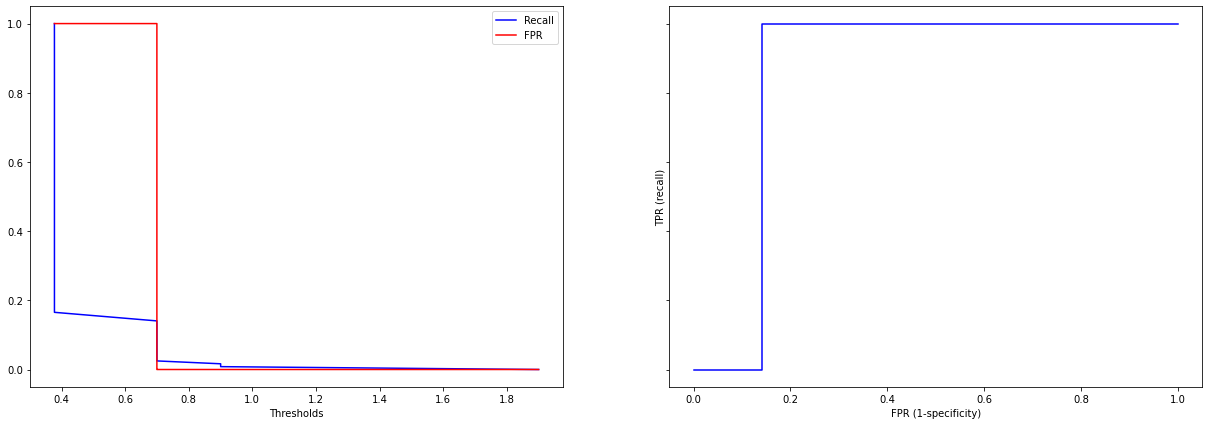

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.655923  0.457812   0.758801     0.854000  0.570437  0.683192
Validation  0.649045  0.456524   0.741230     0.841803  0.559919  0.666032


KNN
╠■■■■■■■■■╣


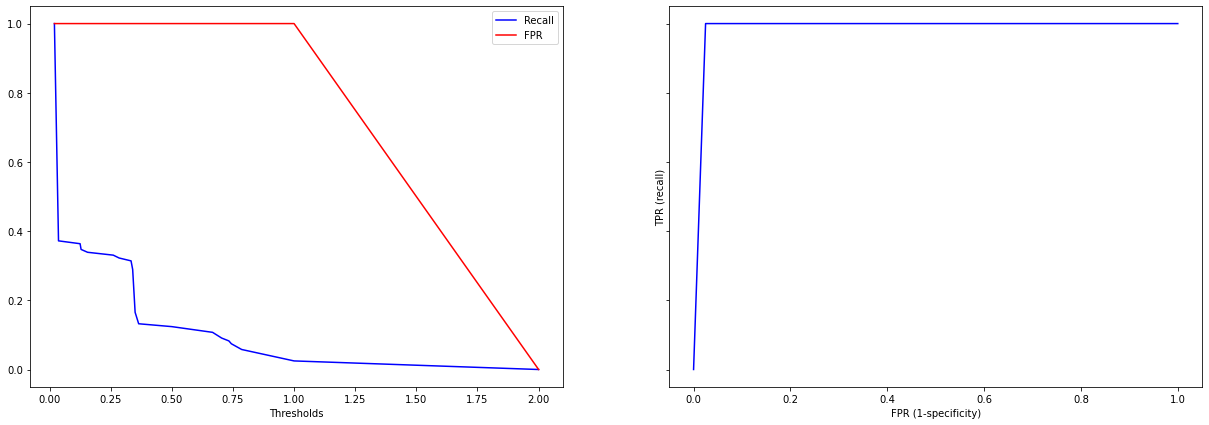

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.703519  0.487088   0.859101     0.919909  0.621469  0.737422
Validation  0.638781  0.427043   0.735862     0.850820  0.537775  0.654855


Logistic Regression
╠■■■■■■■■■╣


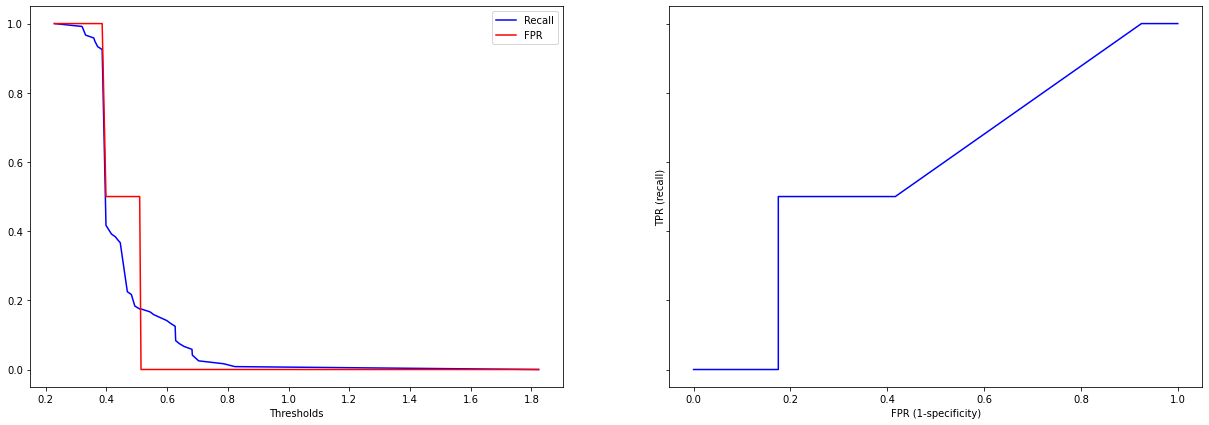

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.658787  0.491824   0.741137     0.825727  0.590133  0.689026
Validation  0.655602  0.471271   0.747444     0.840164  0.573118  0.686585

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.637563  0.374737   0.790845     0.900820   
Random Forest (100 estimators)  0.627745  0.417273   0.714046     0.838525   
XGBoost Classifier              0.637568  0.449167   0.719976     0.826230   
SVM                             0.649045  0.456524   0.741230     0.841803   
KNN                             0.638781  0.427043   0.735862     0.850820   
Logistic Regression             0.655602  0.471271   0.747444     0.840164   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.505249  0.620037  
Random Forest (100 estimators)  0.523481  0.667289  
XGBoost Classifier              0.550738  0.644803  
SVM                             0.559919  0.666032  
KNN                             0.537775  0.654855  
Logistic Regression             0.573118  0.686585

In [31]:
run_models(r_symptoms, y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Not surprisingly, <b>cough</b> and <b>cough_severity</b> seem to be the most important ones. Also, almost <b>all of them</b> seem to be <b>relevant</b> for some model, <b>except</b> for <b>diarreah</b> and <b>runny_nose</b>.

Dummy Random
╠■■■■■■■■■╣


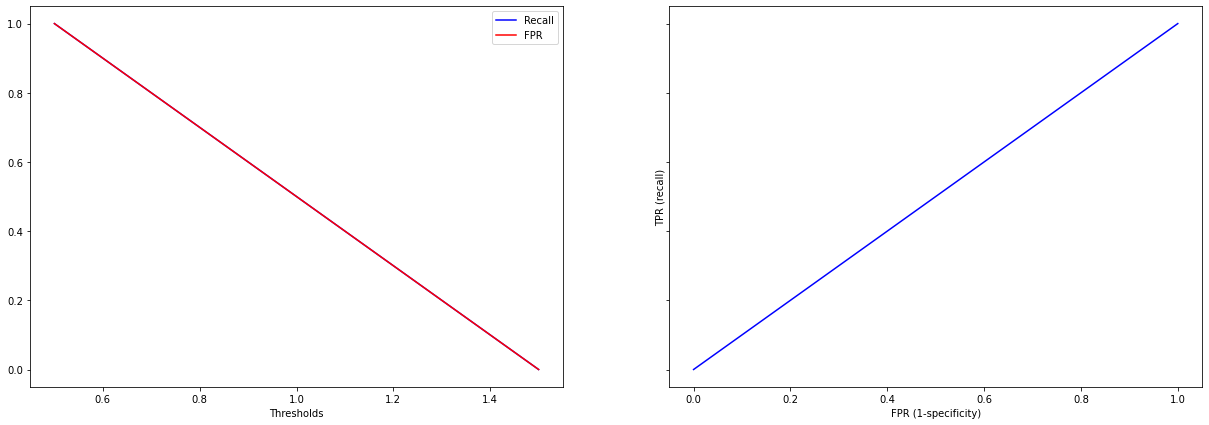

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


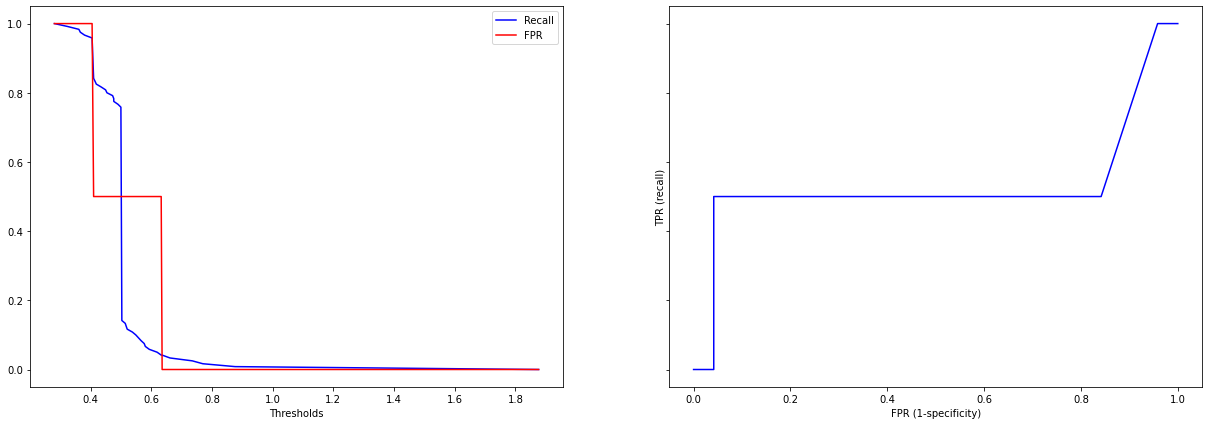

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.622784  0.334242   0.790504     0.911273  0.469593  0.597011
Validation  0.614225  0.328855   0.763057     0.900000  0.456652  0.586166


Random Forest (100 estimators)
╠■■■■■■■■■╣


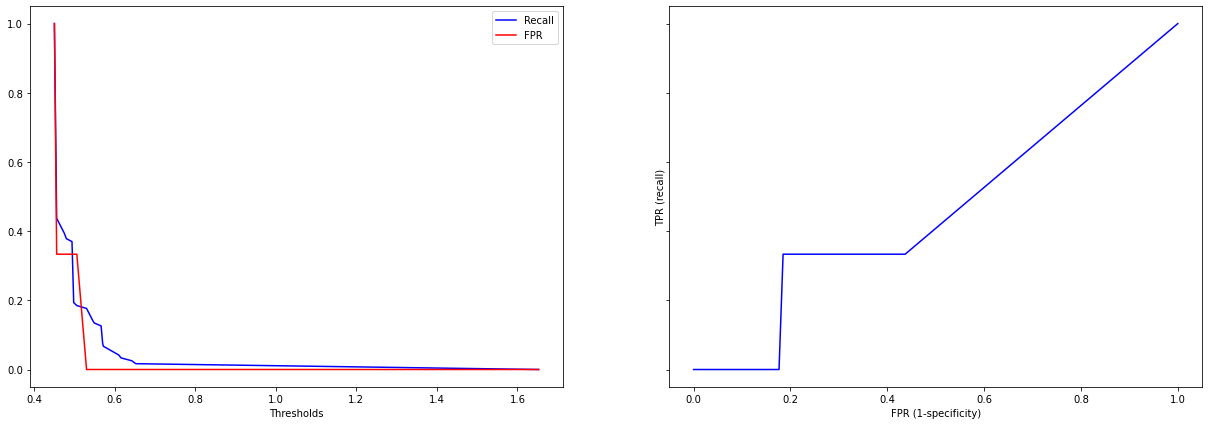

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.637376  0.471995   0.705335     0.802727  0.565436  0.667857
Validation  0.633493  0.470485   0.694874     0.796721  0.557506  0.661655


XGBoost Classifier
╠■■■■■■■■■╣


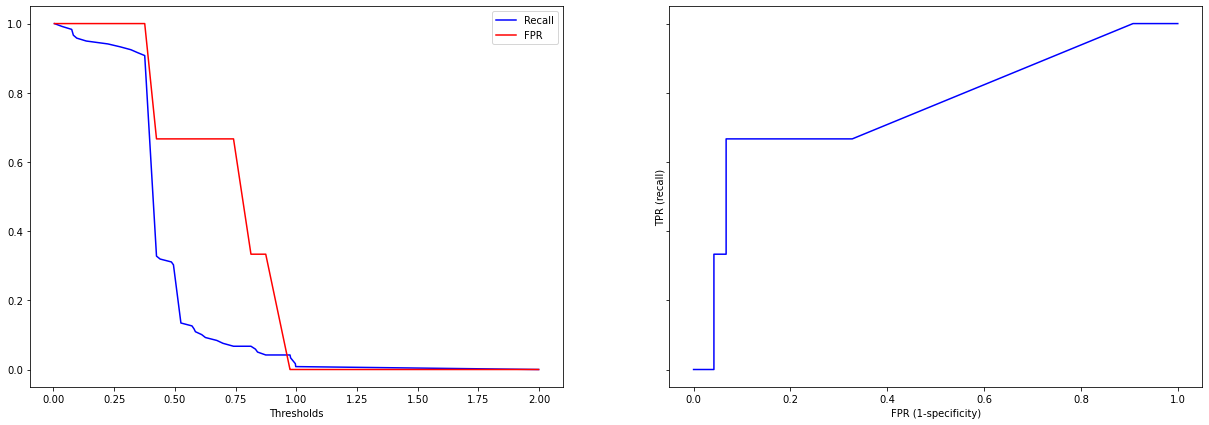

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.706383  0.510364   0.839604     0.902364  0.634632  0.757387
Validation  0.640443  0.447554   0.726772     0.833607  0.551498  0.659503


SVM
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.661424  0.500178   0.741716     0.822636  0.595563  0.690187
Validation  0.642894  0.486845   0.708177     0.799180  0.572272  0.675942


KNN
╠■■■■■■■■■╣


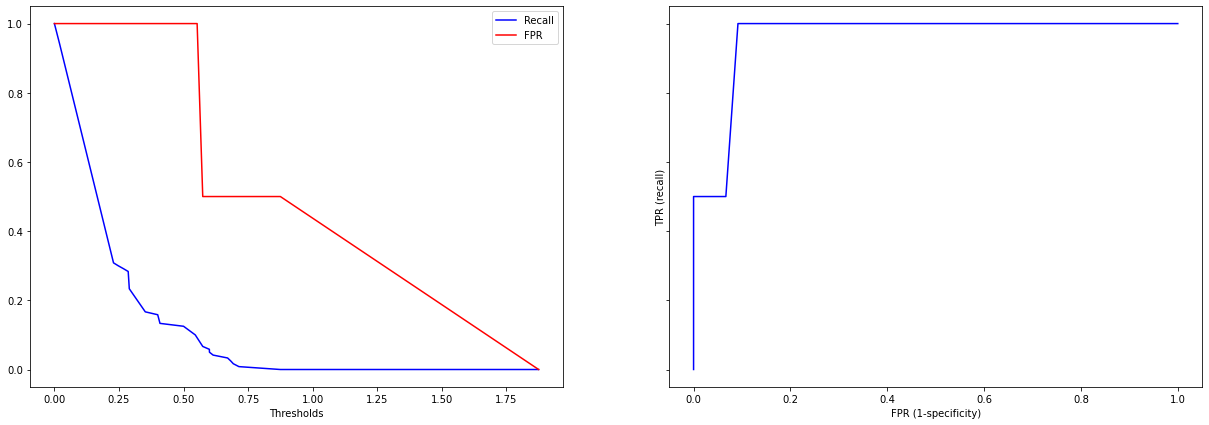

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.703791  0.490360   0.855885     0.917182  0.623231  0.738445
Validation  0.642482  0.434453   0.741939     0.850820  0.545746  0.656791


Logistic Regression
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity       F1   ROC_AUC
Training    0.663196  0.479358   0.758187     0.847000  0.58720  0.691534
Validation  0.657242  0.473731   0.746681     0.840984  0.57563  0.687029

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.614225  0.328855   0.763057     0.900000   
Random Forest (100 estimators)  0.633493  0.470485   0.694874     0.796721   
XGBoost Classifier              0.640443  0.447554   0.726772     0.833607   
SVM                             0.642894  0.486845   0.708177     0.799180   
KNN                             0.642482  0.434453   0.741939     0.850820   
Logistic Regression             0.657242  0.473731   0.746681     0.840984   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.456652  0.586166  
Random Forest (100 estimators)  0.557506  0.661655  
XGBoost Classifier              0.551498  0.659503  
SVM                             0.572272  0.675942  
KNN                             0.545746  0.656791  
Logistic Regression             0.575630  0.687029

In [32]:
run_models(r_symptoms.drop(columns=["sob", "cough"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

In almost all models performance went down if we removed the booleanw <b>cough</b> and <b>sob</b> in favor of the graded <b>cough_severity</b>.


Dummy Random
╠■■■■■■■■■╣


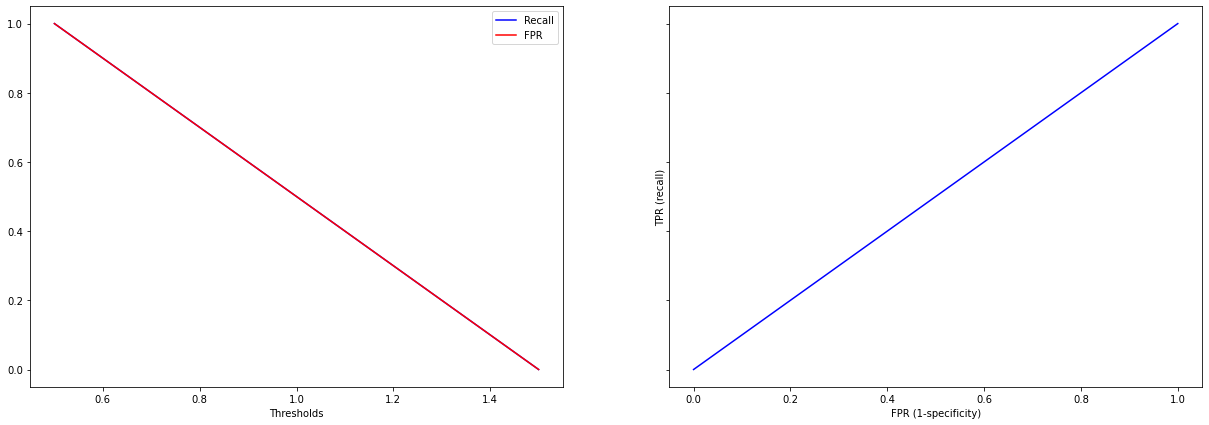

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


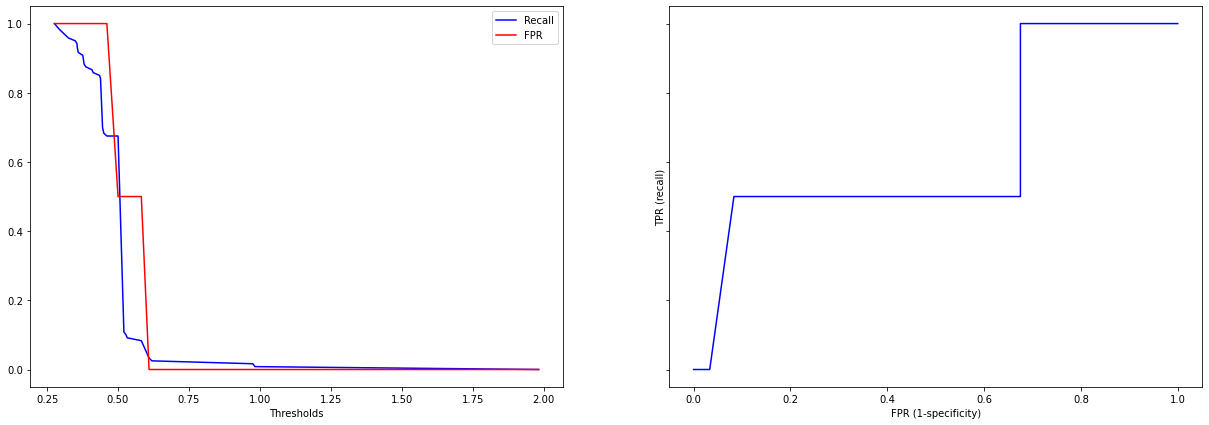

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.610555  0.311053   0.775798     0.910000  0.443828  0.580210
Validation  0.612175  0.305131   0.788714     0.919672  0.436418  0.573821


Random Forest (100 estimators)
╠■■■■■■■■■╣


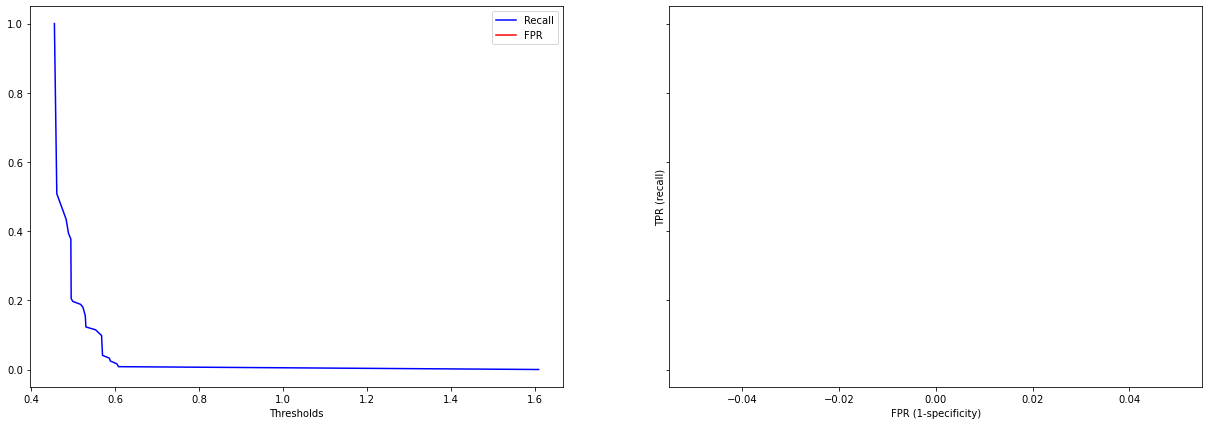

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.635467  0.482269   0.696920     0.788636  0.569236  0.666826
Validation  0.632247  0.478669   0.689712     0.786066  0.560491  0.666103


XGBoost Classifier
╠■■■■■■■■■╣


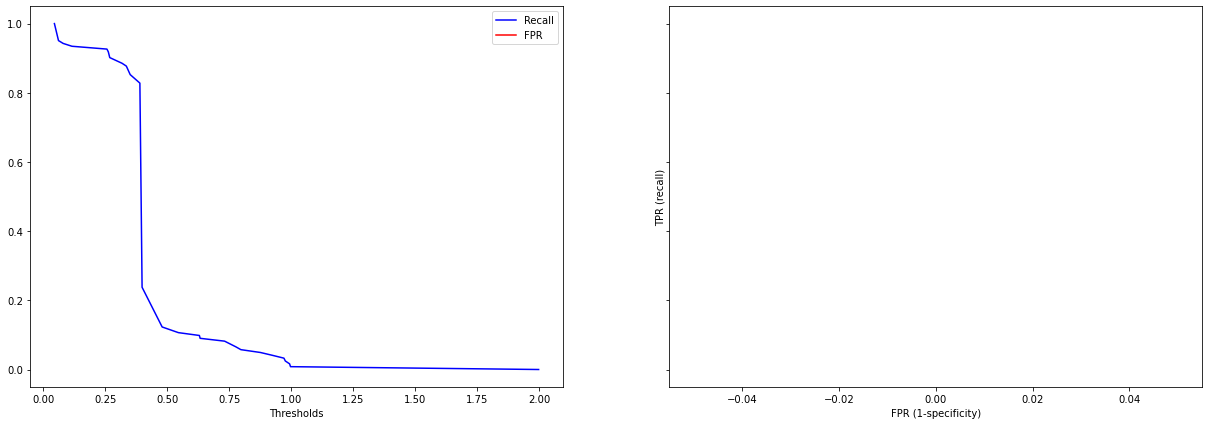

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.697200  0.504818   0.820660     0.889545  0.624918  0.745857
Validation  0.647007  0.447601   0.743694     0.846721  0.556360  0.651092


SVM
╠■■■■■■■■■╣


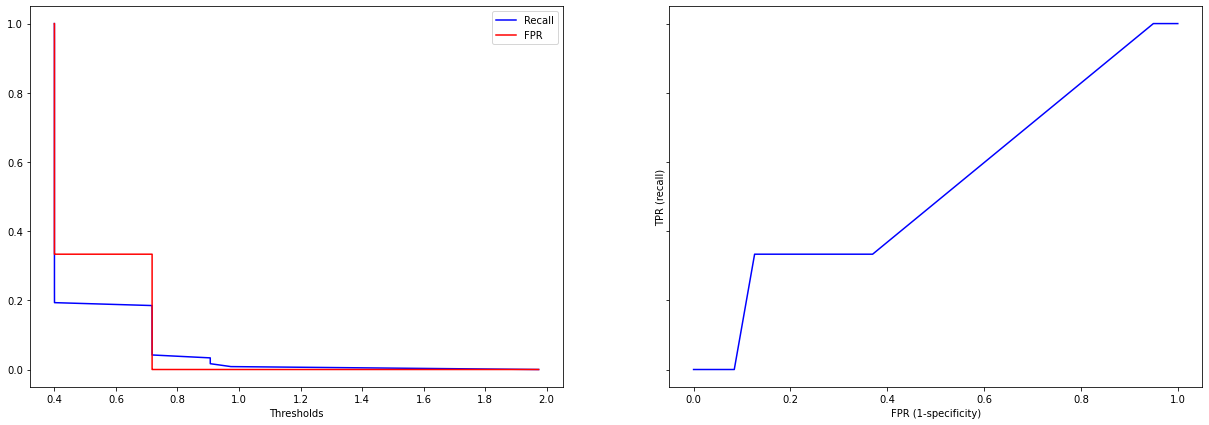

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.655241  0.446085   0.767650     0.864364  0.563536  0.686468
Validation  0.648218  0.440950   0.748543     0.855738  0.550366  0.679831


KNN
╠■■■■■■■■■╣


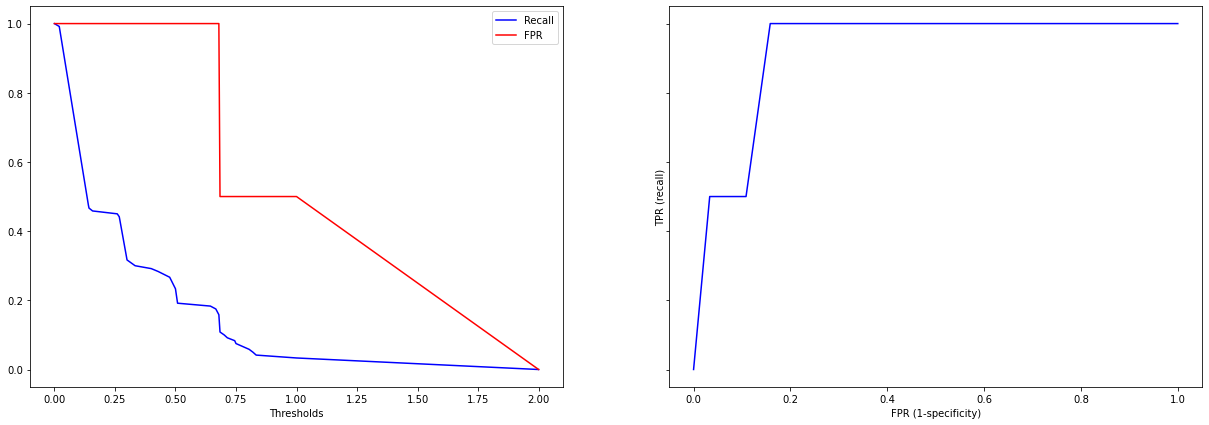

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.699199  0.489086   0.843594     0.909273  0.619005  0.735132
Validation  0.634697  0.429562   0.729019     0.840164  0.537954  0.654268


Logistic Regression
╠■■■■■■■■■╣


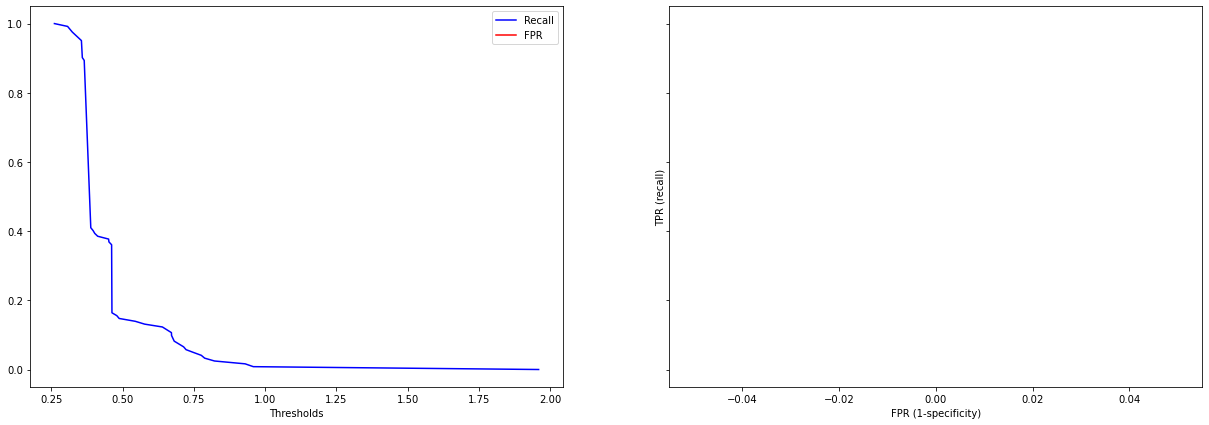

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664424  0.485726    0.75582     0.843091  0.591351  0.690533
Validation  0.661320  0.481074    0.75037     0.841803  0.580938  0.689431

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.612175  0.305131   0.788714     0.919672   
Random Forest (100 estimators)  0.632247  0.478669   0.689712     0.786066   
XGBoost Classifier              0.647007  0.447601   0.743694     0.846721   
SVM                             0.648218  0.440950   0.748543     0.855738   
KNN                             0.634697  0.429562   0.729019     0.840164   
Logistic Regression             0.661320  0.481074   0.750370     0.841803   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.436418  0.573821  
Random Forest (100 estimators)  0.560491  0.666103  
XGBoost Classifier              0.556360  0.651092  
SVM                             0.550366  0.679831  
KNN                             0.537954  0.654268  
Logistic Regression             0.580938  0.689431

In [33]:
run_models(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Apparently keeping both the boolean and the graded yields better performance for every algorithm, except for <b>XGBoost</b> which improves when we just leave the boolean value.

Dummy Random
╠■■■■■■■■■╣


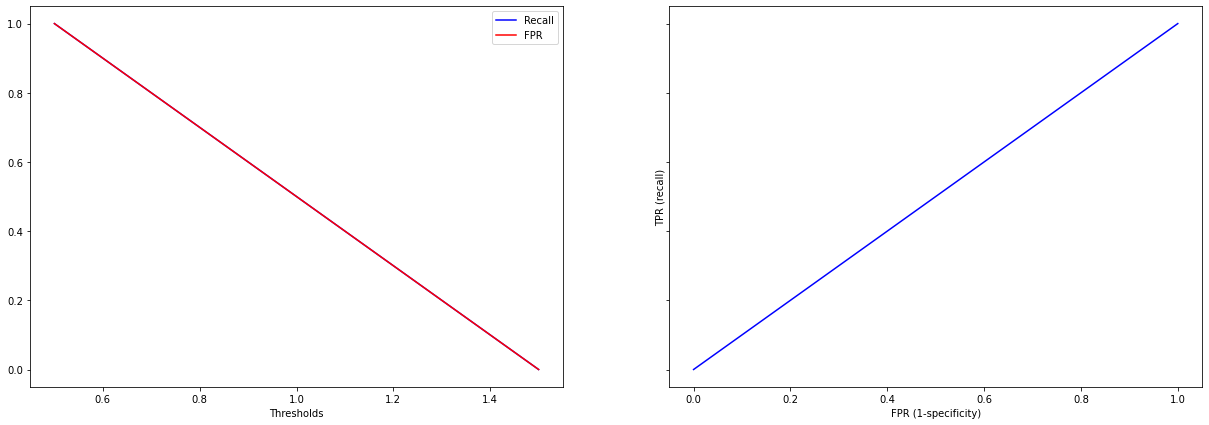

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500070     0.0        0.0          1.0  0.0      0.5
Validation  0.499372     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


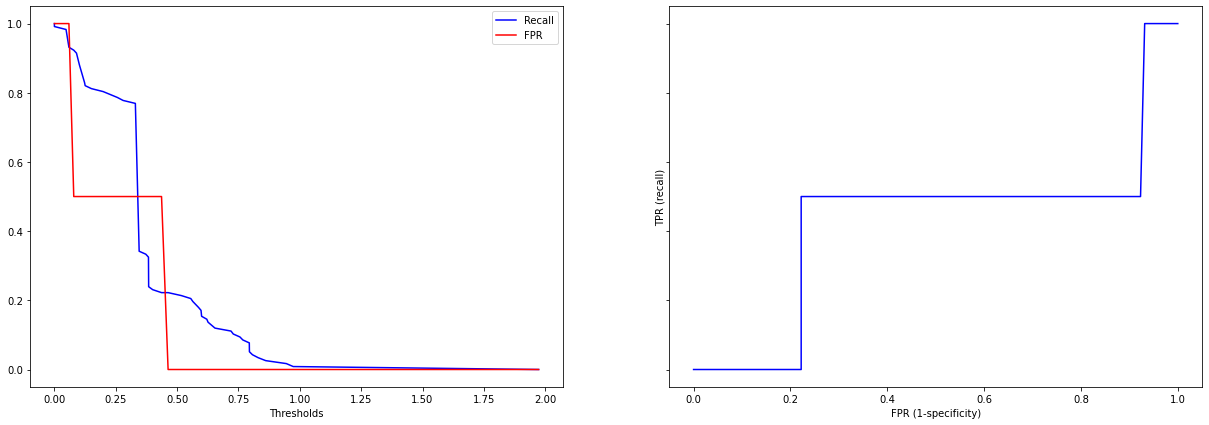

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.655027  0.510478   0.717971     0.799534  0.596678  0.687710
Validation  0.652122  0.506303   0.712350     0.798319  0.587927  0.685041


Random Forest (100 estimators)
╠■■■■■■■■■╣


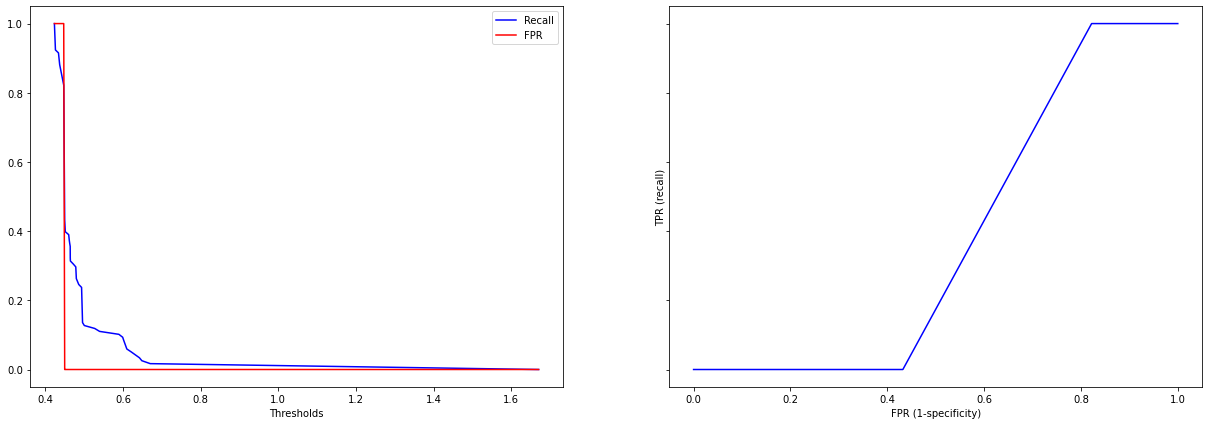

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.637985  0.461582   0.713139     0.814339  0.560313  0.684005
Validation  0.639545  0.455133   0.717877     0.824370  0.552932  0.682090


XGBoost Classifier
╠■■■■■■■■■╣


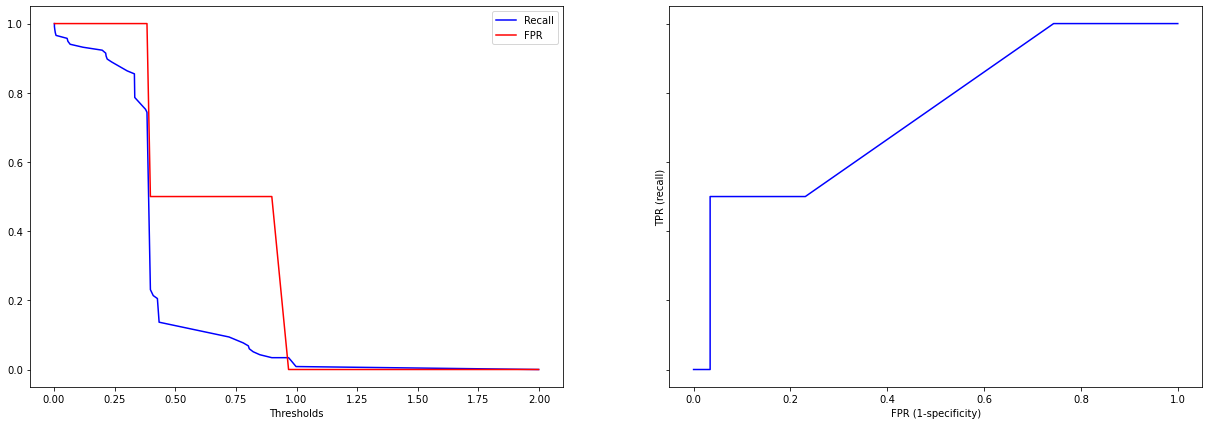

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.765284  0.589924   0.908547     0.940596  0.715252  0.839976
Validation  0.647092  0.471975   0.722944     0.822689  0.568734  0.661330


SVM
╠■■■■■■■■■╣


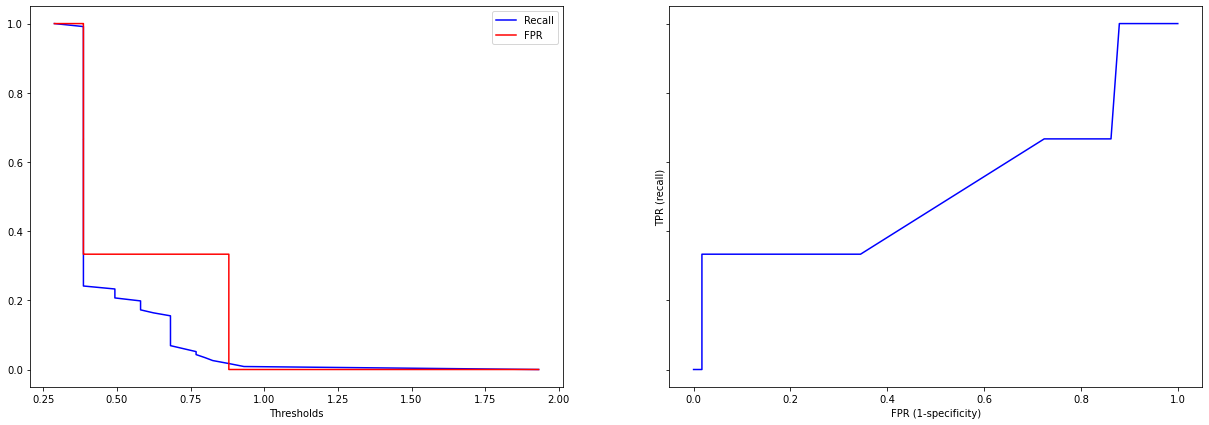

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664618  0.470429   0.769593     0.858752  0.583560  0.708669
Validation  0.661353  0.462759   0.765935     0.860504  0.572286  0.702997


KNN
╠■■■■■■■■■╣


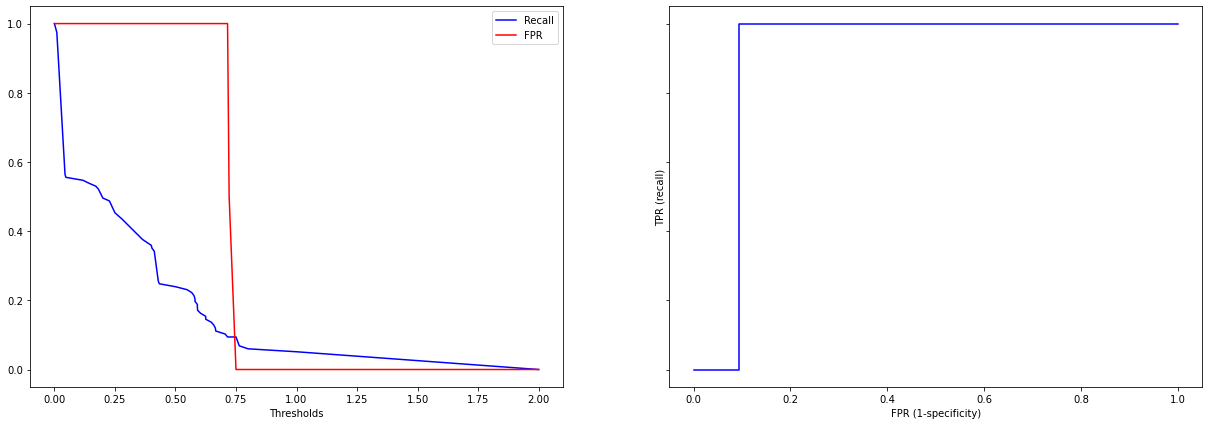

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.766914  0.568501   0.942571     0.965270  0.709106  0.821209
Validation  0.639543  0.468641   0.709463     0.810924  0.561154  0.650510


Logistic Regression
╠■■■■■■■■■╣


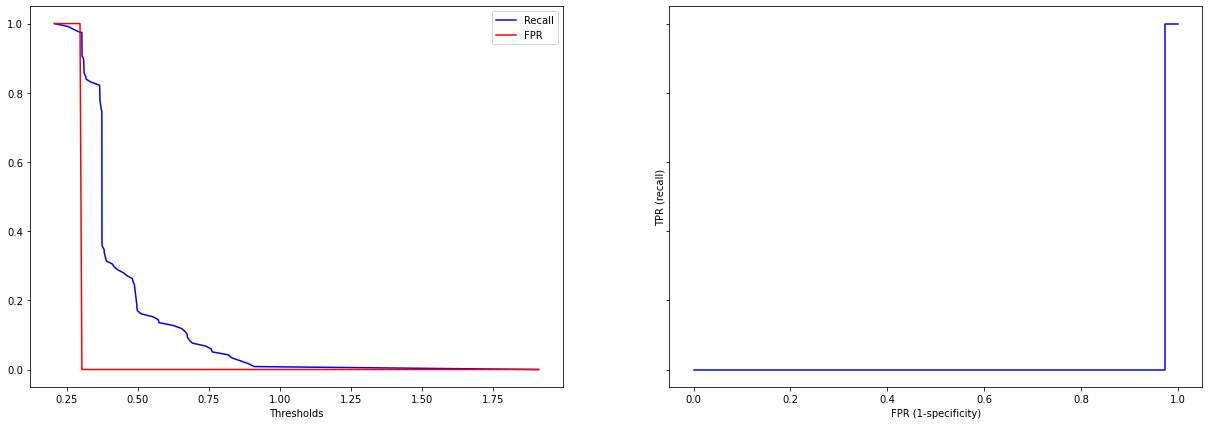

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.669368  0.510662   0.750688     0.828026  0.606688  0.712779
Validation  0.664720  0.494622   0.750833     0.835294  0.591030  0.713033

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499372  0.000000   0.000000     1.000000   
MultinomialNB                   0.652122  0.506303   0.712350     0.798319   
Random Forest (100 estimators)  0.639545  0.455133   0.717877     0.824370   
XGBoost Classifier              0.647092  0.471975   0.722944     0.822689   
SVM                             0.661353  0.462759   0.765935     0.860504   
KNN                             0.639543  0.468641   0.709463     0.810924   
Logistic Regression             0.664720  0.494622   0.750833     0.835294   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.587927  0.685041  
Random Forest (100 estimators)  0.552932  0.682090  
XGBoost Classifier              0.568734  0.661330  
SVM                             0.572286  0.702997  
KNN                             0.561154  0.650510  
Logistic Regression             0.591030  0.713033

In [34]:
#ra_symptoms
run_models(ra_symptoms, y[ra_symptoms.index], models, ratio_negatives_to_positives=1)

Apparently, all features in <b>reported_symptoms</b> are more important than the assesed ones. <b>days_since_symptom_onset</b> seems to have some importance. Performance improves slightly for all of them except for <b>SVM</b> and <b>Logistic Regression</b>. Logistic Regression improves with a slightly lower threshold (.4 for higher recall and .44 for higher specificity). SVM improves also with a lower threshold(.47)

Dummy Random
╠■■■■■■■■■╣


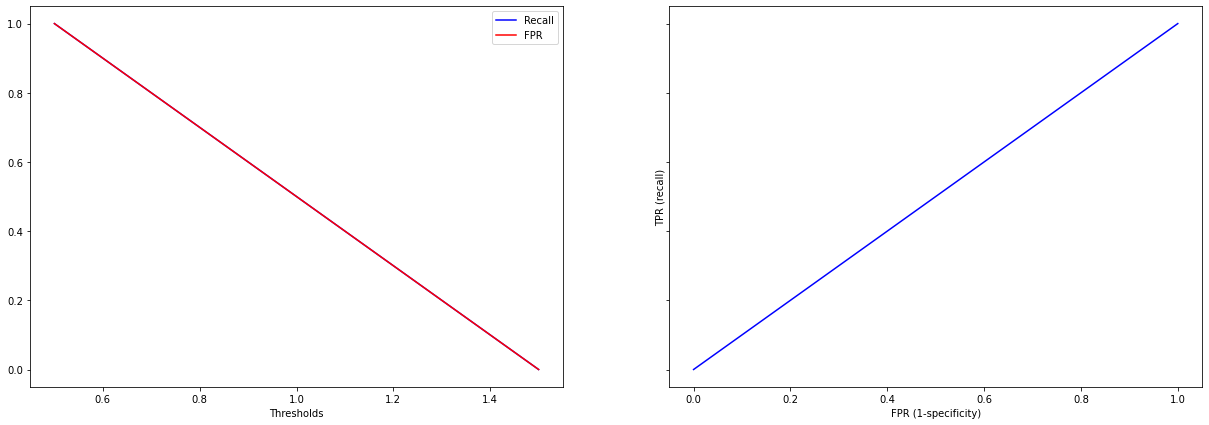

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500045     0.0        0.0          1.0  0.0      0.5
Validation  0.499592     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.653559  0.489542   0.728375     0.817545  0.585507  0.679717
Validation  0.649057  0.481994   0.720053     0.816393  0.576138  0.671130


Random Forest (100 estimators)
╠■■■■■■■■■╣


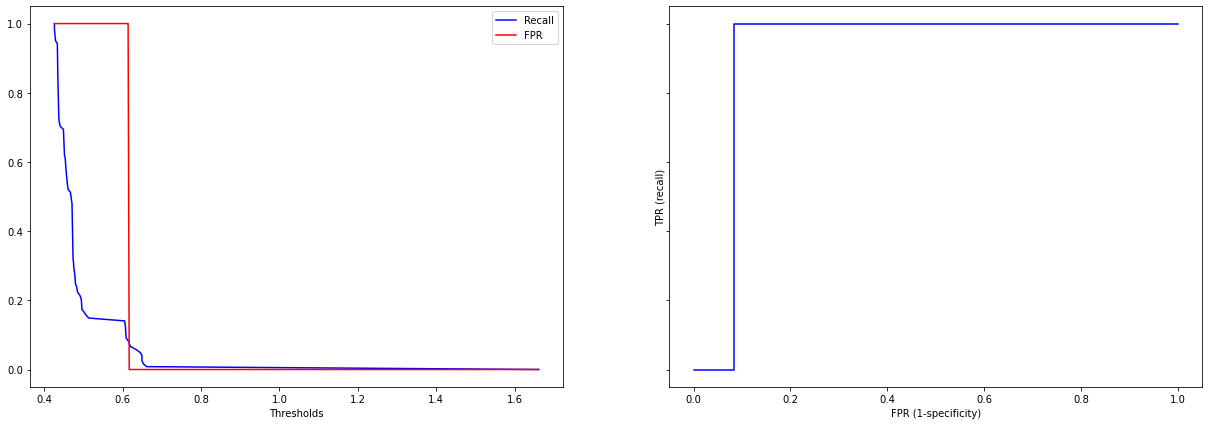

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.639876  0.437261   0.735471     0.842455  0.548185  0.685417
Validation  0.637998  0.432007   0.730124     0.844262  0.538837  0.683986


XGBoost Classifier
╠■■■■■■■■■╣


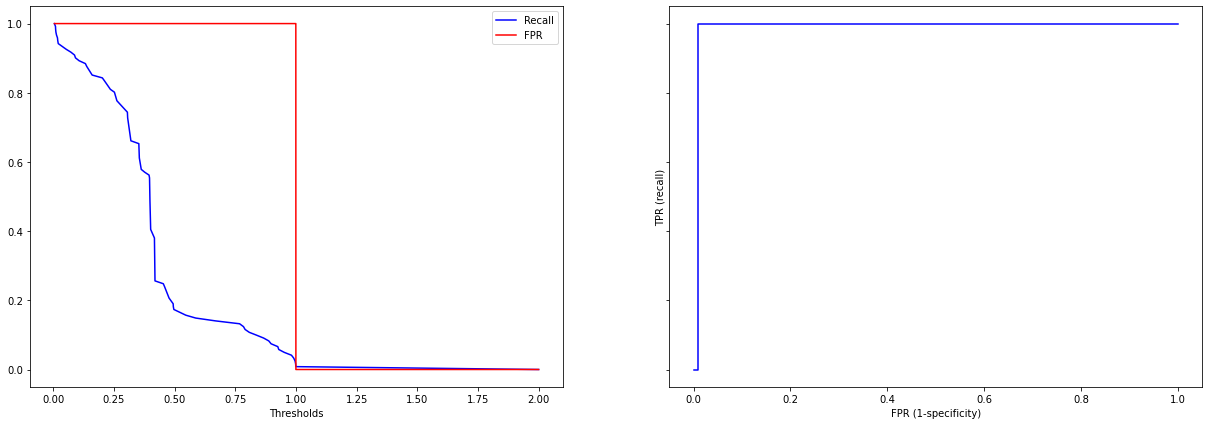

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.750659  0.564466   0.899631     0.936818  0.693366  0.834557
Validation  0.638816  0.444309   0.729881     0.833607  0.550863  0.653057


SVM
╠■■■■■■■■■╣


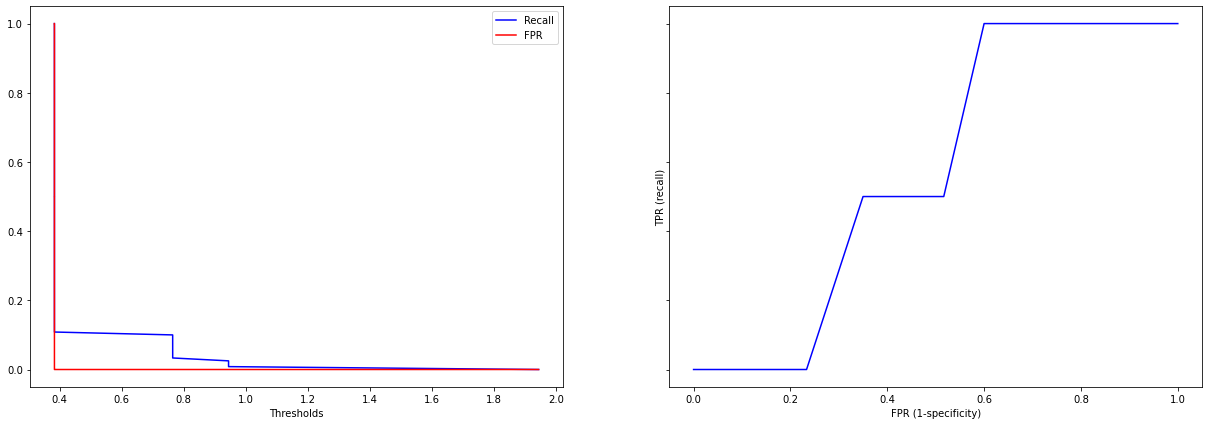

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.653422  0.444256   0.764216     0.862545  0.561032  0.697864
Validation  0.655187  0.445129   0.766727     0.865574  0.559044  0.693589


KNN
╠■■■■■■■■■╣


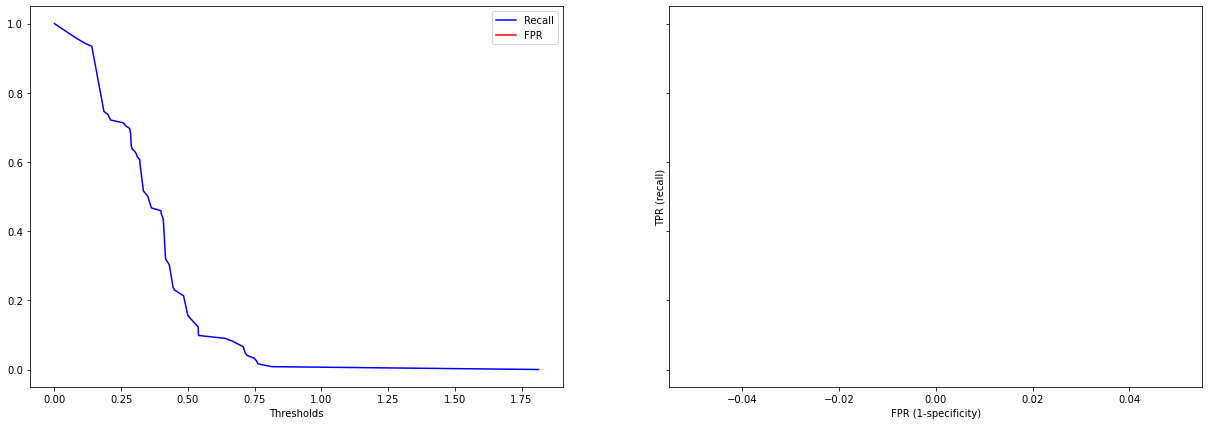

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.752068  0.550461   0.922696     0.953636  0.689284  0.802937
Validation  0.617491  0.390257   0.714441     0.845082  0.502643  0.637657


Logistic Regression
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664560  0.498819   0.747351     0.830273  0.597873  0.707942
Validation  0.654801  0.481941   0.738039     0.827869  0.579247  0.703755

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499592  0.000000   0.000000     1.000000   
MultinomialNB                   0.649057  0.481994   0.720053     0.816393   
Random Forest (100 estimators)  0.637998  0.432007   0.730124     0.844262   
XGBoost Classifier              0.638816  0.444309   0.729881     0.833607   
SVM                             0.655187  0.445129   0.766727     0.865574   
KNN                             0.617491  0.390257   0.714441     0.845082   
Logistic Regression             0.654801  0.481941   0.738039     0.827869   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.576138  0.671130  
Random Forest (100 estimators)  0.538837  0.683986  
XGBoost Classifier              0.550863  0.653057  
SVM                             0.559044  0.693589  
KNN                             0.502643  0.637657  
Logistic Regression             0.579247  0.703755

In [35]:
#r_symptoms_ex
run_models(r_symptoms_ex, y[r_symptoms_ex.index], models, ratio_negatives_to_positives=1)

Epidemiological factors proves themselves to be slightly more important that some of the of the reported symptoms. <b>high_risk_exposure_occupation</b> once again proves to be a highly determinant feature. It also improves performance in all other models, while reducing specificity by a small amount (with the exception of <b>KNN</b>).

Dummy Random
╠■■■■■■■■■╣


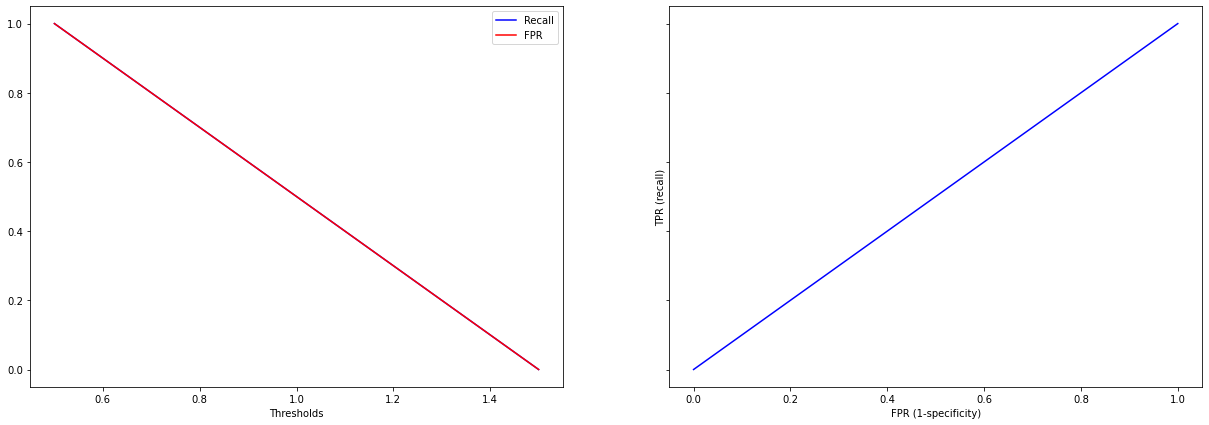

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


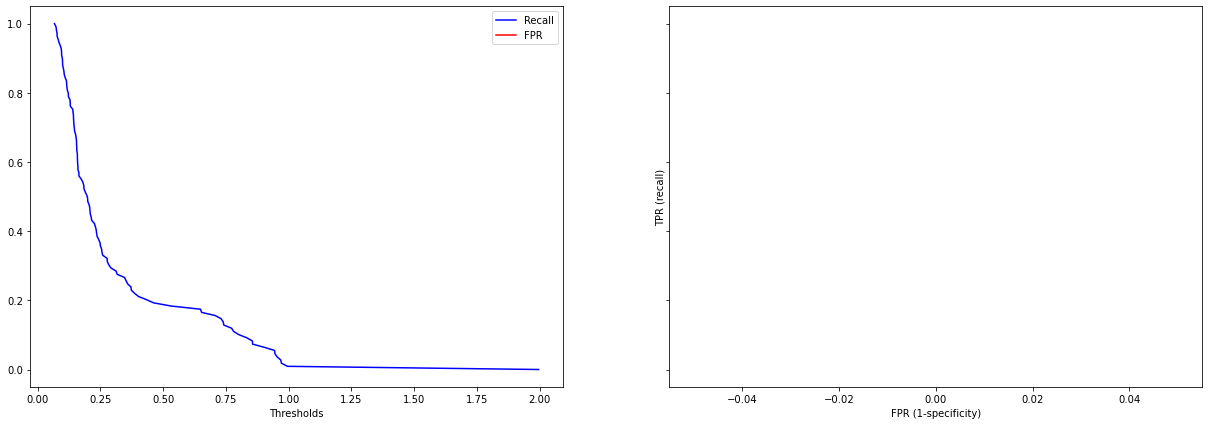

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.660704  0.501567   0.735468     0.819697  0.596384  0.706027
Validation  0.648706  0.497765   0.712472     0.800917  0.583681  0.693892


Random Forest (100 estimators)
╠■■■■■■■■■╣


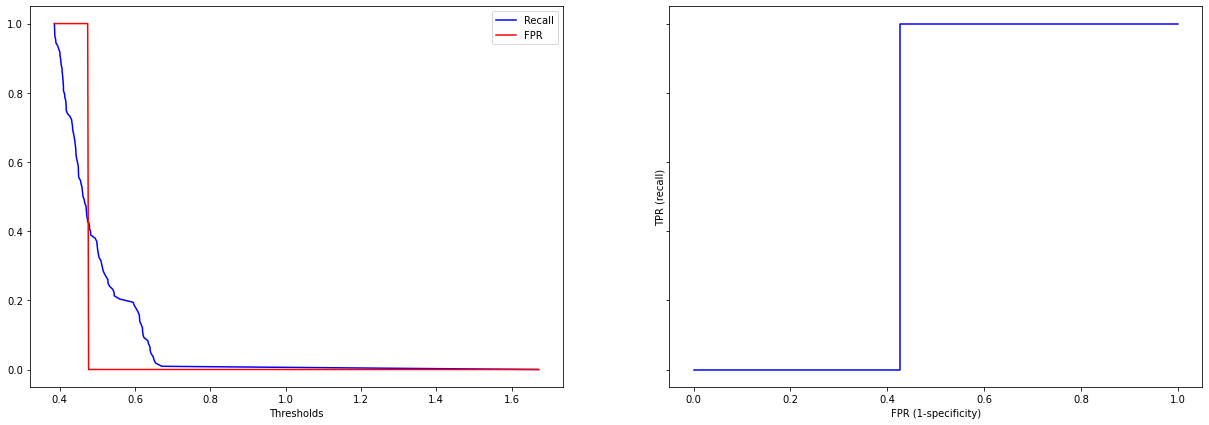

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.659542  0.502177   0.732923     0.816768  0.595642  0.721922
Validation  0.645511  0.485922   0.714270     0.806422  0.575593  0.692689


XGBoost Classifier
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999394  0.999292   0.999495     0.999495  0.999393  0.999998
Validation  0.627676  0.612335   0.633480     0.643119  0.622544  0.686491


SVM
╠■■■■■■■■■╣


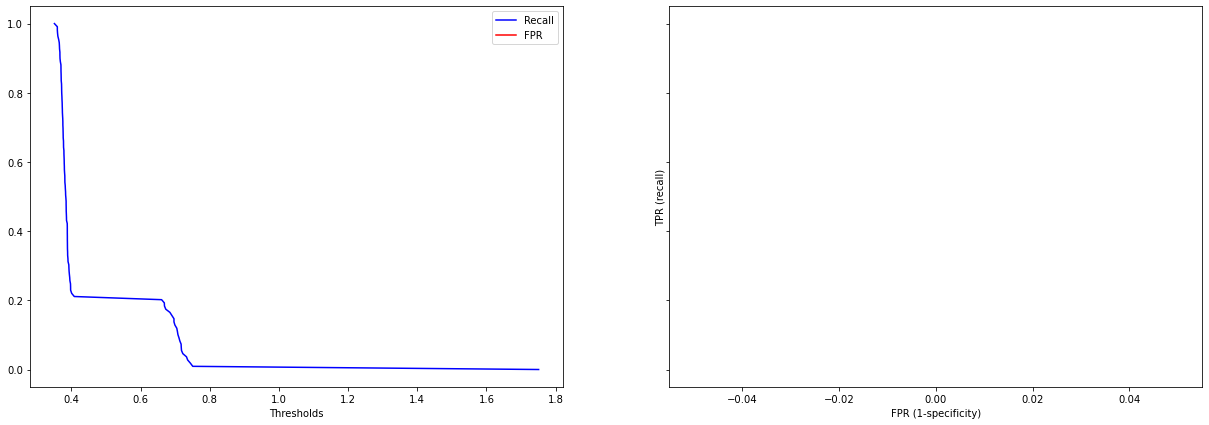

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.666566  0.473259   0.771979     0.859697  0.586157  0.737737
Validation  0.652815  0.461343   0.746567     0.845872  0.568294  0.722945


KNN
╠■■■■■■■■■╣


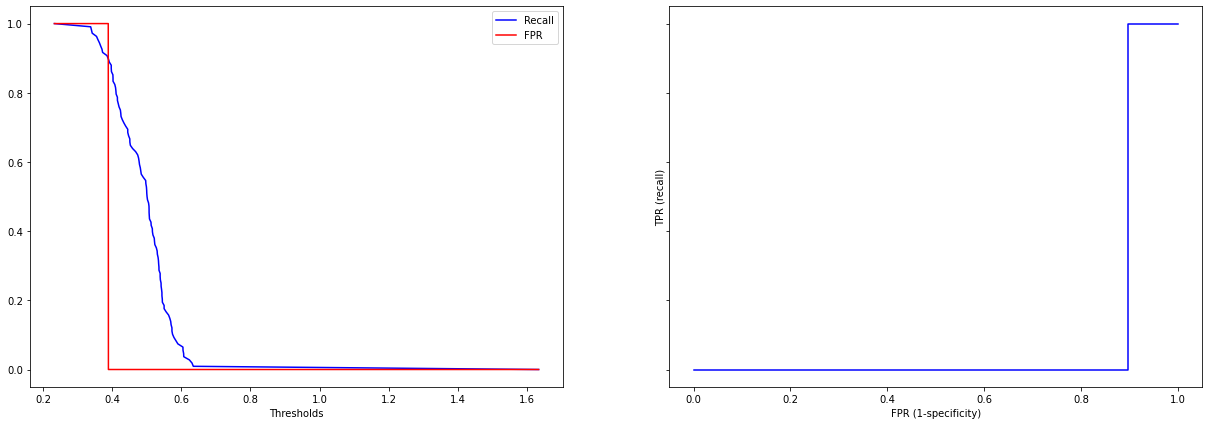

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999545  0.999090    1.00000     1.000000  0.999545  0.999999
Validation  0.566905  0.510442    0.57667     0.623853  0.538838  0.603171


Logistic Regression
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.674852  0.549287   0.733546     0.800303  0.628028  0.732871
Validation  0.655546  0.535029   0.707030     0.777064  0.606870  0.707929

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.648706  0.497765   0.712472     0.800917   
Random Forest (100 estimators)  0.645511  0.485922   0.714270     0.806422   
XGBoost Classifier              0.627676  0.612335   0.633480     0.643119   
SVM                             0.652815  0.461343   0.746567     0.845872   
KNN                             0.566905  0.510442   0.576670     0.623853   
Logistic Regression             0.655546  0.535029   0.707030     0.777064   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.583681  0.693892  
Random Forest (100 estimators)  0.575593  0.692689  
XGBoost Classifier              0.622544  0.686491  
SVM                             0.568294  0.722945  
KNN                             0.538838  0.603171  
Logistic Regression             0.606870  0.707929

In [50]:
#r_symptoms_vitals
run_models(r_symptoms_vitals, y[r_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


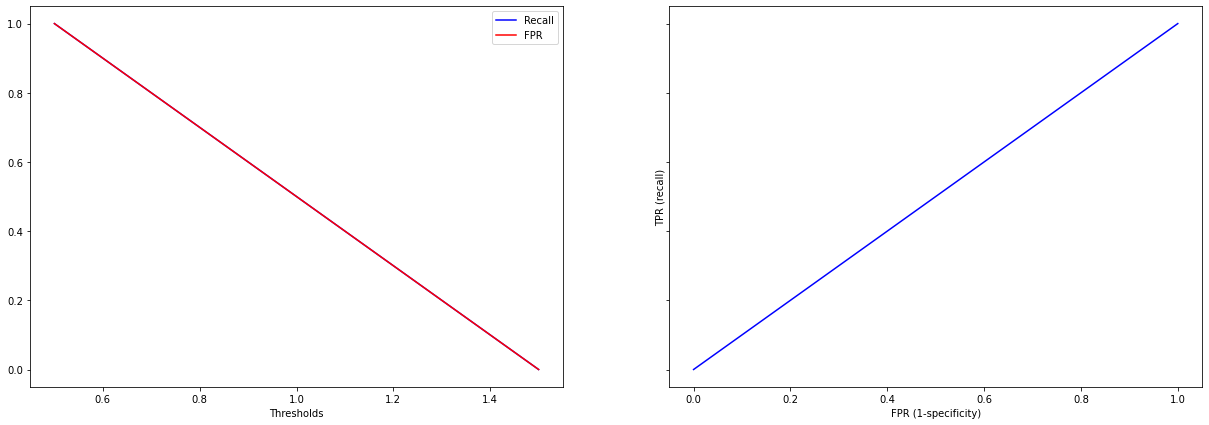

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500227     0.0        0.0          1.0  0.0      0.5
Validation  0.497945     0.0        0.0          1.0  0.0      0.5


MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


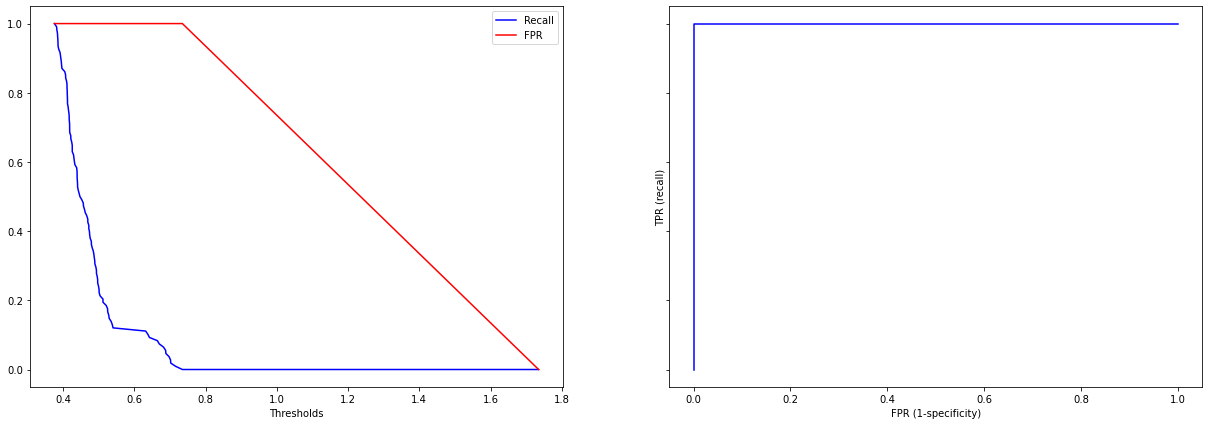

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.659694  0.508343   0.728927     0.810909  0.598745  0.723641
Validation  0.642776  0.489583   0.705494     0.797248  0.575029  0.702447


XGBoost Classifier
╠■■■■■■■■■╣


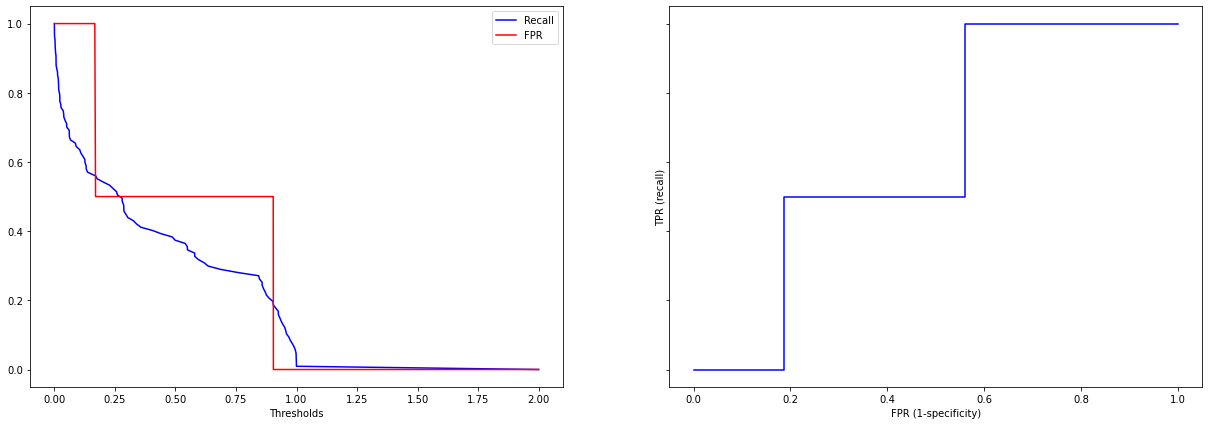

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999646  0.999596   0.999697     0.999697  0.999646  0.999999
Validation  0.616711  0.581376   0.628263     0.652294  0.603152  0.669386


SVM
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.667021  0.476798   0.770692     0.857071  0.588347  0.738593
Validation  0.661952  0.470434   0.763497     0.855046  0.577102  0.724708


KNN
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999545  0.999090   1.000000     1.000000  0.999545  0.999999
Validation  0.635922  0.403153   0.755362     0.870642  0.521418  0.700716


Logistic Regression
╠■■■■■■■■■╣


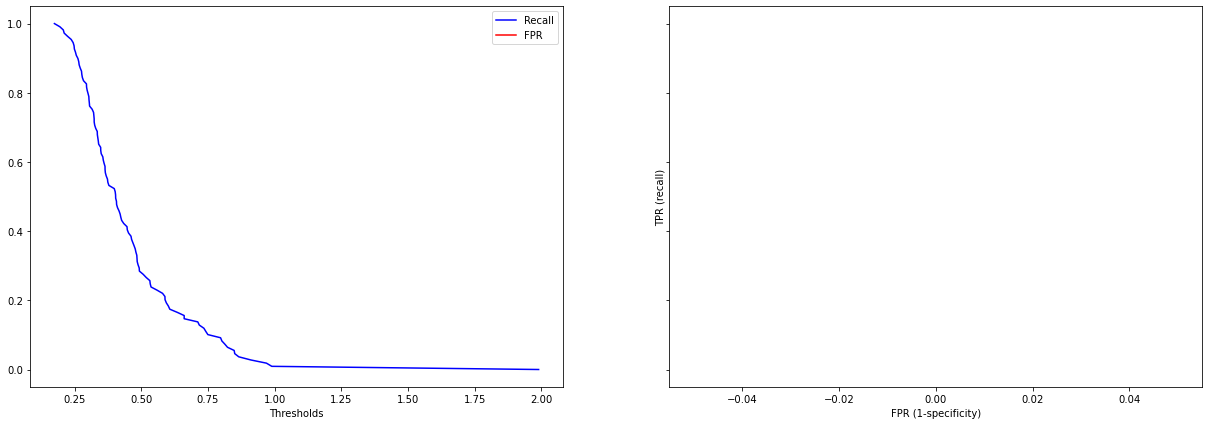

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.684301  0.561422   0.744563     0.807071  0.639927  0.742619
Validation  0.675208  0.538682   0.743478     0.812844  0.623911  0.733815

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497945  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.642776  0.489583   0.705494     0.797248   
XGBoost Classifier              0.616711  0.581376   0.628263     0.652294   
SVM                             0.661952  0.470434   0.763497     0.855046   
KNN                             0.635922  0.403153   0.755362     0.870642   
Logistic Regression             0.675208  0.538682   0.743478     0.812844   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.575029  0.702447  
XGBoost Classifier              0.603152  0.669386  
SVM                             0.577102  0.724708  
KNN                             0.521418  0.700716  
Logistic Regression             0.623911  0.733815

In [46]:
#r_symptoms_svitals
run_models(r_symptoms_svitals, y[r_symptoms_svitals.index], models, ratio_negatives_to_positives=1)

It seems the vitals do hold certain importance compared to the reported symptoms. Surprisingly, <b>sats</b> is on the list of high importance, however this might be due to the vitals not being standardized. Again there is an improvement, with a little sacrifice in specificity. <b>XGB</b> and <b>KNN</b> however performed slightly worse.

Dummy Random
╠■■■■■■■■■╣


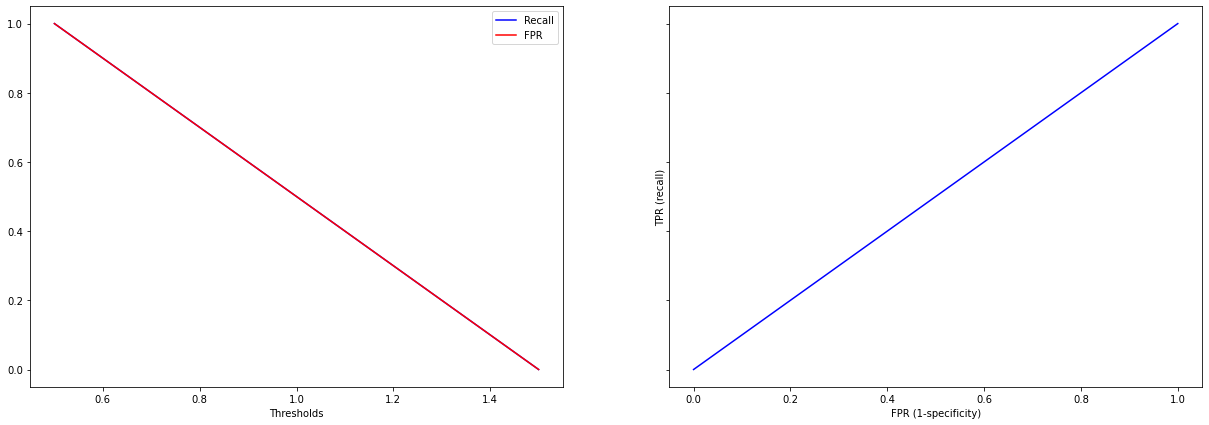

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


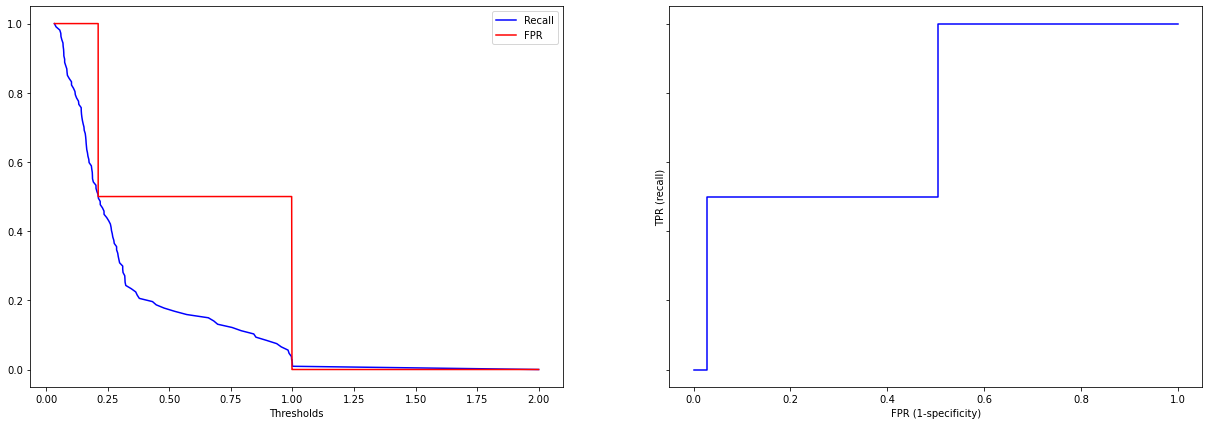

feature_importances


Permutation Importance


Accuracy   Recall  Precision  Specificity        F1   ROC_AUC
Training    0.662592  0.51091   0.733249     0.814199  0.602176  0.712576
Validation  0.656757  0.50774   0.719932     0.806422  0.592496  0.699159


Random Forest (100 estimators)
╠■■■■■■■■■╣


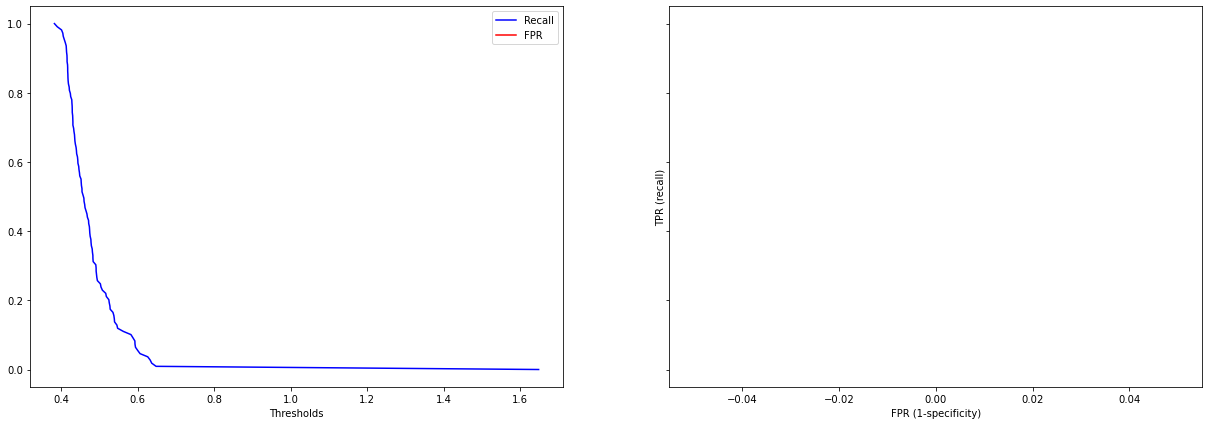

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.665179  0.537184   0.722706     0.793103  0.615870  0.725421
Validation  0.653959  0.526864   0.705189     0.781651  0.599983  0.698767


XGBoost Classifier
╠■■■■■■■■■╣


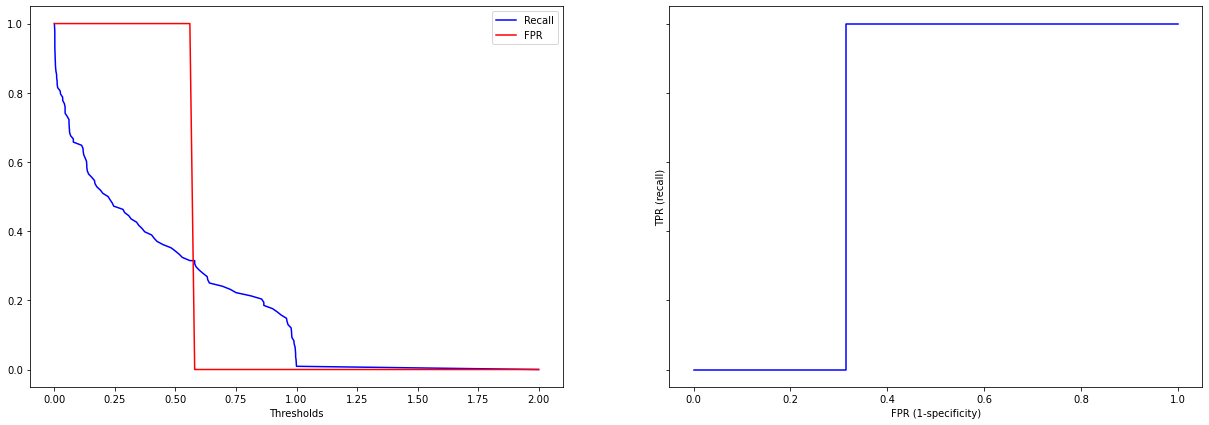

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999746  0.999493   1.000000     1.000000  0.999746  1.000000
Validation  0.617861  0.598082   0.623797     0.637615  0.609899  0.674504


SVM
╠■■■■■■■■■╣


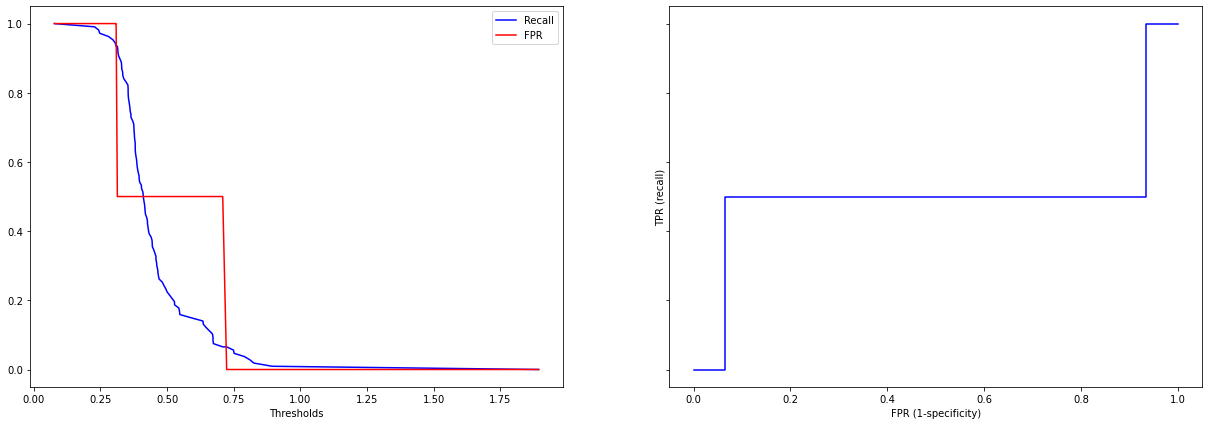

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.676895  0.502692   0.771767     0.851014  0.608516  0.744650
Validation  0.659034  0.483945   0.746109     0.834862  0.581034  0.728792


KNN
╠■■■■■■■■■╣


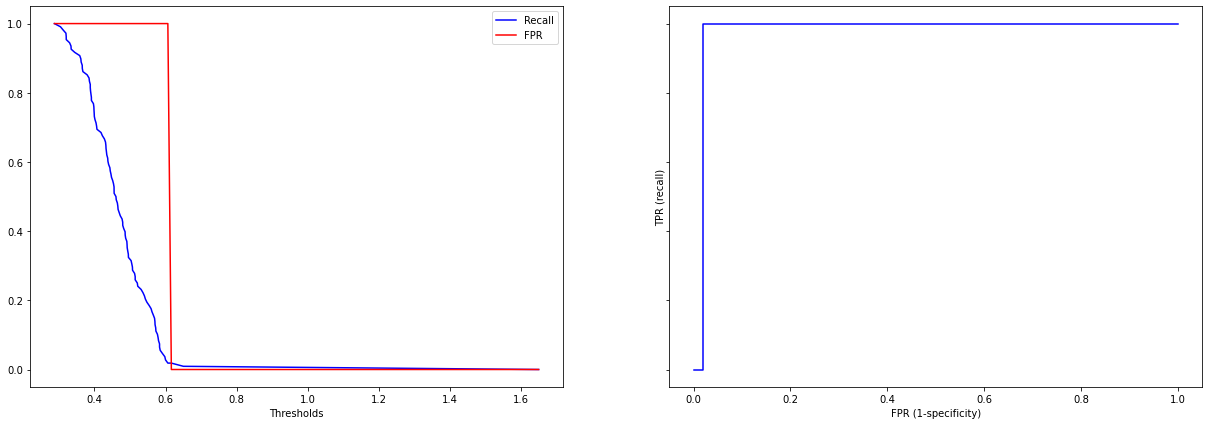

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training      1.0000  1.000000   1.000000     1.000000  1.000000  1.000000
Validation    0.5794  0.479374   0.597856     0.679817  0.529973  0.616312


Logistic Regression
╠■■■■■■■■■╣


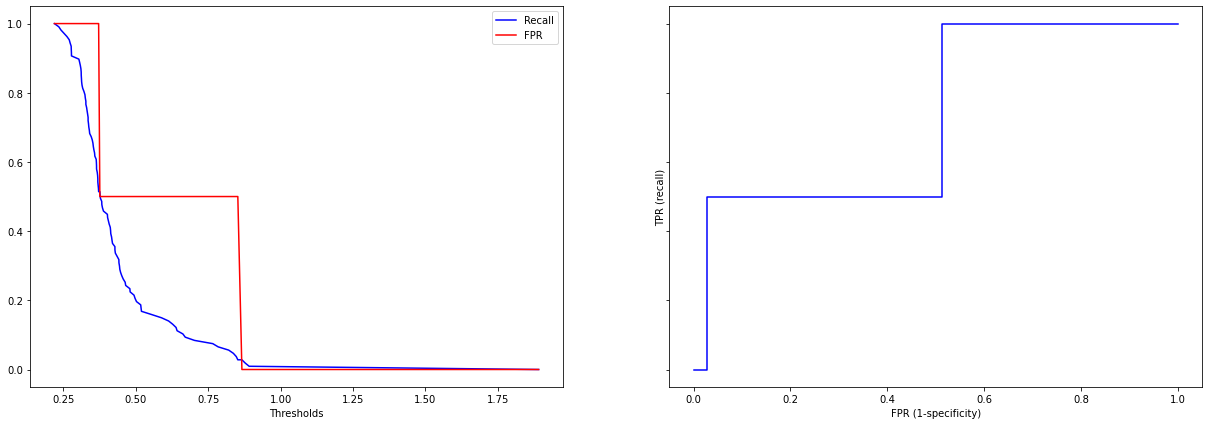

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.676440  0.557484   0.731790     0.795335  0.632708  0.734197
Validation  0.657216  0.534304   0.709531     0.780734  0.607359  0.705592

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.656757  0.507740   0.719932     0.806422   
Random Forest (100 estimators)  0.653959  0.526864   0.705189     0.781651   
XGBoost Classifier              0.617861  0.598082   0.623797     0.637615   
SVM                             0.659034  0.483945   0.746109     0.834862   
KNN                             0.579400  0.479374   0.597856     0.679817   
Logistic Regression             0.657216  0.534304   0.709531     0.780734   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.592496  0.699159  
Random Forest (100 estimators)  0.599983  0.698767  
XGBoost Classifier              0.609899  0.674504  
SVM                             0.581034  0.728792  
KNN                             0.529973  0.616312  
Logistic Regression             0.607359  0.705592

In [53]:
#ra_symptoms_vitals
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


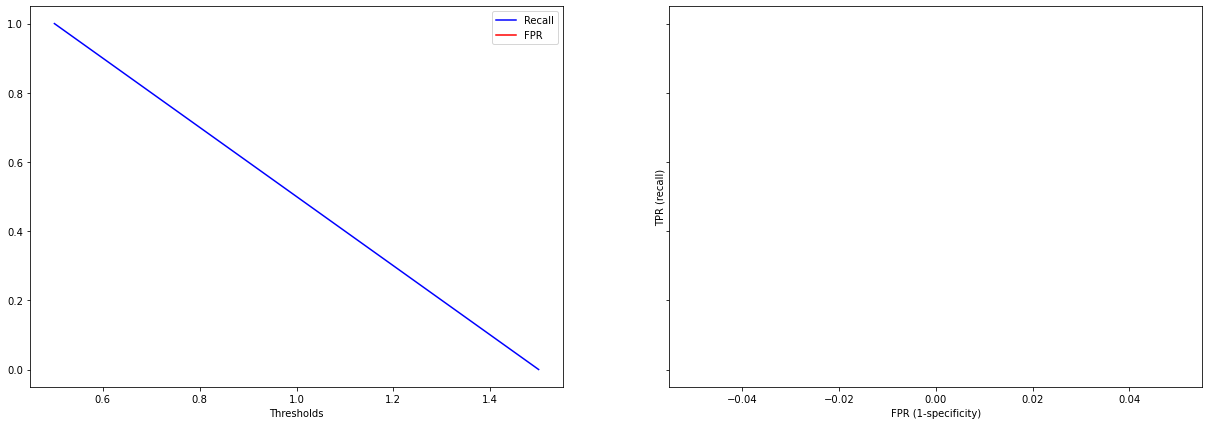

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


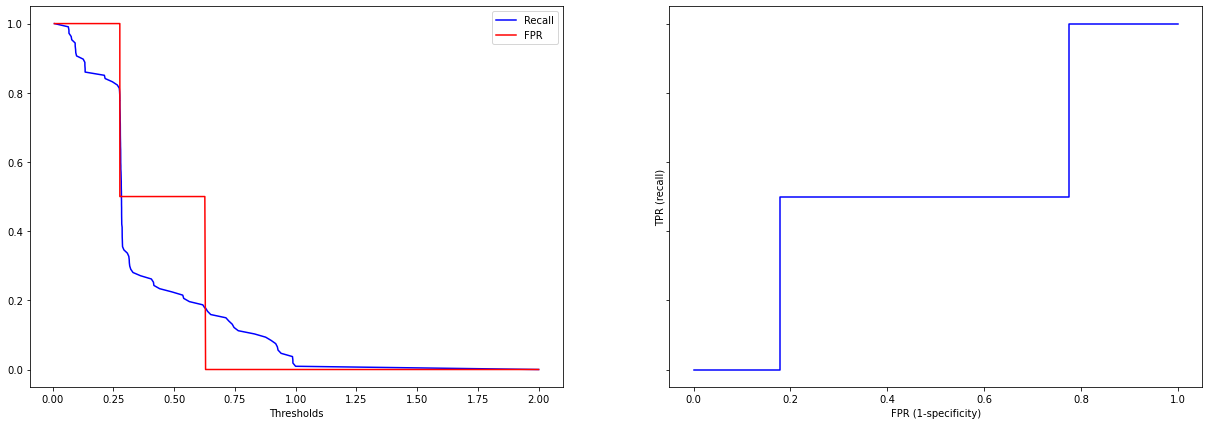

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.657622  0.497718   0.731739     0.817444  0.592342  0.687569
Validation  0.654916  0.495855   0.723472     0.814679  0.586462  0.688381


Random Forest (100 estimators)
╠■■■■■■■■■╣


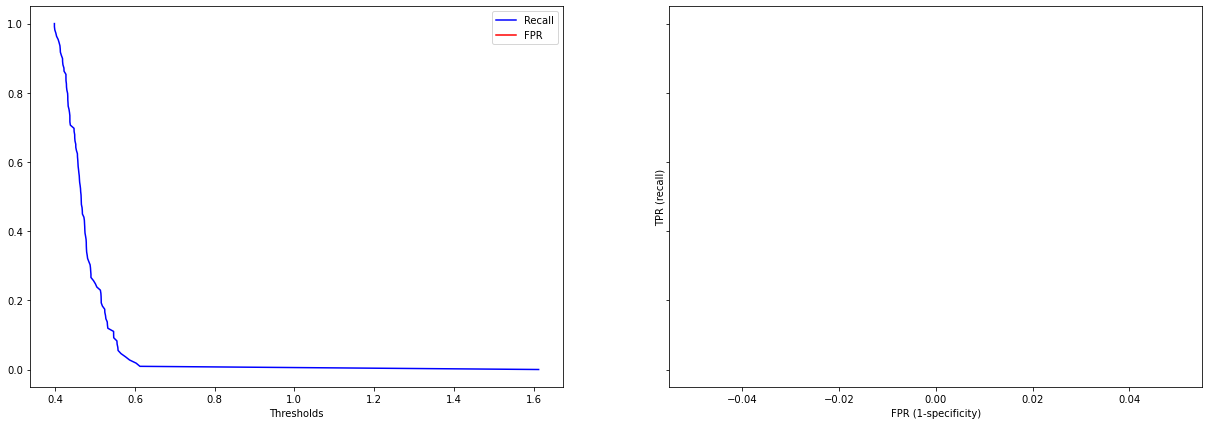

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.662185  0.523386   0.724545     0.800913  0.607453  0.721852
Validation  0.642966  0.513136   0.693981     0.773394  0.586653  0.690452


XGBoost Classifier
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999746  0.999594   0.999899     0.999899  0.999746  1.000000
Validation  0.617867  0.606422   0.622257     0.629358  0.613140  0.667488


SVM
╠■■■■■■■■■╣


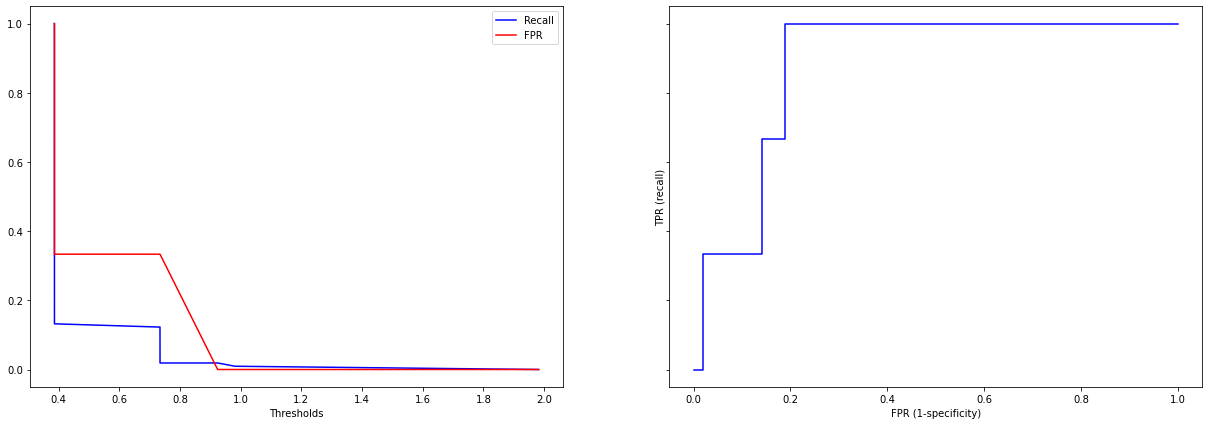

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664214  0.470923   0.767819     0.857404  0.583535  0.734451
Validation  0.659497  0.463928   0.757517     0.855963  0.572510  0.717633


KNN
╠■■■■■■■■■╣


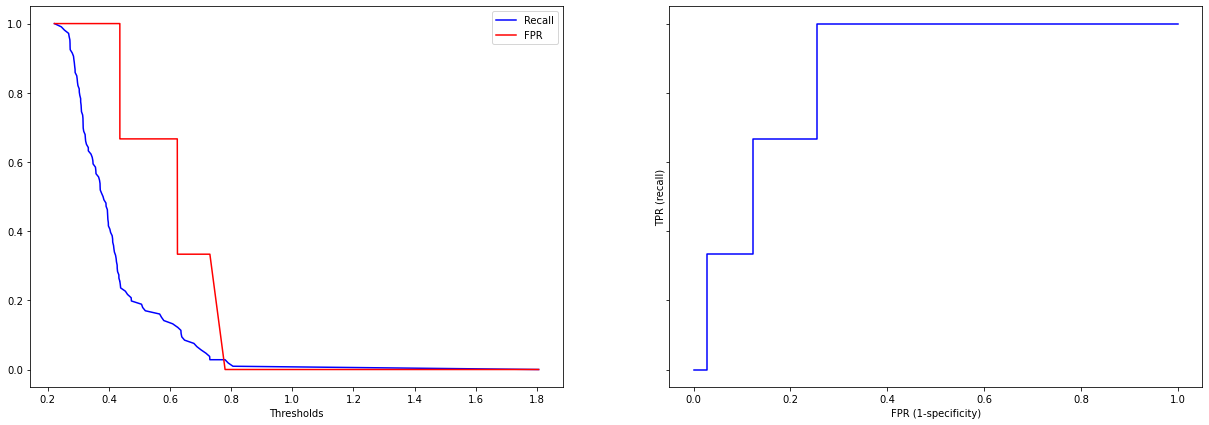

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999696  0.999391   1.000000     1.000000  0.999695  1.000000
Validation  0.639801  0.505863   0.688636     0.774312  0.579486  0.689479


Logistic Regression
╠■■■■■■■■■╣


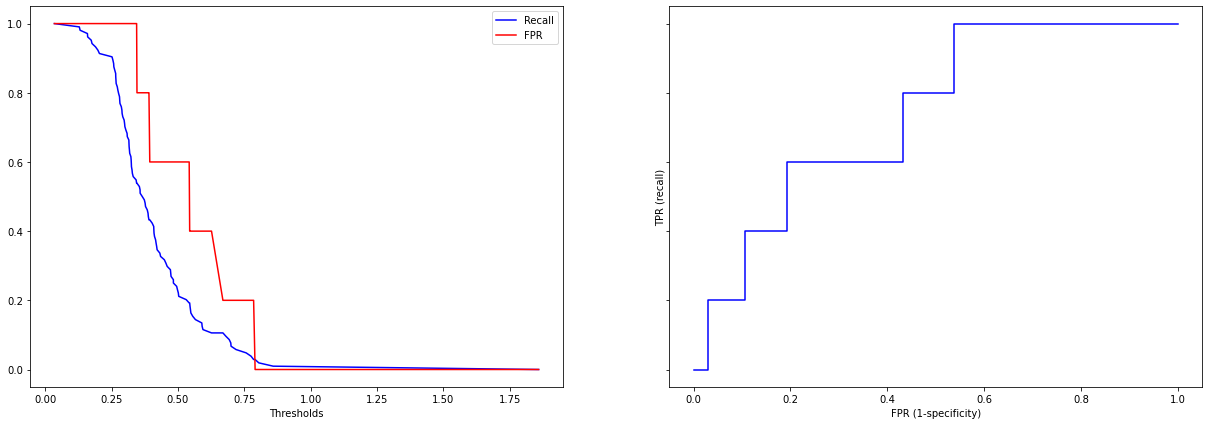

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.683134  0.558092   0.744130     0.808114  0.637741  0.747387
Validation  0.668162  0.539675   0.726338     0.797248  0.617473  0.727409

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.654916  0.495855   0.723472     0.814679   
Random Forest (100 estimators)  0.642966  0.513136   0.693981     0.773394   
XGBoost Classifier              0.617867  0.606422   0.622257     0.629358   
SVM                             0.659497  0.463928   0.757517     0.855963   
KNN                             0.639801  0.505863   0.688636     0.774312   
Logistic Regression             0.668162  0.539675   0.726338     0.797248   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.586462  0.688381  
Random Forest (100 estimators)  0.586653  0.690452  
XGBoost Classifier              0.613140  0.667488  
SVM                             0.572510  0.717633  
KNN                             0.579486  0.689479  
Logistic Regression             0.617473  0.727409

In [47]:
#ra_symptoms_nvitals
run_models(ra_symptoms_nvitals, y[ra_symptoms_nvitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


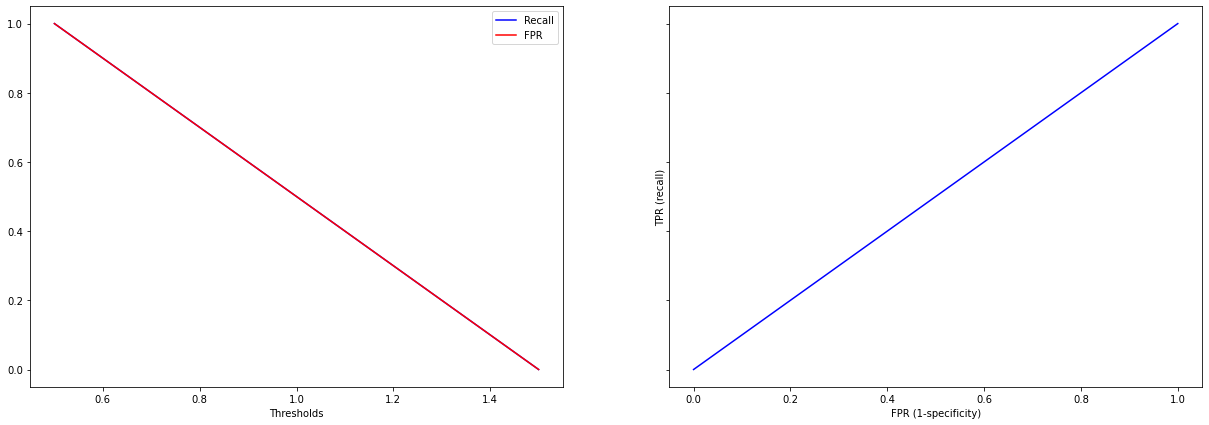

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5


MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


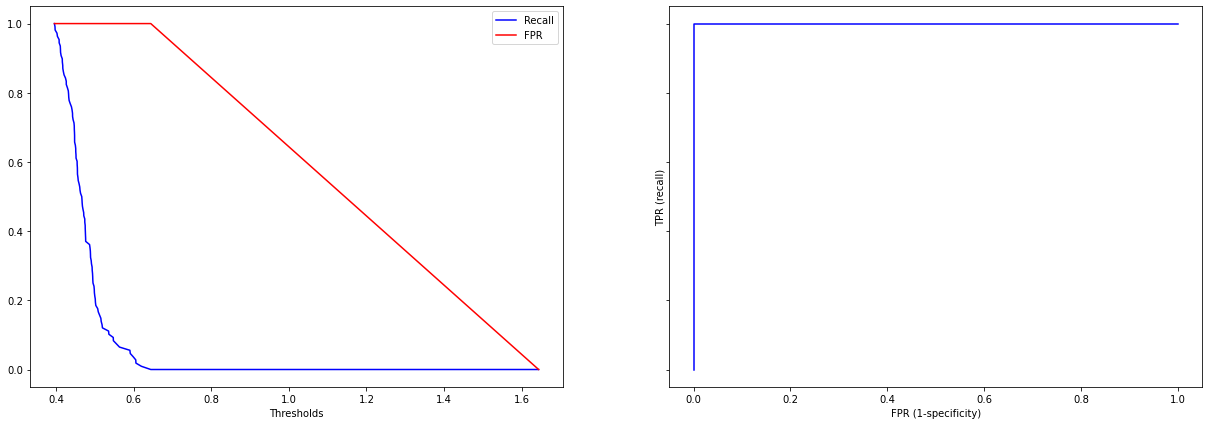

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.662337  0.535058   0.717815     0.789554  0.612943  0.721086
Validation  0.647078  0.524020   0.690870     0.770642  0.592464  0.699344


XGBoost Classifier
╠■■■■■■■■■╣


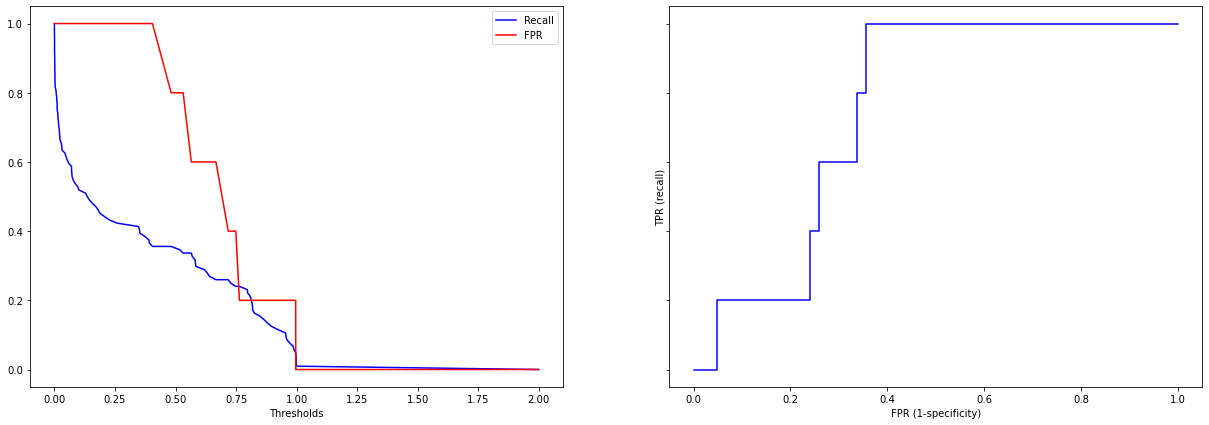

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1  ROC_AUC
Training    0.999848  0.999898   0.999797     0.999797  0.999848   1.0000
Validation  0.625148  0.606255   0.630096     0.644037  0.616894   0.6815


SVM
╠■■■■■■■■■╣


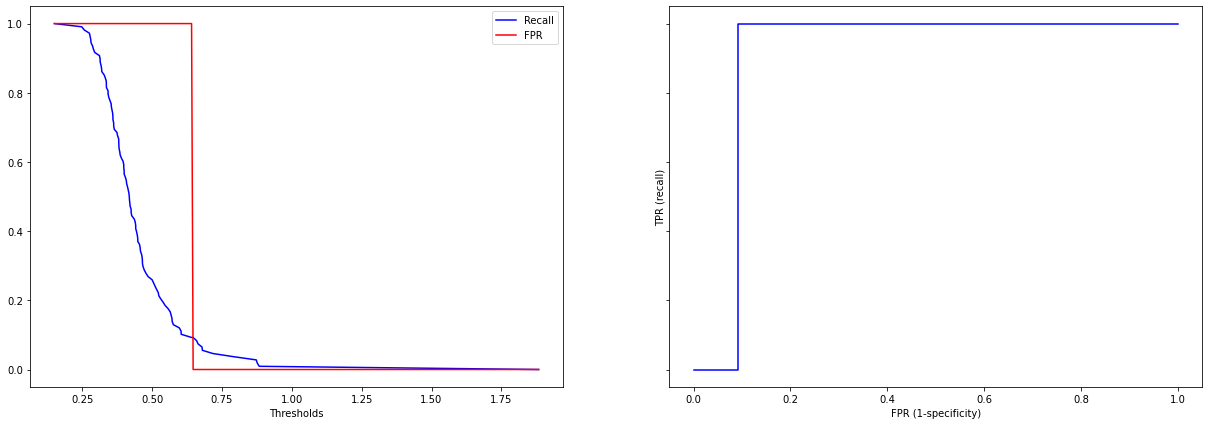

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.671418  0.491633   0.767690     0.851116  0.599248  0.743223
Validation  0.663606  0.473895   0.759789     0.854128  0.579868  0.731074


KNN
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy   Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999645  0.99929   1.000000     1.000000  0.999644  0.999999
Validation  0.614639  0.40543   0.699734     0.824771  0.508254  0.682019


Logistic Regression
╠■■■■■■■■■╣


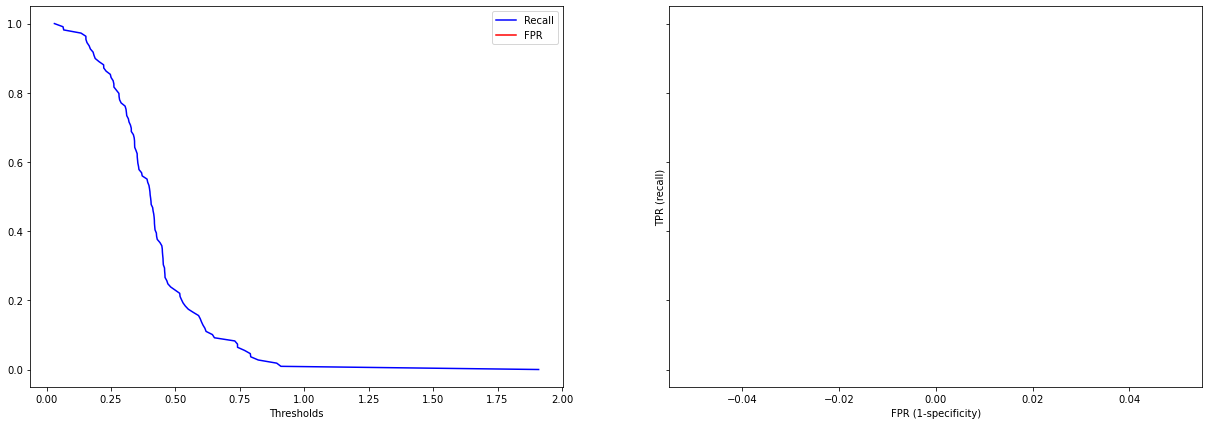

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.684960  0.573512   0.738208     0.796349  0.645245  0.746269
Validation  0.676425  0.555271   0.732718     0.798165  0.630223  0.735675

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.647078  0.524020   0.690870     0.770642   
XGBoost Classifier              0.625148  0.606255   0.630096     0.644037   
SVM                             0.663606  0.473895   0.759789     0.854128   
KNN                             0.614639  0.405430   0.699734     0.824771   
Logistic Regression             0.676425  0.555271   0.732718     0.798165   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.592464  0.699344  
XGBoost Classifier              0.616894  0.681500  
SVM                             0.579868  0.731074  
KNN                             0.508254  0.682019  
Logistic Regression             0.630223  0.735675

In [47]:
#ra_symptoms_svitals
run_models(ra_symptoms_svitals, y[ra_symptoms_svitals.index], models, ratio_negatives_to_positives=1)

All the features that were determined to be important before are also important here

Dummy Random
╠■■■■■■■■■╣


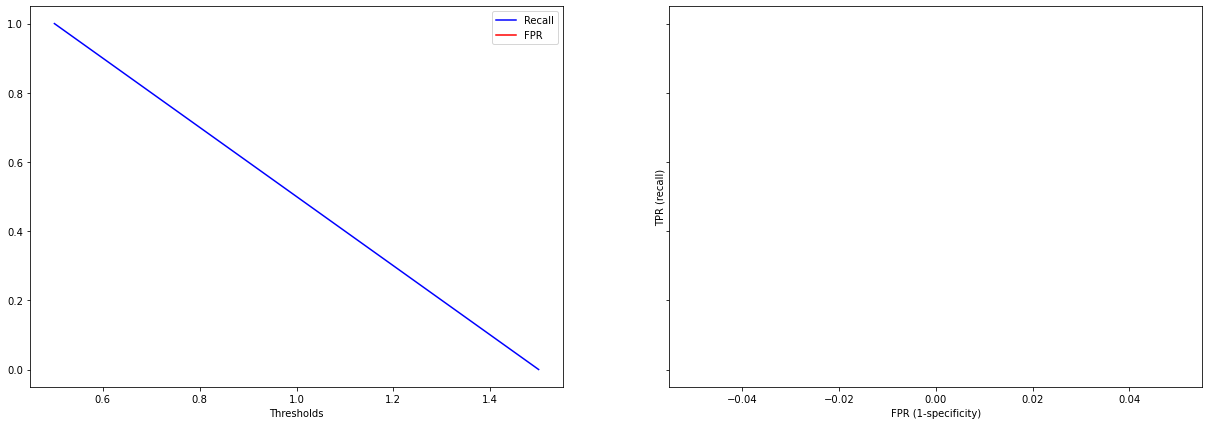

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5


MultinomialNB
╠■■■■■■■■■╣


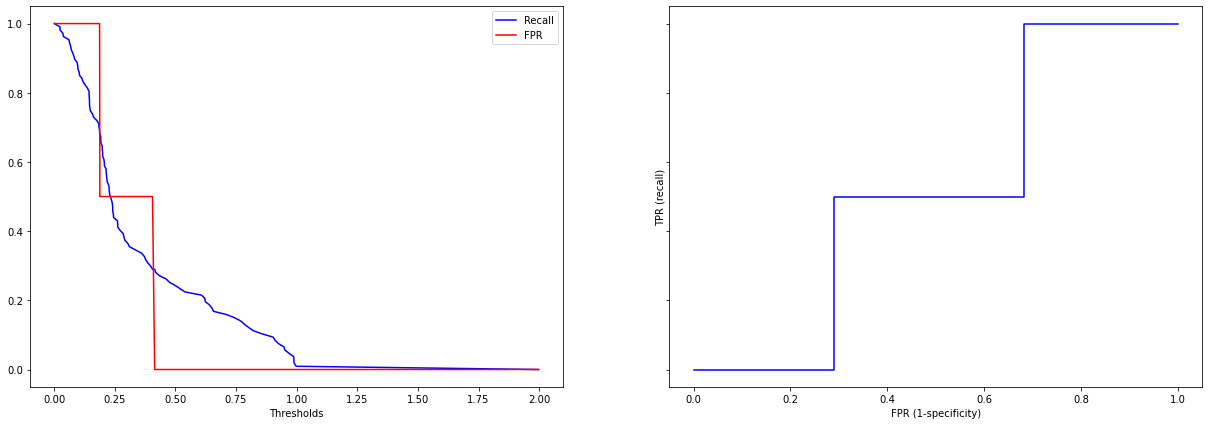

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.661323  0.518515   0.725695     0.804057  0.604677  0.715509
Validation  0.664520  0.512310   0.735718     0.817431  0.600389  0.715781


Random Forest (100 estimators)
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.666852  0.543280   0.722022     0.790365  0.619435  0.729842
Validation  0.650781  0.529525   0.698602     0.772477  0.598927  0.702723


XGBoost Classifier
╠■■■■■■■■■╣


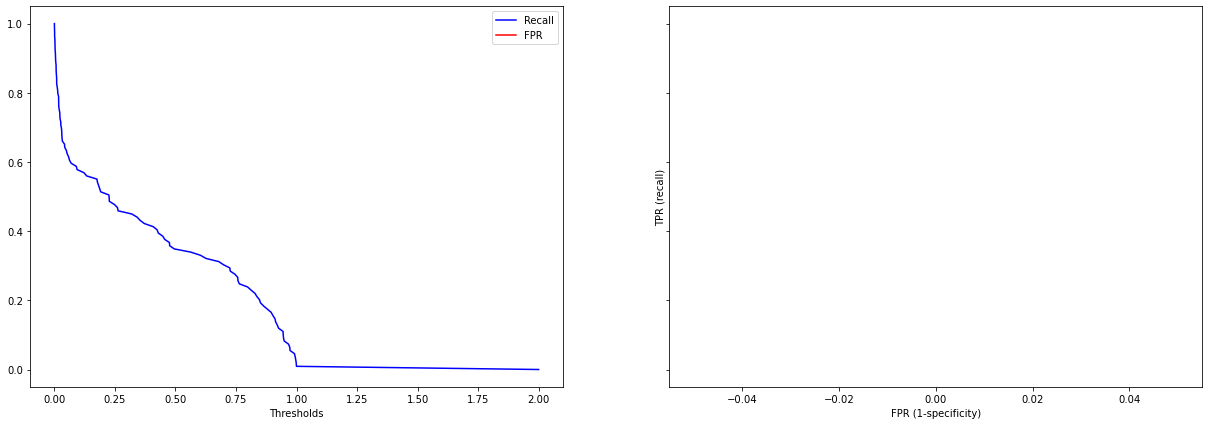

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999797  0.999797   0.999797     0.999797  0.999797  1.000000
Validation  0.640713  0.614604   0.650694     0.666972  0.631398  0.693172


SVM
╠■■■■■■■■■╣


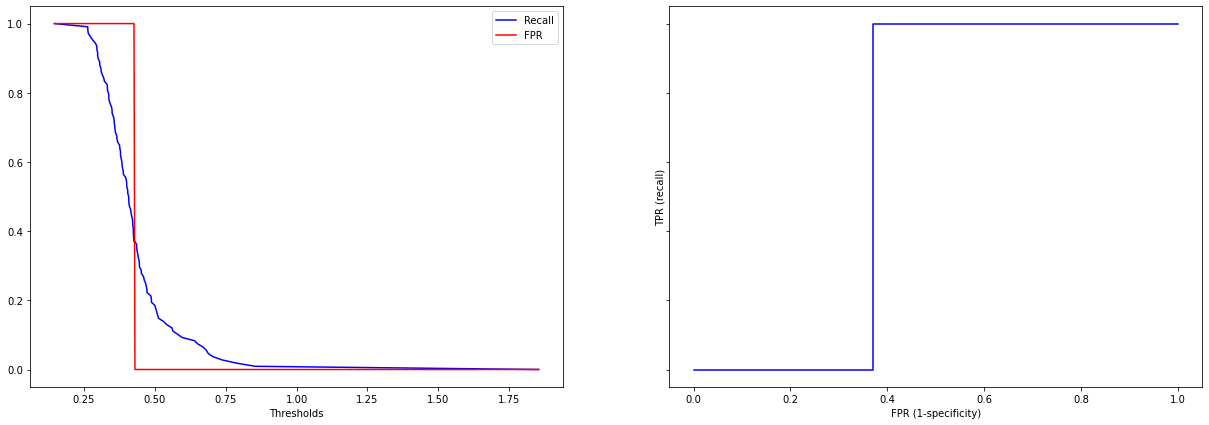

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.676591  0.503803   0.770184     0.849290  0.608466  0.750464
Validation  0.666820  0.495888   0.752545     0.838532  0.594770  0.725669


KNN
╠■■■■■■■■■╣


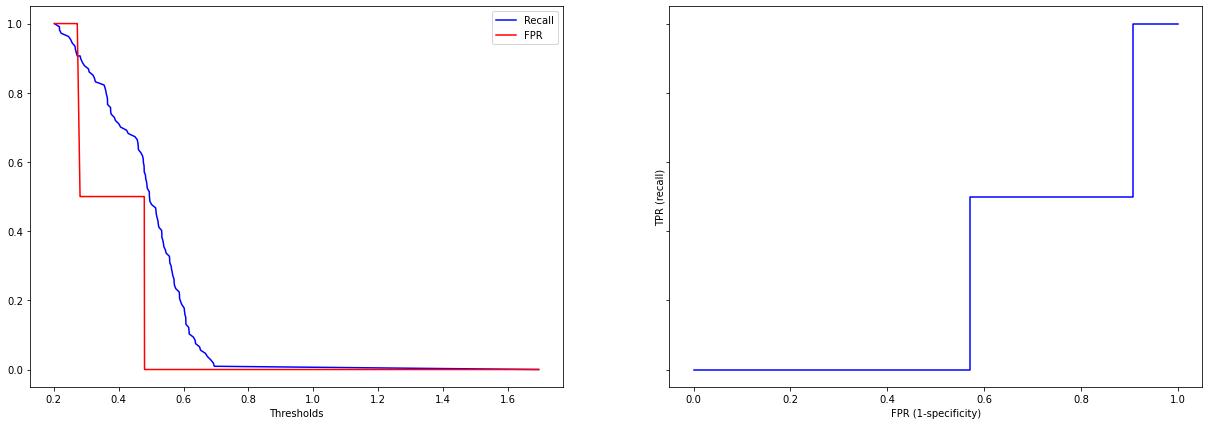

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999899  0.999797    1.00000     1.000000  0.999898  1.000000
Validation  0.576166  0.482986    0.59485     0.669725  0.530299  0.615085


Logistic Regression
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.678873  0.584470   0.720647     0.773225  0.645311  0.744799
Validation  0.661319  0.565263   0.699706     0.757798  0.623934  0.721747

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.664520  0.512310   0.735718     0.817431   
Random Forest (100 estimators)  0.650781  0.529525   0.698602     0.772477   
XGBoost Classifier              0.640713  0.614604   0.650694     0.666972   
SVM                             0.666820  0.495888   0.752545     0.838532   
KNN                             0.576166  0.482986   0.594850     0.669725   
Logistic Regression             0.661319  0.565263   0.699706     0.757798   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.600389  0.715781  
Random Forest (100 estimators)  0.598927  0.702723  
XGBoost Classifier              0.631398  0.693172  
SVM                             0.594770  0.725669  
KNN                             0.530299  0.615085  
Logistic Regression             0.623934  0.721747

In [39]:
#ra_symptoms_vitals_ex
run_models(ra_symptoms_vitals_ex, y[ra_symptoms_vitals_ex.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


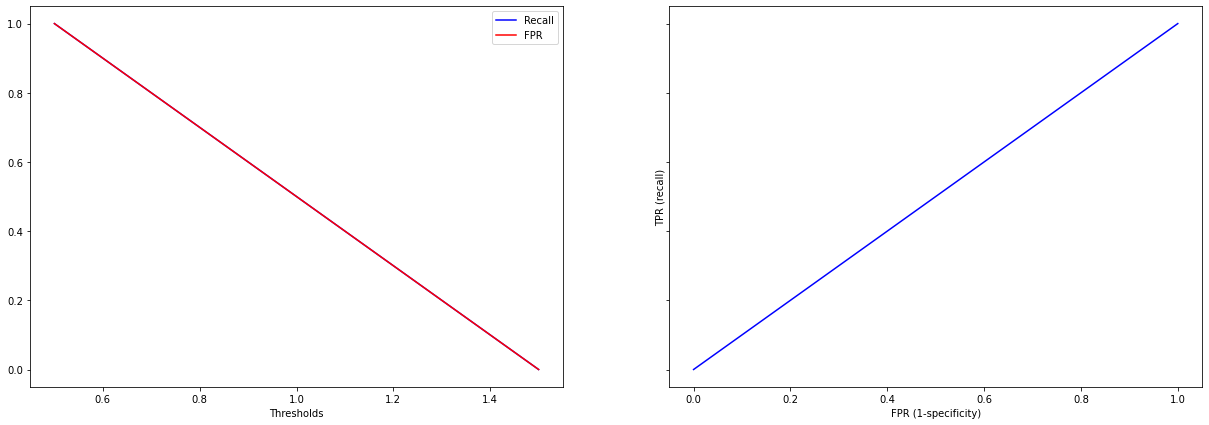

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5


MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.667206  0.529272   0.731258     0.805071  0.613844  0.730750
Validation  0.641175  0.522252   0.684166     0.760550  0.590786  0.697302


XGBoost Classifier
╠■■■■■■■■■╣


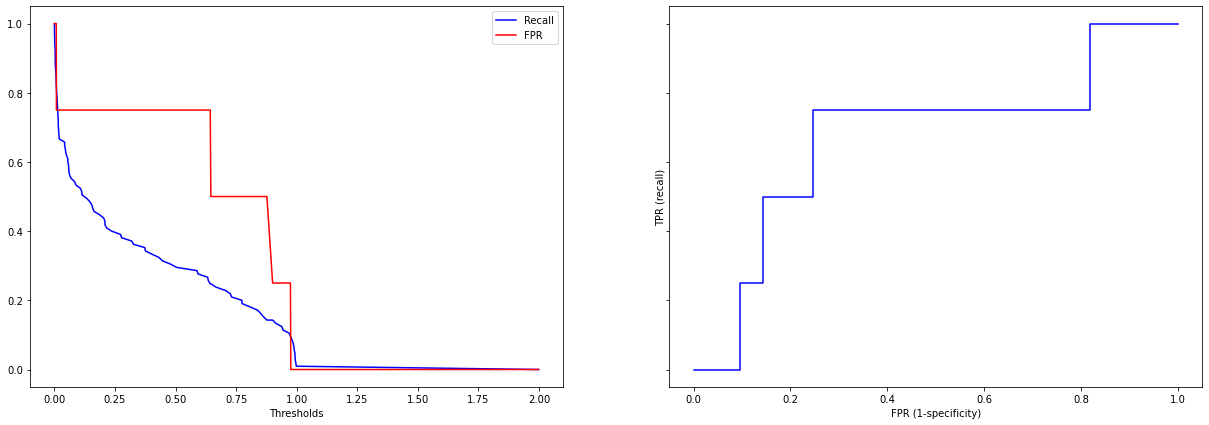

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999899  0.999898   0.999899     0.999899  0.999899  1.000000
Validation  0.619228  0.586280   0.629095     0.652294  0.606516  0.673034


SVM
╠■■■■■■■■■╣


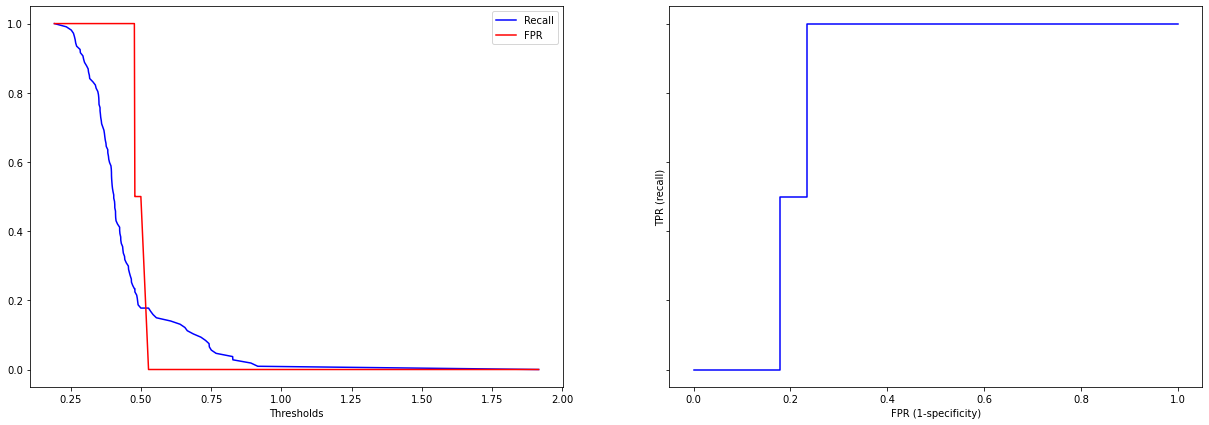

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.675069  0.502286   0.768966     0.847769  0.606513  0.748009
Validation  0.660856  0.476664   0.754913     0.845872  0.578493  0.733998


KNN
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999949  0.999899   1.000000     1.000000  0.999949  1.000000
Validation  0.634318  0.425521   0.728684     0.844037  0.535633  0.697727


Logistic Regression
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.690185  0.588938   0.738605     0.791379  0.655144  0.754114
Validation  0.668621  0.570751   0.713042     0.766972  0.630842  0.724157

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.641175  0.522252   0.684166     0.760550   
XGBoost Classifier              0.619228  0.586280   0.629095     0.652294   
SVM                             0.660856  0.476664   0.754913     0.845872   
KNN                             0.634318  0.425521   0.728684     0.844037   
Logistic Regression             0.668621  0.570751   0.713042     0.766972   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.590786  0.697302  
XGBoost Classifier              0.606516  0.673034  
SVM                             0.578493  0.733998  
KNN                             0.535633  0.697727  
Logistic Regression             0.630842  0.724157

In [48]:
#ra_symptoms_nvitals_ex
run_models(ra_symptoms_nvitals_ex, y[ra_symptoms_nvitals_ex.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


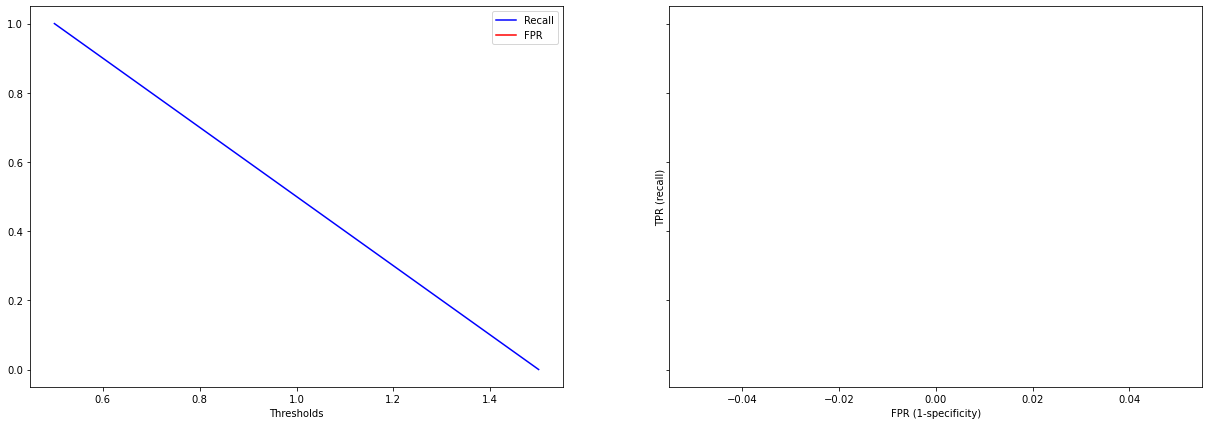

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5


MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


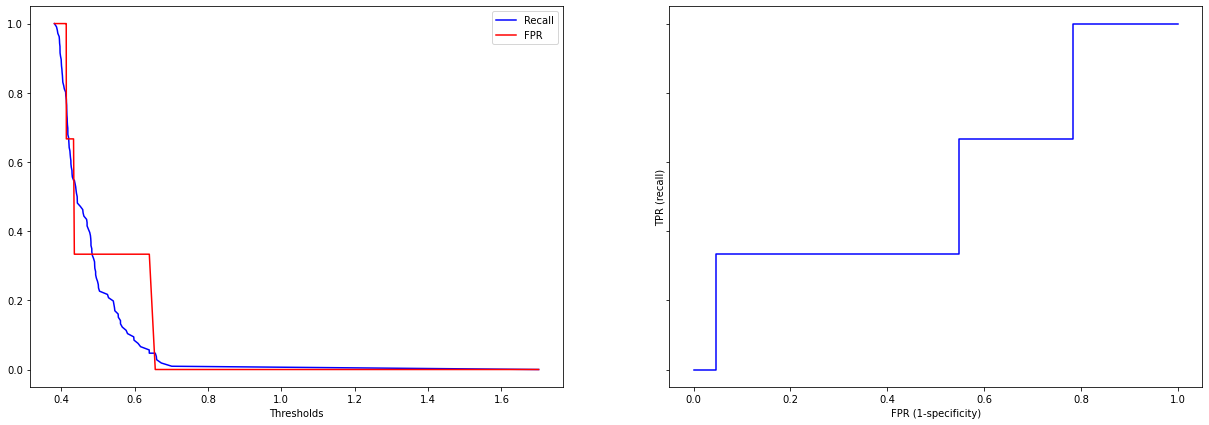

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664417  0.536574   0.721128     0.792191  0.615057  0.730527
Validation  0.656709  0.526831   0.709665     0.787156  0.601482  0.712758


XGBoost Classifier
╠■■■■■■■■■╣


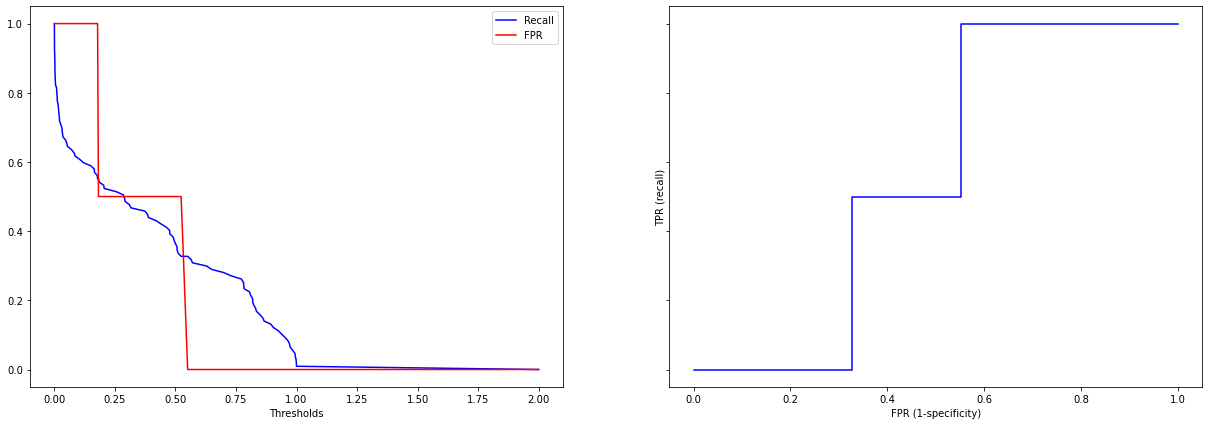

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999899  0.999899   0.999899     0.999899  0.999899  1.000000
Validation  0.632942  0.629183   0.635213     0.636697  0.631100  0.679718


SVM
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.677301  0.506538   0.769537     0.847972  0.610385  0.747769
Validation  0.667266  0.491326   0.757265     0.844037  0.592534  0.727196


KNN
╠■■■■■■■■■╣


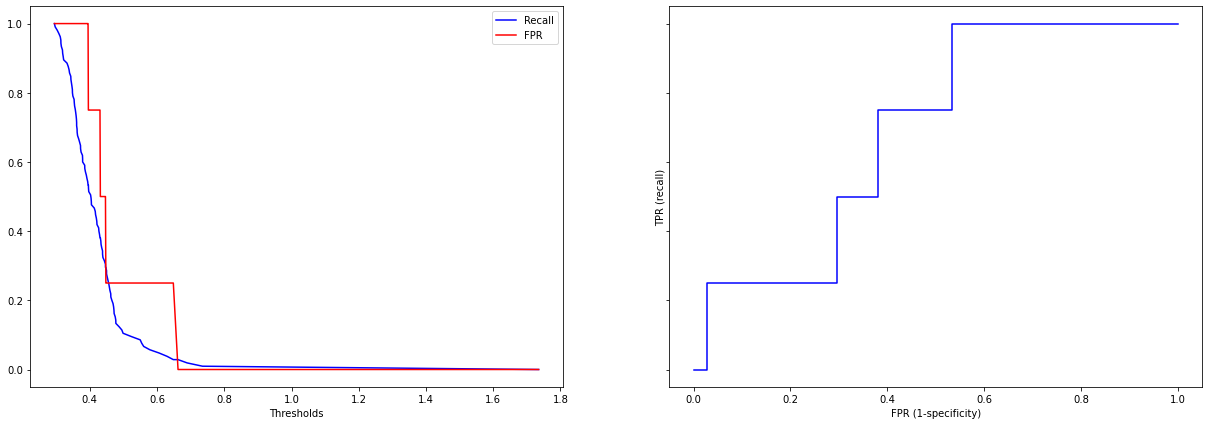

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999848  0.999696   1.000000     1.000000  0.999848  1.000000
Validation  0.617393  0.412777   0.699275     0.822936  0.515834  0.690469


Logistic Regression
╠■■■■■■■■■╣


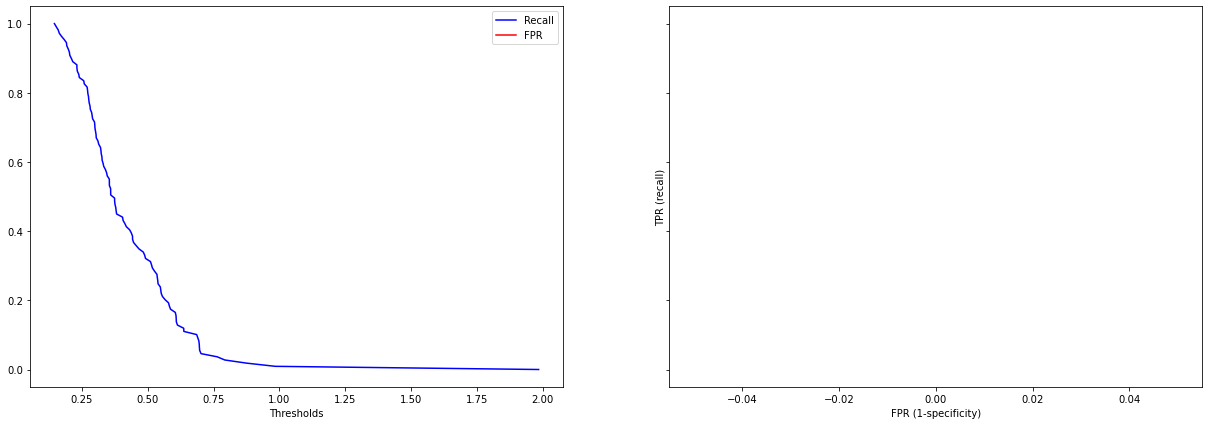

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.693076  0.590869   0.742693     0.795233  0.658043  0.755292
Validation  0.678690  0.569800   0.731349     0.788073  0.637926  0.738508

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.656709  0.526831   0.709665     0.787156   
XGBoost Classifier              0.632942  0.629183   0.635213     0.636697   
SVM                             0.667266  0.491326   0.757265     0.844037   
KNN                             0.617393  0.412777   0.699275     0.822936   
Logistic Regression             0.678690  0.569800   0.731349     0.788073   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.601482  0.712758  
XGBoost Classifier              0.631100  0.679718  
SVM                             0.592534  0.727196  
KNN                             0.515834  0.690469  
Logistic Regression             0.637926  0.738508

In [52]:
#ra_symptoms_svitals_ex
run_models(ra_symptoms_svitals_ex, y[ra_symptoms_svitals_ex.index], models, ratio_negatives_to_positives=1)

Notes:

I made a pass through all the metrics selecting the best algorithm for each one. Then, for the ones with notes I look at the recall and if the note is not satisfactory, I look for the second best. 
Repeat the process untill we find the real best metric.

|Best Metric|Model|Dataset|Value|Cons|
| :-| -: | -: | -: | -: |
|Accuracy| Logistic Regression|ra_symptoms_svitals_ex| 0.684209| None |
|Recall | XGBoost | ra_symptoms_vitals_ex |0.614604| Average everywhere else (but above .5)|
|Precision | SVM | ra_symptoms_vitals | 0.775354 | Recall below .5 (but above .4)|
|Specificity | SVM | ra_symptoms_vitals | 0.863303 | Recall below .5 (but above.4) |
|F1 Score | Logistic Regression |ra_symptoms_svitals_ex| 0.646409 | None |
|ROC_AUC Score | Logistic Regression | ra_symptoms_svitals_ex | 0.742775 | None |

Logistic Regression with ra_symptoms_svitals_ex seems to be the best.

Dummy Random
╠■■■■■■■■■╣


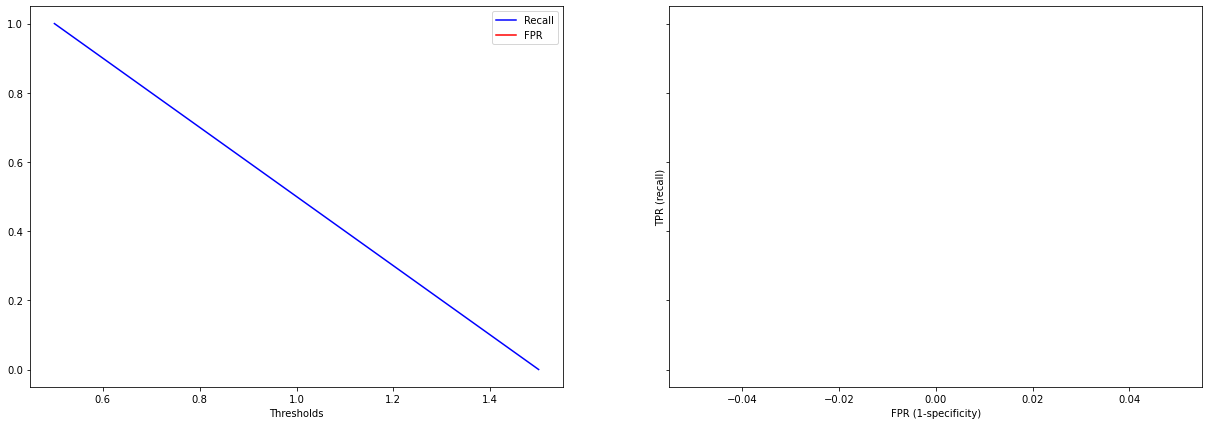

feature_importances


Permutation Importance


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500127     0.0        0.0          1.0  0.0      0.5
Validation  0.498858     0.0        0.0          1.0  0.0      0.5


MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.658027  0.571485   0.691180     0.744523  0.625495  0.716389
Validation  0.647568  0.554245   0.679027     0.741284  0.607567  0.705822


XGBoost Classifier
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.970986  0.960629   0.980954     0.981339  0.970673  0.997130
Validation  0.618240  0.582535   0.627961     0.654128  0.603485  0.664647


SVM
╠■■■■■■■■■╣


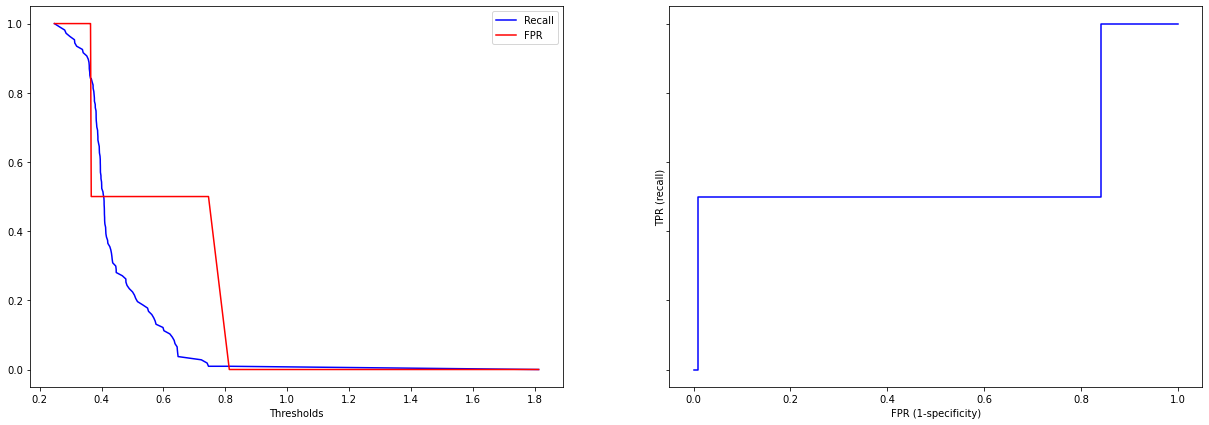

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.675070  0.510804   0.761463     0.839249  0.610709  0.740647
Validation  0.671396  0.494037   0.762289     0.849541  0.595851  0.743746


KNN
╠■■■■■■■■■╣


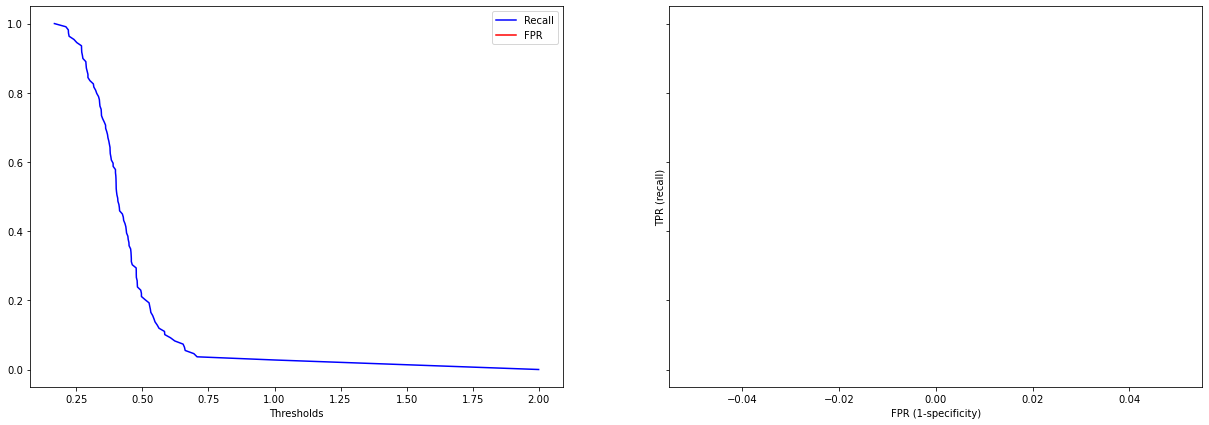

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.981334  0.965094   0.997480     0.997566  0.981013  0.999256
Validation  0.611883  0.455730   0.667507     0.768807  0.538340  0.665585


Logistic Regression
╠■■■■■■■■■╣


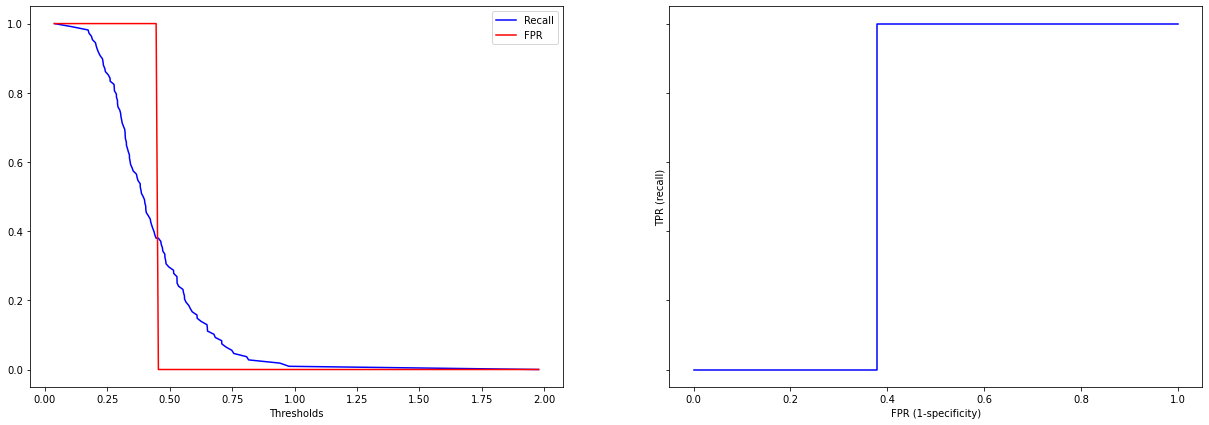

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.687598  0.576557   0.741220     0.798580  0.648496  0.747769
Validation  0.682355  0.551560   0.748407     0.813761  0.633484  0.746205

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498858  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.647568  0.554245   0.679027     0.741284   
XGBoost Classifier              0.618240  0.582535   0.627961     0.654128   
SVM                             0.671396  0.494037   0.762289     0.849541   
KNN                             0.611883  0.455730   0.667507     0.768807   
Logistic Regression             0.682355  0.551560   0.748407     0.813761   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.607567  0.705822  
XGBoost Classifier              0.603485  0.664647  
SVM                             0.595851  0.743746  
KNN                             0.538340  0.665585  
Logistic Regression             0.633484  0.746205

In [56]:
selected_features = ["wheezes", "ctab", "labored_respiration", "rr", "pulse", "temperature", "high_risk_exposure_occupation", "cough", "sob", "loss_of_smell", "muscle_sore", "loss_of_taste", "headache", "days_since_symptom_onset", "fatigue", "fever"]
selected_dataset = pd.merge(ra_symptoms_svitals_ex[selected_features], X[["asthma", "smoker", "diabetes"]], left_index=True, right_index=True)
run_models(selected_dataset, y[selected_dataset.index], models, ratio_negatives_to_positives=1)


╠■■■■■■■■■╣
Threshold: 0.4
╠■■■■■■■■■╣
Threshold: 0.42000000000000004
╠■■■■■■■■■╣
Threshold: 0.44
╠■■■■■■■■■╣
Threshold: 0.46
╠■■■■■■■■■╣
Threshold: 0.48
╠■■■■■■■■■╣
Threshold: 0.5
╠■■■■■■■■■╣
Threshold: 0.52
╠■■■■■■■■■╣
Threshold: 0.54
╠■■■■■■■■■╣
Threshold: 0.56
╠■■■■■■■■■╣
Threshold: 0.58
╠■■■■■■■■■╣
Threshold: 0.6


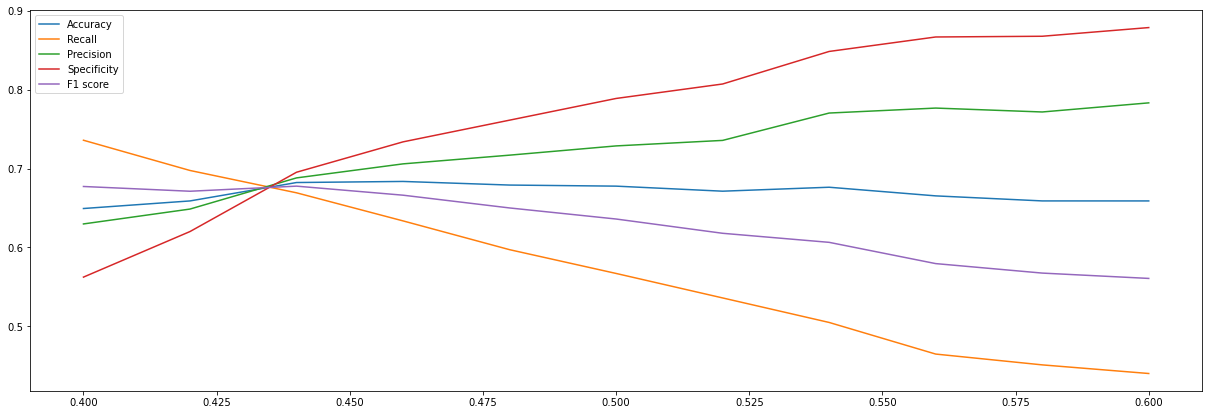

0.40      0.42      0.44      0.46      0.48      0.50  \
Accuracy     0.649397  0.659013  0.682357  0.683731  0.679146  0.677778   
Recall       0.736005  0.697648  0.669316  0.633686  0.597189  0.567031   
Precision    0.629831  0.648702  0.688228  0.706030  0.717080  0.728801   
Specificity  0.562385  0.620183  0.695413  0.733945  0.761468  0.788991   
F1           0.677340  0.671304  0.677775  0.666299  0.650116  0.636074   

                 0.52      0.54      0.56      0.58      0.60  
Accuracy     0.671369  0.676388  0.665429  0.659032  0.659017  
Recall       0.535972  0.504871  0.464779  0.451068  0.440125  
Precision    0.735791  0.770496  0.776793  0.771842  0.783404  
Specificity  0.807339  0.848624  0.866972  0.867890  0.878899  
F1           0.617973  0.606483  0.579528  0.567497  0.560724

In [55]:
run_threshold(selected_dataset, y[selected_dataset.index], models["Logistic Regression"], thresholds=np.linspace(.4,.6,num=11))

With the dataset <b>selected_features</b> and a threshold of <b>.44</b> (for high recall), <b>Logistic Regression</b> seems to be the best out of all algorithms

Probably it might be a good idea to move everything from this point forward to another notebook

## Ensemble models

In [50]:
class CustomModel():

    def __init__(self):
        self.model_1 = LogisticRegression() #The best model (has very high accuracy and precission but not very good recall. Good for determining Positive results)
        self.model_2 = RandomForestClassifier() #The one with the best recall. Poor specificity and precision but high recall. Good for determining Negative results
        self.model_3 = XGBAdapter() #The one with high accuracy, and balanced recall and precision. If none of the other 2 are sure this is the tie breaker
        self.imputer = Imputer()
        
    def fit(self, data_x, data_y):
        self.imputer.fit(data_x, data_y)
        
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
        self.model_1.fit(data_1, data_y[data_1.index])
        self.model_2.fit(data_2, data_y[data_2.index])
        self.model_3.fit(data_3, data_y[data_3.index])
        
    def predict(self, data_x):
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
                
        preds_1 = self.model_1.predict(data_1)
        preds_2 = self.model_2.predict(data_2)
        preds_3 = self.model_3.predict(data_3)
        
        preds_1[preds_1 == "Positive"] = True
        preds_1[preds_1 == "Negative"] = False
        preds_2[preds_2 == "Positive"] = True
        preds_2[preds_2 == "Negative"] = False
        preds_3[preds_3 == "Positive"] = True
        preds_3[preds_3 == "Negative"] = False
        
        final_preds = ((preds_1)| (preds_2 & preds_3)) #If predicted positive by model 1 then we keep that prediction. If predicted negative by model 2, we try to keep it. In case preds1 is False and preds2 is True the final decision is with preds3
        
        #final_preds = np.sum(np.array([preds_1, preds_2, preds_3]), axis = 0)
        
        #final_preds[final_preds <=1] = "Negative"
        #final_preds[final_preds != "Negative" ] = "Positive"
        final_preds[final_preds == True] = "Positive"
        final_preds[final_preds == False] = "Negative"
        
        
        return final_preds

In [41]:
run_models(X, y, {"FirstEnsembleModel" : CustomModel()}, folds=10, ratio_negatives_to_positives=1)

FirstEnsembleModel
'CustomModel' object has no attribute 'predict_proba'


In [42]:
weights=(np.ones(y[ra_symptoms_vitals.index].shape) + (y[ra_symptoms_vitals.index]=="Negative"))

In [63]:
logistic_model_group = {
    "LogisticVanilla" : LogisticRegression(),
    "LogisticStrongRegularization" : LogisticRegression(C=.5),
    "LogisticWeakRegularization" : LogisticRegression(C=2),
    "AdaBoost" : AdaBoostClassifier(base_estimator=LogisticRegression())
}



LogisticVanilla
╠■■■■■■■■■╣


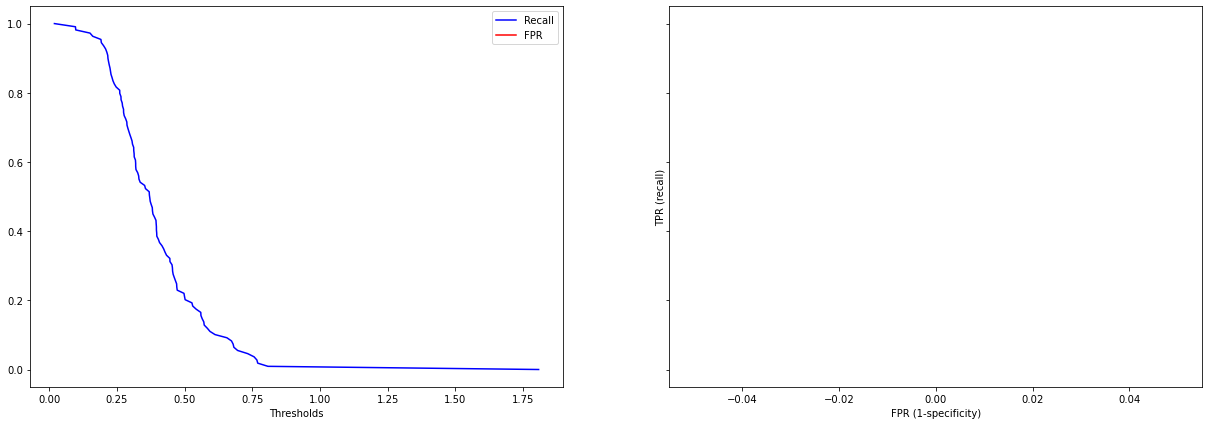

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.689423  0.580309   0.742323     0.798479  0.651246  0.749366
Validation  0.686467  0.582585   0.736412     0.790826  0.648687  0.745168


LogisticStrongRegularization
╠■■■■■■■■■╣


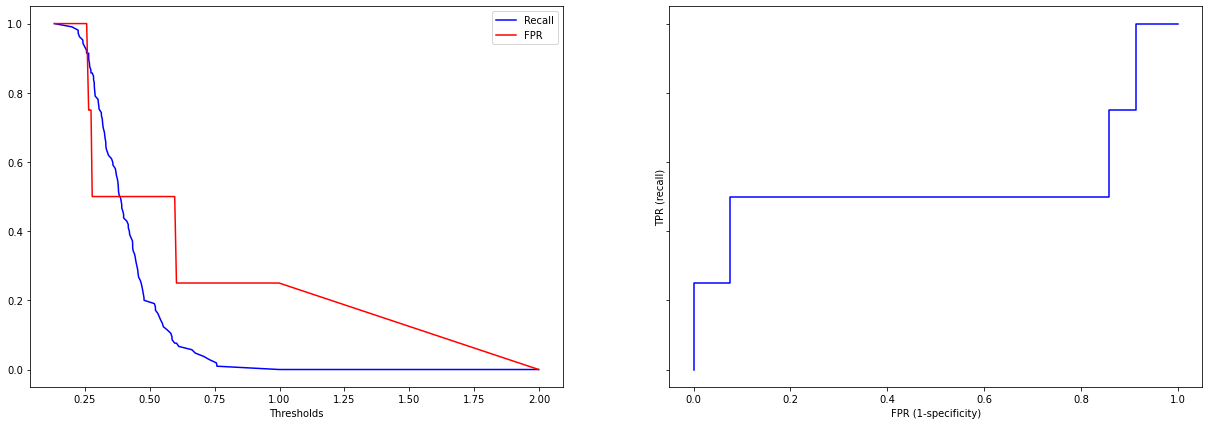

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.684200  0.575947   0.735172     0.792394  0.645698  0.743105
Validation  0.675009  0.560634   0.726897     0.789908  0.632075  0.731607


LogisticWeakRegularization
╠■■■■■■■■■╣


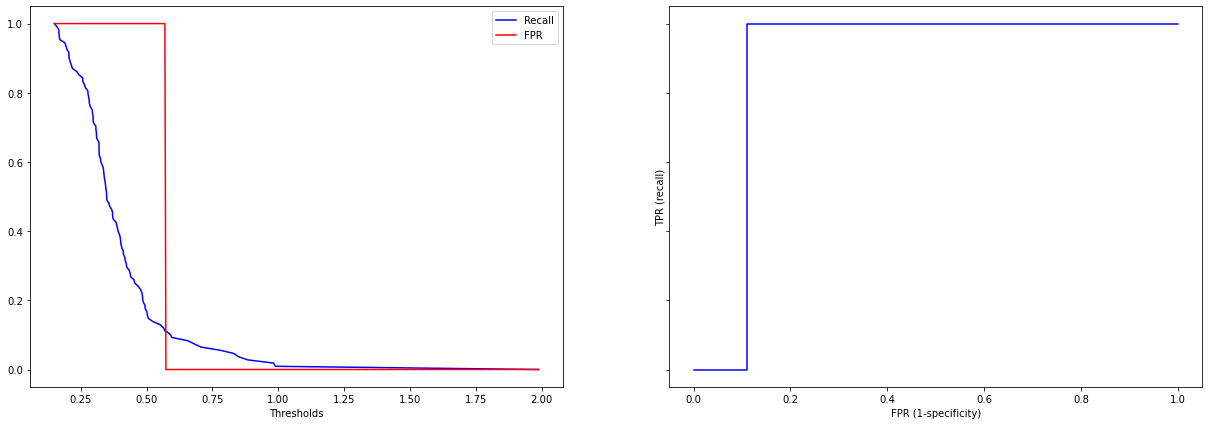

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.689474  0.577775   0.744017     0.801116  0.650333  0.747865
Validation  0.676869  0.562452   0.728840     0.791743  0.633523  0.733042


AdaBoost
╠■■■■■■■■■╣


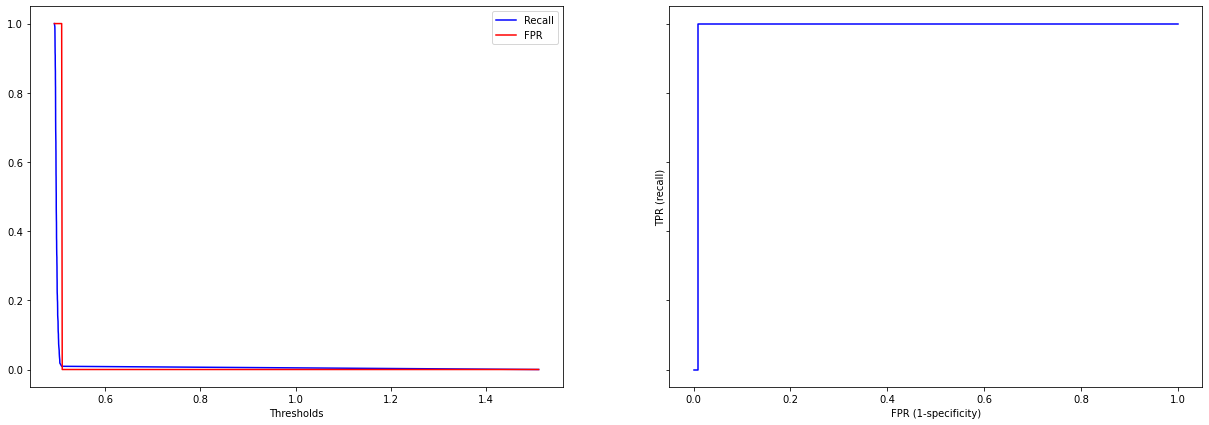

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.684454  0.586808   0.729409     0.782049  0.650192  0.738478
Validation  0.675060  0.567957   0.723158     0.782569  0.633807  0.727338

Accuracy    Recall  Precision  Specificity  \
LogisticVanilla               0.686467  0.582585   0.736412     0.790826   
LogisticStrongRegularization  0.675009  0.560634   0.726897     0.789908   
LogisticWeakRegularization    0.676869  0.562452   0.728840     0.791743   
AdaBoost                      0.675060  0.567957   0.723158     0.782569   

                                    F1   ROC_AUC  
LogisticVanilla               0.648687  0.745168  
LogisticStrongRegularization  0.632075  0.731607  
LogisticWeakRegularization    0.633523  0.733042  
AdaBoost                      0.633807  0.727338

In [73]:
run_models(selected_dataset, y[selected_dataset.index], logistic_model_group, folds=10, ratio_negatives_to_positives=1)

In general it seems that normal logistic regression beats all of the other datasets, although by running the experiment multiple times there is no clear winner (all of the results vary a lot to decide a clear winner

In [69]:
ada_configurations = {
    "Ada Vanilla" : AdaBoostClassifier(),
    "Ada Logistic" : AdaBoostClassifier(base_estimator=LogisticRegression()),
    "Ada algo" : AdaBoostClassifier(algorithm="SAMME"),
    "Ada learning rate" : AdaBoostClassifier(learning_rate=.5),
    "Ada complete" : AdaBoostClassifier(base_estimator=LogisticRegression(C=.5), algorithm="SAMME", learning_rate=.5)
    
}

Ada Vanilla
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.693481  0.586397   0.746812     0.800507  0.656531  0.761981
Validation  0.664499  0.548782   0.714022     0.780734  0.617334  0.712904


Ada Logistic
╠■■■■■■■■■╣


feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.682729  0.589144   0.724748     0.776268  0.649898  0.739727
Validation  0.678239  0.582560   0.721032     0.774312  0.642476  0.728390


Ada algo
╠■■■■■■■■■╣


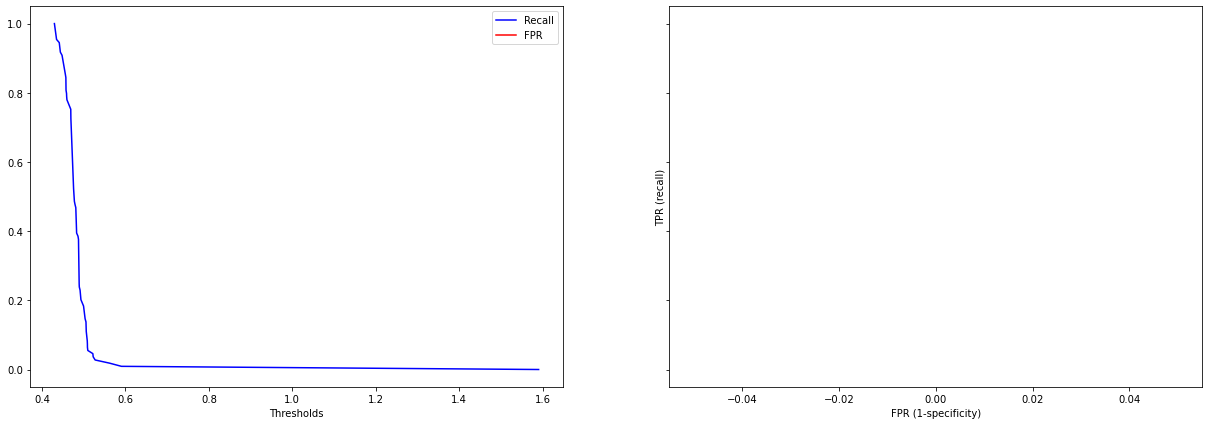

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.675221  0.562555   0.726949     0.787830  0.633646  0.733851
Validation  0.666319  0.543253   0.722375     0.789908  0.618737  0.715196


Ada learning rate
╠■■■■■■■■■╣


feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.691403  0.576866   0.748391     0.805882  0.651372  0.758346
Validation  0.668600  0.557848   0.717650     0.779817  0.626103  0.721507


Ada complete
╠■■■■■■■■■╣


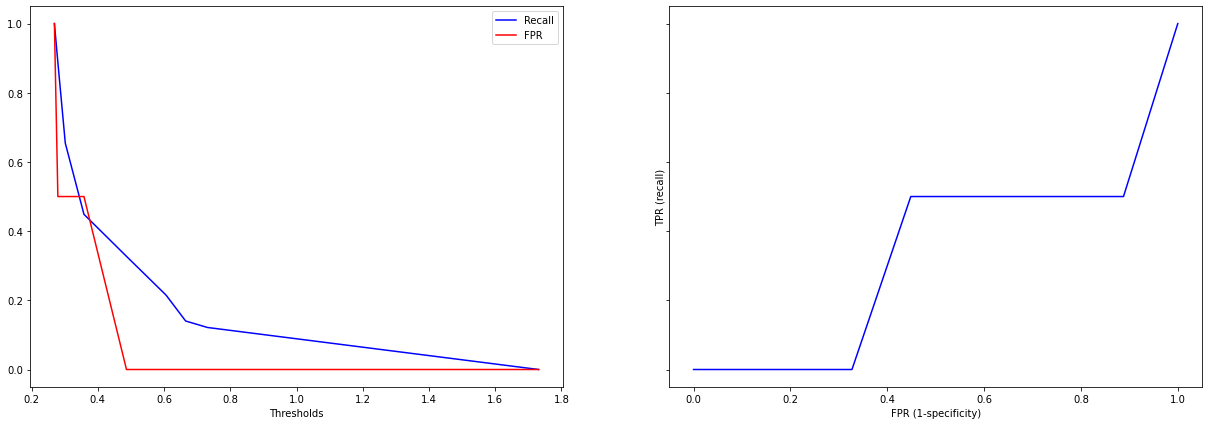

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.674106  0.631863   0.692509     0.716329  0.659306  0.732668
Validation  0.673640  0.631785   0.690460     0.715596  0.657267  0.725849

Accuracy    Recall  Precision  Specificity        F1  \
Ada Vanilla        0.664499  0.548782   0.714022     0.780734  0.617334   
Ada Logistic       0.678239  0.582560   0.721032     0.774312  0.642476   
Ada algo           0.666319  0.543253   0.722375     0.789908  0.618737   
Ada learning rate  0.668600  0.557848   0.717650     0.779817  0.626103   
Ada complete       0.673640  0.631785   0.690460     0.715596  0.657267   

                    ROC_AUC  
Ada Vanilla        0.712904  
Ada Logistic       0.728390  
Ada algo           0.715196  
Ada learning rate  0.721507  
Ada complete       0.725849

In [70]:
run_models(selected_dataset, y[selected_dataset.index], ada_configurations, ratio_negatives_to_positives=1)

Ada Vanilla
╠■■■■■■■■■╣


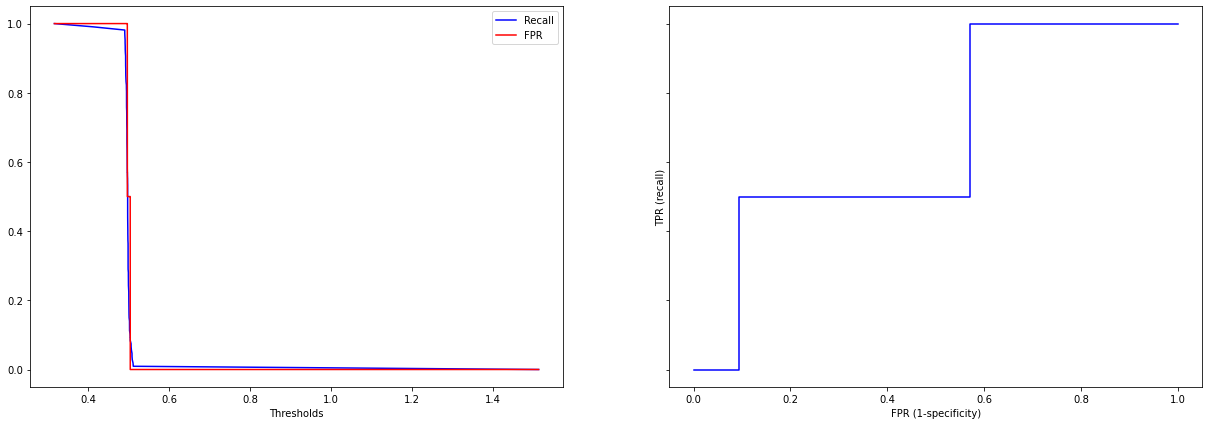

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.697793  0.592387   0.750754     0.803144  0.661931  0.768299
Validation  0.651686  0.540534   0.694718     0.763303  0.607642  0.715439


Ada Logistic
╠■■■■■■■■■╣


feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.680750  0.575746   0.728720     0.785700  0.643176  0.733667
Validation  0.667272  0.556147   0.716462     0.778899  0.624364  0.719323


Ada algo
╠■■■■■■■■■╣


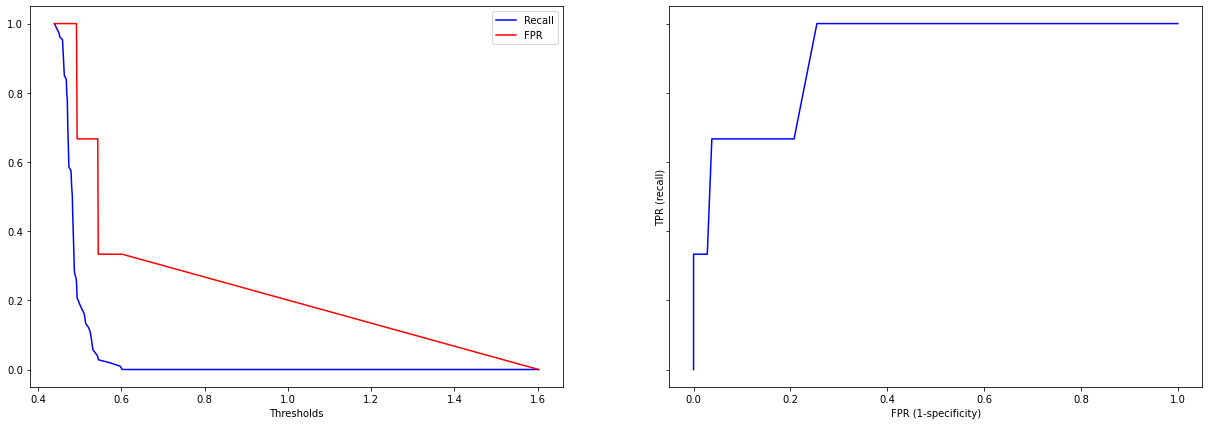

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.680091  0.583247   0.726255     0.776876  0.645045  0.740102
Validation  0.659495  0.560759   0.701245     0.758716  0.619693  0.717626


Ada learning rate
╠■■■■■■■■■╣


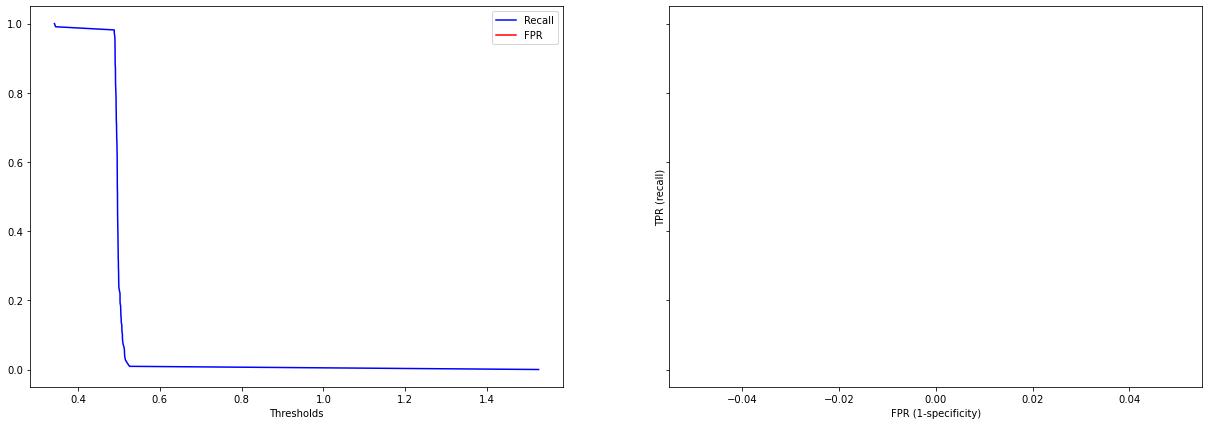

feature_importances


Permutation Importance


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.692924  0.583260   0.747826     0.802535  0.654973  0.762469
Validation  0.662716  0.541451   0.718776     0.784404  0.613032  0.717413


Ada complete
╠■■■■■■■■■╣


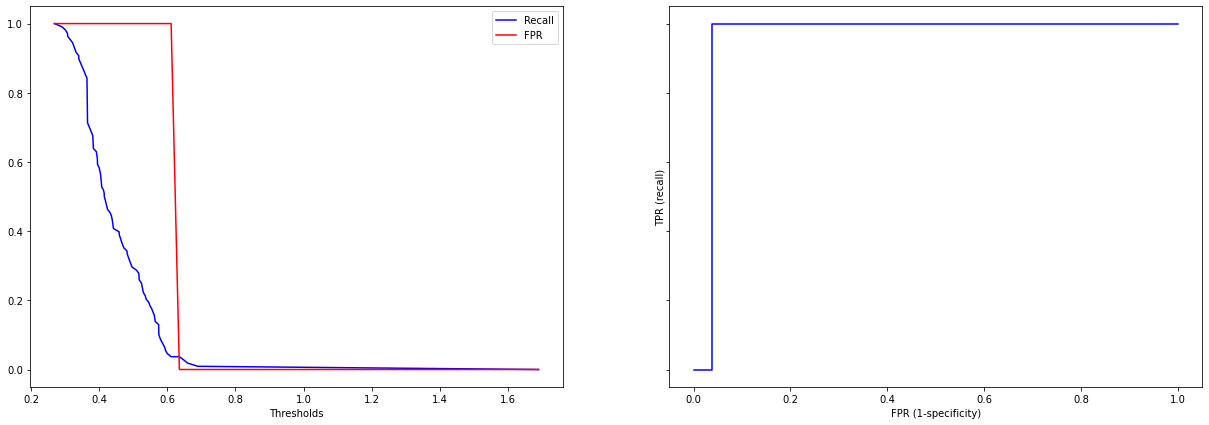

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.665634  0.627291   0.679872     0.703955  0.652121  0.717860
Validation  0.657662  0.622794   0.672159     0.692661  0.645187  0.706328

Accuracy    Recall  Precision  Specificity        F1  \
Ada Vanilla        0.651686  0.540534   0.694718     0.763303  0.607642   
Ada Logistic       0.667272  0.556147   0.716462     0.778899  0.624364   
Ada algo           0.659495  0.560759   0.701245     0.758716  0.619693   
Ada learning rate  0.662716  0.541451   0.718776     0.784404  0.613032   
Ada complete       0.657662  0.622794   0.672159     0.692661  0.645187   

                    ROC_AUC  
Ada Vanilla        0.715439  
Ada Logistic       0.719323  
Ada algo           0.717626  
Ada learning rate  0.717413  
Ada complete       0.706328

In [75]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], ada_configurations, ratio_negatives_to_positives=1)

╠■■■■■■■■■╣
Threshold: 0.47
╠■■■■■■■■■╣
Threshold: 0.475
╠■■■■■■■■■╣
Threshold: 0.48
╠■■■■■■■■■╣
Threshold: 0.485
╠■■■■■■■■■╣
Threshold: 0.49
╠■■■■■■■■■╣
Threshold: 0.495
╠■■■■■■■■■╣
Threshold: 0.5
╠■■■■■■■■■╣
Threshold: 0.505
╠■■■■■■■■■╣
Threshold: 0.51
╠■■■■■■■■■╣
Threshold: 0.515
╠■■■■■■■■■╣
Threshold: 0.52


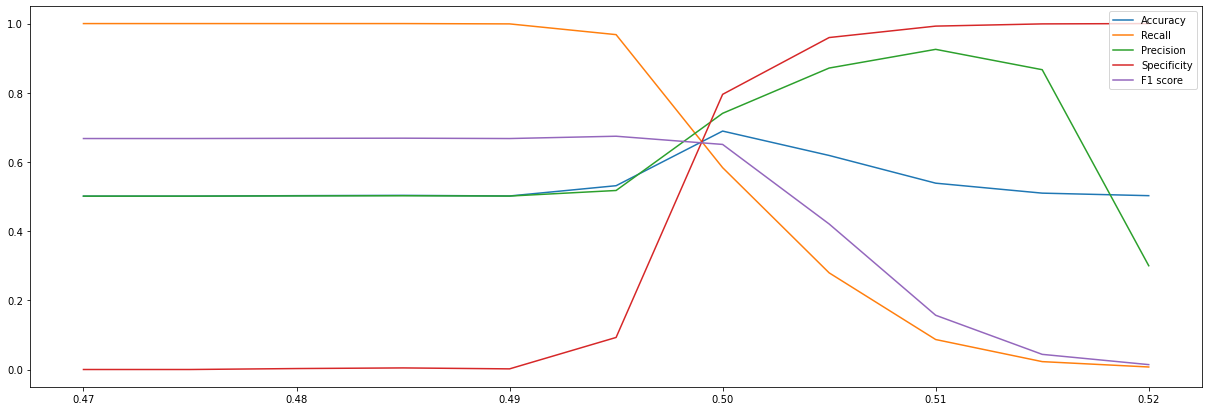

0.470     0.475     0.480     0.485     0.490     0.495  \
Accuracy     0.501142  0.501142  0.502511  0.503429  0.501600  0.531329   
Recall       1.000000  1.000000  1.000000  1.000000  0.999091  0.968040   
Precision    0.501142  0.501142  0.501833  0.502294  0.501374  0.517502   
Specificity  0.000000  0.000000  0.002752  0.004587  0.001835  0.092661   
F1           0.667680  0.667680  0.668291  0.668700  0.667682  0.674352   

                0.500     0.505     0.510     0.515     0.520  
Accuracy     0.689232  0.618749  0.538649  0.509828  0.502511  
Recall       0.583511  0.279383  0.086656  0.022777  0.007273  
Precision    0.740577  0.871445  0.925496  0.866667  0.300000  
Specificity  0.795413  0.959633  0.992661  0.999083  1.000000  
F1           0.650646  0.420646  0.156814  0.043781  0.014129

In [83]:
run_threshold(selected_dataset, y[selected_dataset.index], ada_configurations["Ada Logistic"], thresholds=np.linspace(0.47, 0.52, num=11), ratio_negatives_to_positives=1)

## Sidequest: Understanding logistic regression

In [ ]:
lr = LogisticRegression()
imp = Imputer()
imp.fit_transform(all_data, y[all_data.index])
lr.fit(all_data, y[all_data.index], sample_weight=(np.ones(y[all_data.index].shape) + (y[all_data.index]=="Negative")))

In [ ]:
lr_preds = lr.predict(all_data)

In [ ]:
manual_preds = np.dot(all_data, lr.coef_.transpose()) + lr.intercept_ #The dot product of coeficients and features plus the bias

In [ ]:
from math import exp
def logistic_function(value):
    return 1 / (1 + exp(-value))

In [ ]:
manual_preds.flatten()

In [ ]:
lfv = np.vectorize(logistic_function) #To vectorize means to apply it to vectors

In [ ]:
result = pd.Series(lfv(manual_preds).flatten())
result[result > .5] = "Positive"
result[result != "Positive"] = "Negative"

In [ ]:
a = np.array([[1,2,3,4,5],[2,4,6,8,10]])
b = np.ones((5,2))
b[:,1] *= 2

In [ ]:
np.dot(a, b)

In [ ]:
lfv(manual_preds)[lfv(manual_preds) > .5]

In [ ]:
explainer = shap.KernelExplainer(lr.predict_proba, np.zeros((1,all_data.columns.size)))

In [ ]:
shap_values = explainer.shap_values(all_data[y[all_data.index] == "Positive"].sample(1))

In [ ]:
shap_values

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1], all_data.columns)

In [ ]:
ra_symptoms_vitals.columns

In [ ]:
def calculate_shap_values(model, data_x):
    explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
    sample = data_x.sample(1)
    shap.initjs()
    display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))

In [ ]:
lr.fit(all_data, y[all_data.index])
calculate_shap_values(lr, all_data)

In [ ]:
y[all_data.index].value_counts()

In [ ]:
all_data["sats"]